# Stock Deep Recurrent Q-Network 
This notebook provides an implementation of a Deep Double Recurrent Q-Network which can solve Partially Observable Markov Decision Processes. This notebook applies the technique on time series.

In [1]:
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import csv
import itertools
%matplotlib inline
import time
from sklearn.preprocessing import MinMaxScaler
from helper import *
from StockEnv import StockEnv
import pandas as pd
from GeometricBrownianMotion import * 
from MCSAmericanOptionPricing import *
import math

seed = 1 #time.time()
random.seed(seed)
print('Seed is:' + str(seed))

Seed is:1


### Variable settings

In [2]:
risk_free_rate = 5/100
mu = risk_free_rate
sigma = 0.20
num_seeds = 200

In [3]:
save_model_freq = 10000
Normalization = False
Window_Normalization = False
test_data_ratio = 0.2

architecture = 0
nbFilters = 32
paddingType = 'same' #'causal' # 'valid'
huber_loss = True #False
dueling_type = 'max' #'naive'
mask_type = 'default' #'maskFirstHalf' # 'maskByWeights' 'default'
apply_dropout = True
batch_size = 128 #How many experience traces to use for each training step.
memory_capacity = 10000
learning_rate = 0.0001
apply_grad_clipping = True
grad_clipping = 5 # Maybe test with bigger values, e.g. 40 or 30
optimizer_type = 'Adam' # 'GradientDescent' 'RMSProp'

Colab = False
scriptDirectory = os.getcwd()

history_t = 15
option_T = 50
input_size = history_t + 2
is_training = True

min value of data: 50.55108446618011, max value of data: 75.71320001340916
train_size: 743
test_size: 185
min value of data: 160.41750891209688, max value of data: 232.0053569320216
train_size: 743
test_size: 185
min value of data: 117.39052913848273, max value of data: 239.65281150191407
train_size: 743
test_size: 185
min value of data: 61.68717100789021, max value of data: 93.3981808897496
train_size: 743
test_size: 185
min value of data: 56.87545268912853, max value of data: 90.88754177619106
train_size: 743
test_size: 185
min value of data: 94.06358565243866, max value of data: 245.37303421922587
train_size: 743
test_size: 185
min value of data: 129.93675878153329, max value of data: 232.31137151669466
train_size: 743
test_size: 185
min value of data: 129.9534825322404, max value of data: 258.1770676311054
train_size: 743
test_size: 185
min value of data: 35.20913894154504, max value of data: 65.18331821536977
train_size: 743
test_size: 185
min value of data: 101.39621501443278, ma

train_size: 743
test_size: 185
min value of data: 31.28416003503076, max value of data: 64.79461891409876
train_size: 743
test_size: 185
min value of data: 110.25013747453391, max value of data: 215.74940391091883
train_size: 743
test_size: 185
min value of data: 97.63925797801754, max value of data: 264.52166485449385
train_size: 743
test_size: 185
min value of data: 176.16707811915666, max value of data: 333.06819287743
train_size: 743
test_size: 185
min value of data: 50.31275750016771, max value of data: 90.47507798922747
train_size: 743
test_size: 185
min value of data: 72.61507754267953, max value of data: 126.10243257825478
train_size: 743
test_size: 185
min value of data: 37.66059137586361, max value of data: 84.42491508385788
train_size: 743
test_size: 185
min value of data: 120.27641067941983, max value of data: 187.95133060324198
train_size: 743
test_size: 185
min value of data: 78.26540749320638, max value of data: 132.09175503181794
train_size: 743
test_size: 185
min value

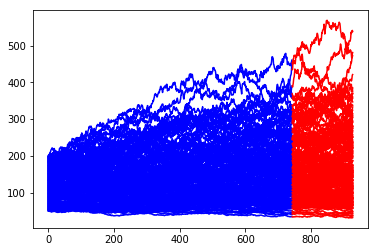

In [5]:
#Generate stocks data
stocks_data, _ = GBM(num_seeds, is_training).generate_stock_paths(mu, sigma, 928, num_seeds, is_training)
stocks_train_data = []
stocks_test_data = []
real_stocks_train_data = []
real_stocks_test_data = []
for stock_data in stocks_data:
    train_data, test_data, real_train_data, real_test_data = prepare_company_stock(stock_data, Normalization, Window_Normalization, scriptDirectory, test_data_ratio)
    stocks_train_data.append(train_data)
    stocks_test_data.append(test_data)
    real_stocks_train_data.append(real_train_data)
    real_stocks_test_data.append(real_test_data)
    plt.plot(range(len(train_data)), train_data, color='b')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), test_data, color='r') 

### Load the game environment

Setting our environment

###############################
option_T: 50
history_t: 15
build_warm_up_state_t: 12
###############################
num_batch_episodes_per_epoch: 1059
num_episodes_per_epoch: 135600
min value of stock: 126.80873014680922, max value of stock: 229.2135004855168


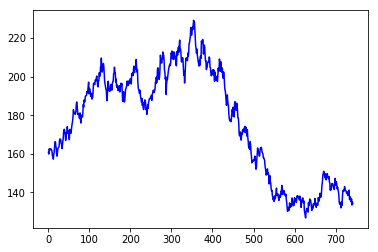

In [6]:
env = StockEnv(stocks_train_data, real_stocks_train_data, risk_free_rate, history_t=history_t, option_T=option_T)
#max_num_observations = env.max_num_observations
num_batch_episodes_per_epoch = env.get_total_num_episodes_per_epoch() // batch_size
build_warm_up_state_t = env.get_build_warm_up_state()
trace_length = option_T - build_warm_up_state_t
print('num_batch_episodes_per_epoch: ' + str(num_batch_episodes_per_epoch))
print('num_episodes_per_epoch: ' + str(env.get_total_num_episodes_per_epoch()))
print('min value of stock: '+str(min(train_data)) + ', max value of stock: '+str(max(train_data)))
plt.plot(range(len(train_data)), train_data, color='b')

### Implementing the network itself

In [7]:
class Qnetwork():
    def __init__(self,myScope):
        
        self.scalarInput = tf.placeholder(shape=[None,input_size],dtype=tf.float32)
        
        # depending on the chosen architecture, data is processed through differents layers
        
        # convolutions are used in all type, except architecture 0 which only uses LSTM
        if architecture != 0:
          self.InputConvIn = tf.reshape(self.scalarInput,shape=[-1,input_size,1], name='InputConvIn')
          self.conv1 = tf.keras.layers.Conv1D(filters=nbFilters,
                                               kernel_size=3,
                                               strides=1,
                                               padding= paddingType, #'same',
                                               activation=tf.nn.relu)(inputs=self.InputConvIn)
        
        if architecture == 0: # LSTM only
          self.scalarInputFlattened = tf.keras.layers.Flatten()(self.scalarInput)
        elif architecture == 1: # only one convolution
          self.conv1flattened = tf.reshape(self.conv1,shape=[-1,self.conv1.shape[1]*self.conv1.shape[2]], name='conv1flattened')
        elif architecture == 2: # only one convolution followed by max pooling
          self.maxPooling1D = tf.keras.layers.MaxPool1D(pool_size=2, strides=2, padding='same')(inputs=self.conv1)
          self.maxPooling1Dflattened = tf.reshape(self.maxPooling1D,shape=[-1,self.maxPooling1D.shape[1]*self.maxPooling1D.shape[2]], name='maxPooling1Dflattened')
        elif architecture == 3: # only one convolution followed by average pooling
          self.AveragePooling1D = tf.keras.layers.AveragePooling1D(pool_size=2, strides=2, padding='same')(inputs=self.conv1)
          self.AveragePooling1Dflattened = tf.reshape(self.AveragePooling1D,shape=[-1,self.AveragePooling1D.shape[1]*self.AveragePooling1D.shape[2]], name='AveragePooling1Dflattened')  
        elif architecture == 4: #VGG (one block of 2 convolutions followed by avg pooling)
          self.conv2 = tf.keras.layers.Conv1D(filters=nbFilters,
                                               kernel_size=3,
                                               strides=1,
                                               padding= paddingType, #'same',
                                               activation=tf.nn.relu)(inputs=self.conv1)
          self.AveragePooling1D4 = tf.keras.layers.AveragePooling1D(pool_size=2, strides=2, padding='same')(inputs=self.conv2)
          self.AveragePooling1Dflattened4 = tf.reshape(self.AveragePooling1D4,shape=[-1,self.AveragePooling1D4.shape[1]*self.AveragePooling1D4.shape[2]], name='AveragePooling1Dflattened4')
        elif architecture == 5: #Lenet (conv, avg pooling, conv, avg pooling)
          self.AveragePooling1D = tf.keras.layers.AveragePooling1D(pool_size=2, strides=2, padding='same')(inputs=self.conv1)
          self.conv2 = tf.keras.layers.Conv1D(filters=nbFilters,
                                               kernel_size=3,#5, #3, #maybe unstable calculations because of 5 instead of 3
                                               strides=1,
                                               padding= paddingType, #'same',
                                               activation=tf.nn.relu)(inputs=self.AveragePooling1D)
          self.AveragePooling1D5 = tf.keras.layers.AveragePooling1D(pool_size=2, strides=2, padding='same')(inputs=self.conv2)
          self.AveragePooling1Dflattened5 = tf.reshape(self.AveragePooling1D5,shape=[-1,self.AveragePooling1D5.shape[1]*self.AveragePooling1D5.shape[2]], name='AveragePooling1Dflattened5')
        elif architecture == 6: #Googlenet (Inception net: combine (conv&avgPooling) + conv1 + conv3 + conv5)
          self.AveragePooling1D = tf.keras.layers.AveragePooling1D(pool_size=2, strides=2, padding='same')(inputs=self.conv1)
          self.conv11 = tf.keras.layers.Conv1D(filters=5,
                                             kernel_size=1,
                                             strides=1,
                                             padding=paddingType,#'same',
                                             activation=tf.nn.relu)(inputs=self.AveragePooling1D)
          self.conv3 = tf.keras.layers.Conv1D(filters=5,
                                             kernel_size=3,
                                             strides=1,
                                             padding=paddingType,#'same',
                                             activation=tf.nn.relu)(inputs=self.AveragePooling1D)
          self.conv5 = tf.keras.layers.Conv1D(filters=5,
                                             kernel_size=5,
                                             strides=1,
                                             padding=paddingType,#'same',
                                             activation=tf.nn.relu)(inputs=self.AveragePooling1D)
          self.filterconcatenation = tf.concat([self.conv11, self.conv3, self.conv5, self.AveragePooling1D], 2, name = 'filterconcatenation')
          self.filterconcatenationflattened = tf.reshape(self.filterconcatenation,shape=[-1,self.filterconcatenation.shape[1]*self.filterconcatenation.shape[2]], name='filterconcatenationflattened')
        
        self.trainLength = tf.placeholder(dtype=tf.int32)
        self.batch_size = tf.placeholder(dtype=tf.int32,shape=[])
 
        #We take the output from the final convolutional layer and send it to a recurrent layer.
        #The input must be reshaped into [batch x trace x units] for rnn processing, 
        #and then returned to [batch x units] when sent through the upper levles.
        if architecture == 0:
          self.convFlat = tf.reshape(self.scalarInputFlattened,[self.batch_size,self.trainLength,input_size])
        elif architecture == 1:
          self.convFlat = tf.reshape(self.conv1flattened,[self.batch_size,self.trainLength,self.conv1flattened.shape[1]])
        elif architecture == 2:
          self.convFlat = tf.reshape(self.maxPooling1Dflattened,[self.batch_size,self.trainLength,self.maxPooling1Dflattened.shape[1]])
        elif architecture == 3:
          self.convFlat = tf.reshape(self.AveragePooling1Dflattened,[self.batch_size,self.trainLength,self.AveragePooling1Dflattened.shape[1]])
        elif architecture == 4:
          self.convFlat = tf.reshape(self.AveragePooling1Dflattened4,[self.batch_size,self.trainLength,self.AveragePooling1Dflattened4.shape[1]])
        elif architecture == 5:
          self.convFlat = tf.reshape(self.AveragePooling1Dflattened5,[self.batch_size,self.trainLength,self.AveragePooling1Dflattened5.shape[1]])
        elif architecture == 6:
          self.convFlat = tf.reshape(self.filterconcatenationflattened,[self.batch_size,self.trainLength,self.filterconcatenationflattened.shape[1]])
        
        # use cudnn-based cells to leverage Nvidia GPUs
        single_cell = lambda: tf.contrib.cudnn_rnn.CudnnCompatibleLSTMCell(h_size)
    
        # NOTE: Even if there's only one layer, the cell needs to be wrapped in MultiRNNCell.
        lstm_cells = [single_cell() for _ in range(num_layers)]
        if is_training and apply_dropout and dropout < 1:
            lstm_cells = [tf.contrib.rnn.DropoutWrapper(
                lstm, input_keep_prob=1.0, output_keep_prob=1.0 - dropout, state_keep_prob=1.0 - dropout
            ) for lstm in lstm_cells]
        multi_cell = tf.nn.rnn_cell.MultiRNNCell(lstm_cells, state_is_tuple=True)

        self.state_in = tf.placeholder(tf.float32, [num_layers, 2, None, h_size])
        state_per_layer_list = tf.unstack(self.state_in, axis=0)
        rnn_tuple_state = tuple(
            [tf.contrib.rnn.LSTMStateTuple(state_per_layer_list[idx][0], state_per_layer_list[idx][1])
             for idx in range(num_layers)]
        )
        
        # calculate the real length of each episode (since remaining states are filled with 0s after selling)
        # This is required by RNN 
        self.seq_len = length(self.convFlat)
        
        self.rnn,self.rnn_state = tf.nn.dynamic_rnn(\
                cell=multi_cell,
                inputs=self.convFlat,                                    
                dtype=tf.float32,
                initial_state=rnn_tuple_state, 
                sequence_length=self.seq_len,
                scope=myScope+'_lstm')
        

        self.rnn = tf.reshape(self.rnn,shape=[-1,h_size])
        #The output from the LSTM is then split into separate Value and Advantage streams
        self.streamA,self.streamV = tf.split(self.rnn,2,1)
        initializer = tf.contrib.layers.xavier_initializer()
        self.AW = tf.Variable(initializer([h_size//2,2]))
        self.VW = tf.Variable(initializer([h_size//2,1]))
        self.Advantage = tf.matmul(self.streamA,self.AW)
        self.Value = tf.matmul(self.streamV,self.VW)
        
        #Then combine them together to get our final Q-values.
        if dueling_type == 'avg':
            self.Qout = self.Value + tf.subtract(self.Advantage,tf.reduce_mean(self.Advantage,axis=1,keep_dims=True))
        elif dueling_type == 'max':
            self.Qout = self.Value + tf.subtract(self.Advantage,tf.reduce_max(self.Advantage,axis=1,keep_dims=True))
        elif dueling_type == 'naive':
            self.Qout = self.Value + self.Advantage
        
        self.predict = tf.argmax(self.Qout,1)
        
        
        #Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
        self.targetQ = tf.placeholder(shape=[None],dtype=tf.float32)
        self.actions = tf.placeholder(shape=[None],dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.actions,2,dtype=tf.float32)
        
        self.Q = tf.reduce_sum(tf.multiply(self.Qout, self.actions_onehot), axis=1)
        
        # calculate the temporal difference error.
        if huber_loss == True:
            self.td_error = tf.losses.huber_loss(self.targetQ, self.Q, reduction=tf.losses.Reduction.NONE)
        else:
            self.td_error = tf.square(self.targetQ - self.Q)
            
        #For test purpose
        self.Q_sell_error = tf.square(self.Qout[:,1] - self.scalarInput[:,0])
        self.Q_sell_loss = tf.cast(tf.reduce_sum(self.Q_sell_error), tf.float64) / tf.cast(tf.reduce_sum(self.seq_len), tf.float64)

        # In order to only propogate accurate gradients through the network, we can mask the first
        # half of the losses for each trace as per Lample & Chaplot 2016
        # We can also use gradual weights to avoid neglecting short episodes at the beginning
        # maybe seq_len used in averaging should also change subsequently !
        if mask_type == 'maskFirstHalf':
            self.maskA = tf.zeros([self.batch_size,self.trainLength//2])
            self.maskB = tf.ones([self.batch_size,self.trainLength//2])
            self.mask = tf.concat([self.maskA,self.maskB],1)
            self.mask = tf.reshape(self.mask,[-1])
            self.td_error = self.td_error * self.mask
        elif mask_type == 'maskByWeights': 
            #self.mask_weights = tf.range(start=0, limit=1, delta=1/self.trainLength)
            self.mask_weights = tf.range(start=0.1, limit=1, delta=0.9/tf.cast(self.trainLength, tf.float32))
            self.mask = tf.tile(self.mask_weights, [self.batch_size])
            self.td_error = tf.multiply(self.td_error, tf.cast(self.mask, tf.float32))
        elif mask_type == 'default':
            self.td_error = self.td_error
        
        # divide by the real length of episodes instead of averaging which is incorrect
        self.loss = tf.cast(tf.reduce_sum(self.td_error), tf.float64) / tf.cast(tf.reduce_sum(self.seq_len), tf.float64)
        self.check_ops = tf.debugging.check_numerics( self.loss, "self.loss contain Nan or Inf", name="self.check_ops")
        
        if optimizer_type == 'Adam':
            optimizer = tf.train.AdamOptimizer(learning_rate)
        elif optimizer_type == 'GradientDescent':
            optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        elif optimizer_type == 'RMSProp':
            optimizer = tf.train.RMSPropOptimizer(learning_rate)
        
        if apply_grad_clipping:
            # calculate gradients and clip them to handle outliers
            tvars = tf.trainable_variables()
            grads, _ = tf.clip_by_global_norm(tf.gradients(self.loss, tvars), grad_clipping)
            self.updateModel = optimizer.apply_gradients(
                    zip(grads, tvars),
                    # global_step=tf.contrib.framework.get_or_create_global_step(),
                    name="updateModel")
        else:
            self.updateModel = optimizer.minimize(self.loss, name="updateModel")

### Experience Replay

These classes allow us to store experies and sample then randomly to train the network.
Episode buffer stores experiences for each individal episode.
Experience buffer stores entire episodes of experience, and sample() allows us to get training batches needed from the network.

In [8]:
class experience_buffer():
    def __init__(self, buffer_size = memory_capacity, build_warm_up_state_t=build_warm_up_state_t):
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self,experience):
        if len(self.buffer) + 1 >= self.buffer_size:
            self.buffer[0:(1+len(self.buffer))-self.buffer_size] = []
        self.buffer.append(experience)
    
    def sample(self,batch_size):
        sampled_episodes = random.sample(self.buffer,batch_size)
        #sampled_episodes = np.array(sampled_episodes)
        sampled_episodes = self.processEpisodes(sampled_episodes)
        return np.reshape(sampled_episodes,[-1,5])
    
    def processEpisodes(self,sampled_episodes):
        sampledTraces = []
        for episode in sampled_episodes:
            sampledTraces.append(episode[build_warm_up_state_t:])
        sampledTraces = np.array(sampledTraces)
        return sampledTraces

### Training the network

In [9]:
#Setting the training parameters
num_layers = 3 # Number of layer of LSTM
h_size = 512 #The size of the final convolutional layer before splitting it into Advantage and Value streams.
keep_prob = 0.8
dropout = 1 - keep_prob  # dropout amount
update_freq = 5 #How often to perform a training step.
update_online_freq = 5
update_target_freq = 300
gamma = env.get_discount_factor(1) # discount for 1 day
startE = 1 #Starting chance of random action
endE = 0.1 #Final chance of random action
num_epochs = 5
num_episodes = env.get_total_num_episodes_per_epoch()*num_epochs
pre_train_episodes = 1000
annealing_episodes = int(num_episodes * 0.3)
pre_exploitation_episodes = int(num_episodes * 0.6)
annealing_exploitation_episodes = int(num_episodes * 0.25)
exploitationE =  0.01
load_model = False #Whether to load a saved model.
path = os.path.join(scriptDirectory, 'savedModel') #The path to save our model to.
max_epLength = option_T
summaryLength = 100 #Number of epidoes to periodically save for analysis
summaryAverageReward = 5000
summaryEpoch = env.get_total_num_episodes_per_epoch()
tau = 0.001 # learning rate (also referred to as step size) for target network
softUpdate = False # use soft or hard updates
trained_model_name = os.path.join(path, 'RL_10000rep_200seeds_0001_128batch_1000pre_arch' + str(architecture)\
                    + '-option_T' + str(option_T) + '-history_t' + str(history_t)\
                    + '-dueling_type' + str(dueling_type)\
                    + '-freq' + str(update_target_freq) + '-batch' + str(batch_size)\
                    + '-capacity' + str(memory_capacity) + '-lambda' + str(learning_rate))

final_trained_model_name = trained_model_name + '-final'
exploration_type = 'Random'
print('#num_episodes: ' + str(num_episodes))
print('#trace_length: ' + str(trace_length))
print('#gamma: ' + str(gamma))

#num_episodes: 678000
#trace_length: 38
#gamma: 0.9998016069840849


In [10]:
begin_time = time.time()
tf.reset_default_graph()
#We define the primary and target q-networks
mainQN = Qnetwork('main')
targetQN = Qnetwork('target')


init = tf.global_variables_initializer()

saver = tf.train.Saver(max_to_keep=5)

trainables = tf.trainable_variables()

targetOps = updateTargetGraph(trainables,tau,softUpdate)

myBuffer = experience_buffer()

#Set the rate of random action decrease. 
e = startE
# amounts by which to anneal
episodeDrop = (startE - endE)/annealing_episodes

episodeDrop2 = (endE - exploitationE)/annealing_exploitation_episodes

#create lists to contain total rewards, steps per episode, sell time and epsilon
jList = []
rList = []
sTimeList = [] # sell time list
eList = []

percentage_rList = []
real_percentage_rList = []

NonRandom_percentage_rList = []
NonRandom_real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

NonRandom_option_percentage_rList = []
NonRandom_option_real_percentage_rList = []

#Non random day Lists
NonRandomrList = []
NonRandomsTimeList = [] # sell time list

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
AvgEpisodeListEpoch = []
AvgrListEpoch = []
AvgsTimeListEpoch = []

AvgLossList = []
AvgQSellLossList = []
AvgMainQList = []
AvgTargetQList = []
AvgMainMaxQList = []
AvgMainHoldQList = []
AvgMainSellQList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []

##### Temp
AvgLossListEpochTemp = []
AvgQSellLossListEpochTemp = []
AvgMainQListEpochTemp = []
AvgTargetQListEpochTemp = []
AvgMainMaxQListEpochTemp = []
AvgMainHoldQListEpochTemp = []
AvgMainSellQListEpochTemp = []
# permanent
AvgLossListEpoch = []
AvgQSellLossListEpoch = []
AvgMainQListEpoch = []
AvgTargetQListEpoch = []
AvgMainMaxQListEpoch = []
AvgMainHoldQListEpoch = []
AvgMainSellQListEpoch = []
#####

# Non random days
AvgNonRandomrList = []
AvgNonRandomsTimeList = []

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path)  

#Some config to parralelize and leverage the GPU capabilities.
config = tf.ConfigProto()
config.intra_op_parallelism_threads = 0 #16 #44
config.inter_op_parallelism_threads = 0 #16 #44
config.gpu_options.allow_growth = True
config.allow_soft_placement = True
#config.device_count = {"CPU": 4}, # limit to num_cpu_core CPU usage 
#config.log_device_placement = True
#tf.Session(config=config)

with tf.Session(config=config) as sess, tf.device('/gpu:0'):
    set_seed(seed)
    if load_model == True:
        print ('Loading Model...')
        saver.restore(sess,final_trained_model_name)
    else:
        sess.run(init)
   
    updateTarget(targetOps,sess) #Update the target network.
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        #Reset the lstm's hidden state
        state = np.zeros((num_layers, 2, 1, h_size))
        
        if exploration_type == 'Random' and np.random.rand(1) < e:
            sell_time = random.randint(build_warm_up_state_t,max_epLength - 1)
        else:
            sell_time = -1
            
        while j < max_epLength: 
            #Choose an action greedily (with e chance of random action) from the Q-network
            if env.is_episode_finished(): # fill with empty state till the end to have episodes of equal length to train
                a = 0 # arbitrary
                s1P,r,d = env.empty_step()
            else:
                if i < pre_train_episodes or env.get_time() < build_warm_up_state_t or sell_time != -1:    
                    #construct the state for following steps of same episode
                    if sell_time != -1:
                        state1 = np.zeros((num_layers, 2, 1, h_size))
                    else:
                        state1 = sess.run(mainQN.rnn_state,\
                            feed_dict={mainQN.scalarInput:[s],mainQN.trainLength:1,mainQN.state_in:state,mainQN.batch_size:1})
                    
                    if env.get_time() < build_warm_up_state_t or env.get_payoff() <= 0:
                        a = 0 #hold
                    elif sell_time != -1:
                        if j == sell_time and d == False:
                            a = 1
                        else:
                            a = 0
                    elif j == max_epLength - 1 and d == False:
                        a = 1
                    else:
                        a = np.random.randint(0,2)

                else:
                    a, state1 = sess.run([mainQN.predict,mainQN.rnn_state],\
                        feed_dict={mainQN.scalarInput:[s],mainQN.trainLength:1,mainQN.state_in:state,mainQN.batch_size:1})
                    a = a[0]
            
                s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)
            
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            state = state1
            j+=1 # episode length till selling or reaching last day of option
        
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        eList.append(e)
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)
        
        if sell_time == -1:
            NonRandomrList.append(rAll)
            NonRandomsTimeList.append(env.get_sell_time() + 1)
            
            stock_percentage_return, option_percentage_return = env.get_percentage_return()
            NonRandom_percentage_rList.append(stock_percentage_return)
            NonRandom_option_percentage_rList.append(option_percentage_return)
            stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
            NonRandom_real_percentage_rList.append(stock_percentage_return)
            NonRandom_option_real_percentage_rList.append(option_percentage_return)
            

        if i >= pre_train_episodes:
            #Reset the lstm's hidden state
            state_train = np.zeros((num_layers, 2, batch_size, h_size))
            #Get a random batch of experiences.
            trainBatch = myBuffer.sample(batch_size)
            #Below we perform the Double-DQN update to the target Q-values
            Q1, main_Q = sess.run([mainQN.predict, mainQN.Qout], feed_dict={\
                                mainQN.scalarInput:np.vstack(trainBatch[:,3]),\
                                mainQN.trainLength:trace_length,mainQN.state_in:state_train,mainQN.batch_size:batch_size})
            Q2 = sess.run(targetQN.Qout, feed_dict={\
                                targetQN.scalarInput:np.vstack(trainBatch[:,3]),\
                                targetQN.trainLength:trace_length,targetQN.state_in:state_train,targetQN.batch_size:batch_size})
            terminal = -(trainBatch[:,4] - 1) # done or not to add the future reward or not
            doubleQ = Q2[range(batch_size*trace_length),Q1]
            targetQ = trainBatch[:,2] + (gamma*doubleQ * terminal)
            #Update the network with our target values.
            loss,Q_sell_loss, _, _ = sess.run([mainQN.loss, mainQN.Q_sell_loss, mainQN.check_ops, mainQN.updateModel], \
                                feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,0]),mainQN.targetQ:targetQ,\
                                mainQN.actions:trainBatch[:,1],mainQN.trainLength:trace_length,\
                                mainQN.state_in:state_train,mainQN.batch_size:batch_size})
            # perform soft/hard update frequently
            if i % update_target_freq == 0 or update_target_freq == 1 or softUpdate == True:
                updateTarget(targetOps,sess)
                

        #Periodically save the model and print metrics. 
        if i % save_model_freq == 0 and i != 0:
            saver.save(sess,trained_model_name, global_step=i)
            print ("Saved Model")
            inter_time = time.time()
            print('#Intermediate time to execute: '+ str((inter_time - begin_time)/60) + 'min')
        
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            
            if i >= pre_train_episodes:
                AvgLossList.append(loss)
                AvgQSellLossList.append(Q_sell_loss)
                AvgMainQList.append(np.mean(main_Q))
                AvgTargetQList.append(np.mean(Q2))
                AvgMainMaxQList.append(np.mean(np.amax(main_Q, axis=1)))
                AvgMainHoldQList.append(np.mean(np.array(main_Q)[:,0]))
                AvgMainSellQList.append(np.mean(np.array(main_Q)[:,1]))
                
                #per epoch temporary array to store values per epoch then erase for new epochs
                AvgLossListEpochTemp.append(loss)
                AvgQSellLossListEpochTemp.append(Q_sell_loss)
                AvgMainQListEpochTemp.append(np.mean(main_Q))
                AvgTargetQListEpochTemp.append(np.mean(Q2))
                AvgMainMaxQListEpochTemp.append(np.mean(np.amax(main_Q, axis=1)))
                AvgMainHoldQListEpochTemp.append(np.mean(np.array(main_Q)[:,0]))
                AvgMainSellQListEpochTemp.append(np.mean(np.array(main_Q)[:,1]))
                
                
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT)+ '\t'+ str(e))
        
        if len(NonRandomrList) % summaryLength == 0 and len(NonRandomrList) != 0:
            AvgNonRandomR = np.mean(NonRandomrList[-summaryLength:])
            AvgNonRandomsT = np.mean(NonRandomsTimeList[-summaryLength:])
            AvgNonRandomrList.append(AvgNonRandomR)
            AvgNonRandomsTimeList.append(AvgNonRandomsT)
                

        if i > pre_train_episodes:
            if e > endE:
                e -= episodeDrop
            if i >= pre_exploitation_episodes:
                if e > exploitationE:
                    e -= episodeDrop2
                
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
        
        if len(rList) % summaryEpoch == 0 and len(rList) != 0:
            AvgREpoch = np.mean(rList[-summaryEpoch:])
            AvgsTEpoch = np.mean(sTimeList[-summaryEpoch:])
            AvgEpisodeListEpoch.append(i+1)
            AvgrListEpoch.append(AvgREpoch)
            AvgsTimeListEpoch.append(AvgsTEpoch)
            
            #loss
            Avgloss = np.mean(AvgLossListEpochTemp)
            AvgQ_sell_loss = np.mean(AvgQSellLossListEpochTemp)
            Avgmain_Q = np.mean(AvgMainQListEpochTemp)
            AvgTargetQ = np.mean(AvgTargetQListEpochTemp)
            AvgMainMaxQ = np.mean(AvgMainMaxQListEpochTemp)
            AvgMainHoldQ = np.mean(AvgMainHoldQListEpochTemp)
            AvgMainSellQ = np.mean(AvgMainSellQListEpochTemp)
            
            AvgLossListEpoch.append(Avgloss)
            AvgQSellLossListEpoch.append(AvgQ_sell_loss)
            AvgMainQListEpoch.append(np.mean(Avgmain_Q))
            AvgTargetQListEpoch.append(AvgTargetQ)
            AvgMainMaxQListEpoch.append(AvgMainMaxQ)
            AvgMainHoldQListEpoch.append(AvgMainHoldQ)
            AvgMainSellQListEpoch.append(AvgMainSellQ)
            # empty arrays
            AvgLossListEpochTemp = []
            AvgQSellLossListEpochTemp = []
            AvgMainQListEpochTemp = []
            AvgTargetQListEpochTemp = []
            AvgMainMaxQListEpochTemp = []
            AvgMainHoldQListEpochTemp = []
            AvgMainSellQListEpochTemp = []
            
            
    # Do a final save        
    #saver.save(sess,path+'/model-'+str(i)+'.cptk')  
    saver.save(sess,final_trained_model_name)  
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Total average reward per non-random episode: " + str(np.mean(AvgNonRandomrList)))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Percentage of Non Random stock returns (Normalized): " + str(np.mean(NonRandom_percentage_rList)))

print ("#Percentage of Non Random stock returns (Real values): " + str(np.mean(NonRandom_real_percentage_rList)))

print ("#Percentage of Non Random option returns (Normalized): " + str(np.mean(NonRandom_option_percentage_rList)))

print ("#Percentage of Non Random option returns (Real values): " + str(np.mean(NonRandom_option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(NonRandom_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(NonRandom_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(NonRandom_real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(NonRandom_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))
    
end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
episode 100: 	0.02668738082612865	15.46	1
episode 200: 	0.019523625061062578	14.24	1
episode 300: 	0.027299342604048652	15.15	1
episode 400: 	0.0176182557136509	10.15	1
episode 500: 	0.01942349604764346	13.16	1
episode 600: 	0.02419122273960139	14.24	1
episode 700: 	0.022833153397962394	13.89	1
episode 800: 	0.024114046247564646	14.

Saved Model
#Intermediate time to execute: 115.02893240849177min
episode 10100: 	0.021788831664273606	13.7	0.9597433628318897
episode 10200: 	0.027610381014467646	17.22	0.9593008849557838
episode 10300: 	0.022302132107222542	14.36	0.958858407079678
episode 10400: 	0.021763479355134768	12.67	0.9584159292035721
episode 10500: 	0.021822159789935958	13.5	0.9579734513274663
episode 10600: 	0.025836094002592843	15.46	0.9575309734513604
episode 10700: 	0.02092288786416696	13.15	0.9570884955752545
episode 10800: 	0.02544908948086992	13.25	0.9566460176991487
episode 10900: 	0.023618778971092394	14.06	0.9562035398230428
episode 11000: 	0.025898833505660166	12.72	0.955761061946937
episode 11100: 	0.02008511520870477	12.03	0.9553185840708311
episode 11200: 	0.027677122581813297	15.6	0.9548761061947253
episode 11300: 	0.024519190365585457	13.05	0.9544336283186194
episode 11400: 	0.025303267043688835	16.4	0.9539911504425136
episode 11500: 	0.033151028468760876	15.56	0.9535486725664077
episode 11600:

episode 23100: 	0.024963332830648718	15.6	0.902221238938129
episode 23200: 	0.026303292086958294	16.05	0.9017787610620231
episode 23300: 	0.019843908398980894	11.83	0.9013362831859173
episode 23400: 	0.031097832845083783	16.66	0.9008938053098114
episode 23500: 	0.021630241276408845	12.0	0.9004513274337056
episode 23600: 	0.020250287048304384	13.7	0.9000088495575997
episode 23700: 	0.025113974105325454	16.49	0.8995663716814939
episode 23800: 	0.022245333672488928	14.47	0.899123893805388
episode 23900: 	0.02709127937980467	15.37	0.8986814159292822
episode 24000: 	0.017403821834602116	11.73	0.8982389380531763
episode 24100: 	0.026021974706574098	15.61	0.8977964601770705
episode 24200: 	0.019294488017034032	12.37	0.8973539823009646
episode 24300: 	0.02353995575581437	15.61	0.8969115044248588
episode 24400: 	0.02396142317577627	15.93	0.8964690265487529
episode 24500: 	0.0236170225841877	13.52	0.8960265486726471
episode 24600: 	0.0238396633285582	15.83	0.8955840707965412
episode 24700: 	0.02

episode 36200: 	0.023412142230351388	14.15	0.8442566371682625
episode 36300: 	0.020746136114286773	12.46	0.8438141592921566
episode 36400: 	0.030522530018040266	17.39	0.8433716814160508
episode 36500: 	0.024167304461052478	15.6	0.8429292035399449
episode 36600: 	0.024109151309232236	12.76	0.8424867256638391
episode 36700: 	0.026008897294491202	14.48	0.8420442477877332
episode 36800: 	0.019202392992388413	15.12	0.8416017699116274
episode 36900: 	0.02152684555350128	13.62	0.8411592920355215
episode 37000: 	0.024957099070135828	14.1	0.8407168141594157
episode 37100: 	0.0249667823586585	14.51	0.8402743362833098
episode 37200: 	0.021848996738836824	13.5	0.839831858407204
episode 37300: 	0.02594730840265055	13.72	0.8393893805310981
episode 37400: 	0.01702810833500129	12.43	0.8389469026549923
episode 37500: 	0.023824718367845162	14.29	0.8385044247788864
episode 37600: 	0.017750639145888824	13.59	0.8380619469027806
episode 37700: 	0.01942954250787713	13.45	0.8376194690266747
episode 37800: 	0.

episode 49300: 	0.023919120203468414	14.93	0.786292035398396
episode 49400: 	0.022111990364030595	12.52	0.7858495575222901
episode 49500: 	0.02006089983344725	14.22	0.7854070796461843
episode 49600: 	0.01899553593745644	11.99	0.7849646017700784
episode 49700: 	0.019585016164354593	11.83	0.7845221238939726
episode 49800: 	0.021084076357490704	12.35	0.7840796460178667
episode 49900: 	0.02152947082060046	12.14	0.7836371681417609
episode 50000: 	0.022035166677704762	13.92	0.783194690265655
#Average reward per episode 50000: 0.022652257955094887
Saved Model
#Intermediate time to execute: 848.1148833155632min
episode 50100: 	0.02150001724669329	13.45	0.7827522123895492
episode 50200: 	0.022050873319253376	14.42	0.7823097345134433
episode 50300: 	0.01943986890695118	13.01	0.7818672566373375
episode 50400: 	0.02230115630722632	11.02	0.7814247787612316
episode 50500: 	0.0212379190708623	12.62	0.7809823008851258
episode 50600: 	0.026317832450084302	13.88	0.7805398230090199
episode 50700: 	0.0217

episode 61700: 	0.02545464706611622	17.49	0.7314247787612704
episode 61800: 	0.025066609833551055	13.42	0.7309823008851646
episode 61900: 	0.02932535921185613	16.69	0.7305398230090587
episode 62000: 	0.026797791969467397	14.11	0.7300973451329529
episode 62100: 	0.022478432322382447	14.59	0.729654867256847
episode 62200: 	0.02274272578018445	16.4	0.7292123893807412
episode 62300: 	0.027597038222319112	17.71	0.7287699115046353
episode 62400: 	0.019641097171766517	14.25	0.7283274336285295
episode 62500: 	0.018310174358448228	13.44	0.7278849557524236
episode 62600: 	0.025468818176292117	17.52	0.7274424778763178
episode 62700: 	0.024085550686735475	15.0	0.7270000000002119
episode 62800: 	0.027541033858306564	16.33	0.7265575221241061
episode 62900: 	0.025268629223946473	16.22	0.7261150442480002
episode 63000: 	0.018417575297470255	14.67	0.7256725663718944
episode 63100: 	0.02935085425999958	15.54	0.7252300884957885
episode 63200: 	0.022677353371243478	14.8	0.7247876106196827
episode 63300: 	

episode 74800: 	0.01597328790883111	10.02	0.6734601769914039
episode 74900: 	0.018653461610608595	11.8	0.6730176991152981
episode 75000: 	0.02259983101161337	15.19	0.6725752212391922
#Average reward per episode 75000: 0.022142506194923396
episode 75100: 	0.019538223738358125	10.25	0.6721327433630864
episode 75200: 	0.015219411758528803	12.59	0.6716902654869805
episode 75300: 	0.015494328223278325	9.82	0.6712477876108747
episode 75400: 	0.019700997145827084	10.4	0.6708053097347688
episode 75500: 	0.01772894618738661	11.23	0.670362831858663
episode 75600: 	0.016678143114634697	11.35	0.6699203539825571
episode 75700: 	0.013401437750914286	9.17	0.6694778761064513
episode 75800: 	0.01315246510651496	8.46	0.6690353982303454
episode 75900: 	0.018390492316117335	8.3	0.6685929203542396
episode 76000: 	0.019312257306027505	12.1	0.6681504424781337
episode 76100: 	0.020486500305955183	9.59	0.6677079646020279
episode 76200: 	0.016360644820444525	9.05	0.667265486725922
episode 76300: 	0.019485908290

episode 87900: 	0.015704373584643334	9.86	0.6154955752215374
episode 88000: 	0.01419290137683639	8.63	0.6150530973454316
episode 88100: 	0.015511212150645865	9.17	0.6146106194693257
episode 88200: 	0.013506890836473788	9.79	0.6141681415932199
episode 88300: 	0.020004072060234027	9.7	0.613725663717114
episode 88400: 	0.01521761738878928	9.21	0.6132831858410082
episode 88500: 	0.016475390266586305	9.39	0.6128407079649023
episode 88600: 	0.01548728113084538	8.1	0.6123982300887965
episode 88700: 	0.022005276443242402	12.0	0.6119557522126906
episode 88800: 	0.01759915444517912	10.2	0.6115132743365848
episode 88900: 	0.021438313459132913	11.94	0.6110707964604789
episode 89000: 	0.014416544675504808	9.02	0.610628318584373
episode 89100: 	0.019077703010347655	9.88	0.6101858407082672
episode 89200: 	0.015793870691071406	10.65	0.6097433628321614
episode 89300: 	0.019196463735938887	10.94	0.6093008849560555
episode 89400: 	0.015491282565118739	7.52	0.6088584070799496
episode 89500: 	0.01466267688

episode 100900: 	0.023360044604808165	14.62	0.5579734513277768
episode 101000: 	0.026290995564883984	13.81	0.5575309734516709
episode 101100: 	0.026990066206970875	17.66	0.5570884955755651
episode 101200: 	0.020344736981520124	13.29	0.5566460176994592
episode 101300: 	0.020207393762979687	14.65	0.5562035398233534
episode 101400: 	0.02200272583465232	15.1	0.5557610619472475
episode 101500: 	0.028952925785230718	16.91	0.5553185840711417
episode 101600: 	0.02318584129040859	16.08	0.5548761061950358
episode 101700: 	0.02527361172622677	14.95	0.55443362831893
episode 101800: 	0.020051473822615597	15.17	0.5539911504428241
episode 101900: 	0.026525409641673513	16.07	0.5535486725667182
episode 102000: 	0.02505015250138617	16.8	0.5531061946906124
episode 102100: 	0.01985916307093037	13.68	0.5526637168145065
episode 102200: 	0.025601926347136306	12.99	0.5522212389384007
episode 102300: 	0.022122584477392692	14.98	0.5517787610622948
episode 102400: 	0.02439407206532944	15.81	0.551336283186189
epi

episode 113900: 	0.015001382850374662	9.62	0.5004513274340161
episode 114000: 	0.020743647962132794	10.34	0.5000088495579103
episode 114100: 	0.014075008093031692	9.15	0.4995663716818044
episode 114200: 	0.013760191101252135	8.64	0.49912389380569855
episode 114300: 	0.015341596321787908	8.88	0.4986814159295927
episode 114400: 	0.017039546316887092	9.51	0.49823893805348685
episode 114500: 	0.014103546907022903	8.18	0.497796460177381
episode 114600: 	0.01984987982827398	8.3	0.49735398230127514
episode 114700: 	0.021157450903039093	10.72	0.4969115044251693
episode 114800: 	0.01573636945639158	8.03	0.49646902654906344
episode 114900: 	0.015039510901997219	8.89	0.4960265486729576
episode 115000: 	0.01588545891842386	8.34	0.49558407079685174
#Average reward per episode 115000: 0.020815592839683726
episode 115100: 	0.02032957925647952	11.58	0.4951415929207459
episode 115200: 	0.018953853102396084	9.0	0.49469911504464004
episode 115300: 	0.01618274117589046	8.4	0.4942566371685342
episode 11540

episode 126700: 	0.023543033642381164	17.9	0.44381415929246715
episode 126800: 	0.029369720927657095	17.55	0.4433716814163613
episode 126900: 	0.02812482343552003	15.91	0.44292920354025545
episode 127000: 	0.023556600634727455	17.24	0.4424867256641496
episode 127100: 	0.023130104005648536	16.65	0.44204424778804374
episode 127200: 	0.020174717371965172	12.86	0.4416017699119379
episode 127300: 	0.024028111737818873	15.82	0.44115929203583204
episode 127400: 	0.019182977314214093	14.89	0.4407168141597262
episode 127500: 	0.026743012658915273	13.76	0.44027433628362034
episode 127600: 	0.019059266782182185	13.38	0.4398318584075145
episode 127700: 	0.019066654532685866	11.02	0.43938938053140864
episode 127800: 	0.019319920218551657	13.42	0.4389469026553028
episode 127900: 	0.02352768097275526	13.5	0.43850442477919693
episode 128000: 	0.024472475664021272	13.79	0.4380619469030911
episode 128100: 	0.017377950567328385	11.7	0.43761946902698523
episode 128200: 	0.017444362577433467	11.03	0.437176

episode 139500: 	0.020988465786001373	16.63	0.3871769911509182
episode 139600: 	0.021179810908994883	17.69	0.38673451327481234
episode 139700: 	0.019972430857436253	13.93	0.3862920353987065
episode 139800: 	0.021335884363828304	15.57	0.38584955752260064
episode 139900: 	0.016541302655501664	16.03	0.3854070796464948
episode 140000: 	0.018132852369826074	11.77	0.38496460177038894
#Average reward per episode 140000: 0.02098016073127028
Saved Model
#Intermediate time to execute: 2602.698361694813min
episode 140100: 	0.025696244379677647	16.51	0.3845221238942831
episode 140200: 	0.02399969156173294	17.13	0.38407964601817723
episode 140300: 	0.028228386489793346	19.57	0.3836371681420714
episode 140400: 	0.023167374127728034	17.1	0.38319469026596553
episode 140500: 	0.02591337507468998	16.99	0.3827522123898597
episode 140600: 	0.02600580476873756	14.83	0.38230973451375383
episode 140700: 	0.021567967644122995	15.47	0.381867256637648
episode 140800: 	0.016660317898972724	12.08	0.38142477876154

episode 152200: 	0.01455264949135076	6.05	0.3309823008854751
episode 152300: 	0.014092382538414463	6.91	0.33053982300936924
episode 152400: 	0.011392620411617631	7.29	0.3300973451332634
episode 152500: 	0.014085123174911092	9.43	0.32965486725715754
episode 152600: 	0.013957717437102356	10.75	0.3292123893810517
episode 152700: 	0.01679907443061913	10.65	0.32876991150494583
episode 152800: 	0.019879387742301947	13.82	0.32832743362884
episode 152900: 	0.014858949879607295	6.43	0.32788495575273413
episode 153000: 	0.015234983054213084	6.72	0.3274424778766283
episode 153100: 	0.014908606184091781	7.92	0.32700000000052243
episode 153200: 	0.022884588739488003	12.27	0.3265575221244166
episode 153300: 	0.022196089573878613	10.98	0.3261150442483107
episode 153400: 	0.03037709971323911	19.11	0.3256725663722049
episode 153500: 	0.031152124721670883	18.76	0.325230088496099
episode 153600: 	0.029903901387328395	17.4	0.3247876106199932
episode 153700: 	0.023017752214516102	15.49	0.3243451327438873
e

episode 165100: 	0.024282793335418888	15.72	0.2739026548678203
episode 165200: 	0.023241115218781135	14.37	0.27346017699171443
episode 165300: 	0.024274392989270362	18.3	0.2730176991156086
episode 165400: 	0.02198796440035424	16.27	0.27257522123950273
episode 165500: 	0.0253892769641643	16.93	0.2721327433633969
episode 165600: 	0.024408152946314668	15.3	0.271690265487291
episode 165700: 	0.027426964198655073	19.29	0.2712477876111852
episode 165800: 	0.027073092951090318	17.47	0.2708053097350793
episode 165900: 	0.025706969572716346	16.09	0.2703628318589735
episode 166000: 	0.019036952976390926	13.96	0.2699203539828676
episode 166100: 	0.026636636341804066	18.04	0.26947787610676177
episode 166200: 	0.018999205164777266	16.97	0.2690353982306559
episode 166300: 	0.030583580518794985	20.59	0.26859292035455007
episode 166400: 	0.027062635131071724	18.18	0.2681504424784442
episode 166500: 	0.026434506805533373	17.3	0.26770796460233837
episode 166600: 	0.021628675126161928	14.66	0.26726548672

episode 177900: 	0.017140623670138272	8.1	0.21726548672627133
episode 178000: 	0.015368098338698096	8.62	0.21682300885016548
episode 178100: 	0.015138069416785567	7.46	0.21638053097405963
episode 178200: 	0.01678502397901322	10.2	0.21593805309795377
episode 178300: 	0.015326463509008476	6.4	0.21549557522184792
episode 178400: 	0.015473868077500648	10.34	0.21505309734574207
episode 178500: 	0.02389387731896654	10.44	0.21461061946963622
episode 178600: 	0.016742445896319055	7.6	0.21416814159353037
episode 178700: 	0.013291084879012791	8.23	0.21372566371742452
episode 178800: 	0.016590384378225676	8.01	0.21328318584131867
episode 178900: 	0.014962209164228541	9.94	0.21284070796521282
episode 179000: 	0.019285882676644262	10.57	0.21239823008910697
episode 179100: 	0.0125938623182794	7.76	0.21195575221300111
episode 179200: 	0.014415210029480853	8.39	0.21151327433689526
episode 179300: 	0.016576369361445936	7.38	0.2110707964607894
episode 179400: 	0.014365178701543985	7.26	0.210628318584683

episode 190600: 	0.011645139503605677	5.48	0.16107079646082822
episode 190700: 	0.011445927714712072	6.13	0.16062831858472237
episode 190800: 	0.010491846427609084	6.52	0.16018584070861652
episode 190900: 	0.01184748220507237	6.83	0.15974336283251067
episode 191000: 	0.011656595957252698	6.27	0.15930088495640482
episode 191100: 	0.011581547165268616	6.06	0.15885840708029897
episode 191200: 	0.009980425510777992	6.68	0.15841592920419312
episode 191300: 	0.011192739064714123	4.67	0.15797345132808727
episode 191400: 	0.012548879973669215	6.17	0.15753097345198142
episode 191500: 	0.012083973767603794	4.95	0.15708849557587556
episode 191600: 	0.012642338789847336	6.36	0.1566460176997697
episode 191700: 	0.010648839250854615	4.77	0.15620353982366386
episode 191800: 	0.012406002958199477	6.28	0.155761061947558
episode 191900: 	0.008107532405111523	7.34	0.15531858407145216
episode 192000: 	0.009001348909058777	5.62	0.1548761061953463
episode 192100: 	0.011878277151800174	5.56	0.154433628319240

episode 203500: 	0.011845546299692295	7.24	0.10399115044317342
episode 203600: 	0.022060595876941713	11.57	0.10354867256706757
episode 203700: 	0.01356748930429223	6.07	0.10310619469096172
episode 203800: 	0.012735480157492332	10.21	0.10266371681485587
episode 203900: 	0.01455715684886127	8.06	0.10222123893875001
episode 204000: 	0.012540289106165836	6.35	0.10177876106264416
episode 204100: 	0.012378524130945444	5.79	0.10133628318653831
episode 204200: 	0.013524887346264853	9.86	0.10089380531043246
episode 204300: 	0.021726321221812676	12.41	0.10045132743432661
episode 204400: 	0.016350272368607387	11.95	0.10000884955822076
episode 204500: 	0.010187056512173673	5.29	0.09999557522193758
episode 204600: 	0.017913336404419878	11.56	0.09999557522193758
episode 204700: 	0.009422107642603497	5.6	0.09999557522193758
episode 204800: 	0.011010854154748489	6.25	0.09999557522193758
episode 204900: 	0.016655356862293542	13.89	0.09999557522193758
episode 205000: 	0.016506775732651927	10.99	0.099995

episode 216100: 	0.010452783939867817	6.02	0.09999557522193758
episode 216200: 	0.012388723298432547	5.25	0.09999557522193758
episode 216300: 	0.010913316499078807	5.59	0.09999557522193758
episode 216400: 	0.011194363050632839	4.87	0.09999557522193758
episode 216500: 	0.009747407373072921	4.8	0.09999557522193758
episode 216600: 	0.010130885741129546	4.69	0.09999557522193758
episode 216700: 	0.011379563063834973	5.43	0.09999557522193758
episode 216800: 	0.009107974608744579	3.72	0.09999557522193758
episode 216900: 	0.00804346321627864	4.5	0.09999557522193758
episode 217000: 	0.009652468809368143	5.02	0.09999557522193758
episode 217100: 	0.011616245932804142	5.49	0.09999557522193758
episode 217200: 	0.010153826010066161	3.76	0.09999557522193758
episode 217300: 	0.009706596097496528	6.76	0.09999557522193758
episode 217400: 	0.009431175861926015	5.5	0.09999557522193758
episode 217500: 	0.009972308981349053	5.13	0.09999557522193758
episode 217600: 	0.00961236084335624	5.42	0.099995575221937

episode 228900: 	0.022556210383177216	15.09	0.09999557522193758
episode 229000: 	0.02059285492785683	13.79	0.09999557522193758
episode 229100: 	0.02487352027547345	12.33	0.09999557522193758
episode 229200: 	0.019341992591223833	12.39	0.09999557522193758
episode 229300: 	0.02142545112557905	13.0	0.09999557522193758
episode 229400: 	0.0269849087707929	13.18	0.09999557522193758
episode 229500: 	0.022809567283974822	13.95	0.09999557522193758
episode 229600: 	0.022144956317730072	13.02	0.09999557522193758
episode 229700: 	0.020765583370609537	11.39	0.09999557522193758
episode 229800: 	0.023599230773330985	13.86	0.09999557522193758
episode 229900: 	0.02449363837569036	11.86	0.09999557522193758
episode 230000: 	0.018032547713238253	10.79	0.09999557522193758
#Average reward per episode 230000: 0.019453967509234345
Saved Model
#Intermediate time to execute: 4223.444502095382min
episode 230100: 	0.023094357661039983	12.52	0.09999557522193758
episode 230200: 	0.014901459986776156	8.75	0.099995575

episode 241500: 	0.015025920374637194	10.37	0.09999557522193758
episode 241600: 	0.016262614789551294	7.52	0.09999557522193758
episode 241700: 	0.012947276044317725	5.65	0.09999557522193758
episode 241800: 	0.014213150766830367	5.73	0.09999557522193758
episode 241900: 	0.011793385867987553	5.61	0.09999557522193758
episode 242000: 	0.010338637421657628	4.79	0.09999557522193758
episode 242100: 	0.01287758343842873	6.46	0.09999557522193758
episode 242200: 	0.007582968724635122	4.53	0.09999557522193758
episode 242300: 	0.008278286463979056	5.57	0.09999557522193758
episode 242400: 	0.009896462458373641	5.57	0.09999557522193758
episode 242500: 	0.009607331261098783	4.3	0.09999557522193758
episode 242600: 	0.008753538892352393	4.31	0.09999557522193758
episode 242700: 	0.010778134271917247	5.43	0.09999557522193758
episode 242800: 	0.009934181776165604	3.87	0.09999557522193758
episode 242900: 	0.013159995746273785	5.25	0.09999557522193758
episode 243000: 	0.010185059021511894	3.84	0.09999557522

episode 254300: 	0.019374577592466878	14.25	0.09999557522193758
episode 254400: 	0.01818365132927933	12.81	0.09999557522193758
episode 254500: 	0.020590630862906214	11.56	0.09999557522193758
episode 254600: 	0.018119596084614487	12.3	0.09999557522193758
episode 254700: 	0.020566397326584843	10.33	0.09999557522193758
episode 254800: 	0.015800808618830785	9.78	0.09999557522193758
episode 254900: 	0.020016143043105474	11.18	0.09999557522193758
episode 255000: 	0.01916107570583621	12.55	0.09999557522193758
#Average reward per episode 255000: 0.019045998795727905
episode 255100: 	0.011286454516321097	7.76	0.09999557522193758
episode 255200: 	0.017640417670223812	10.29	0.09999557522193758
episode 255300: 	0.020700062945345356	8.83	0.09999557522193758
episode 255400: 	0.017738259935447618	9.05	0.09999557522193758
episode 255500: 	0.013093847621401884	8.45	0.09999557522193758
episode 255600: 	0.022521491374839844	10.18	0.09999557522193758
episode 255700: 	0.011095635713843739	4.96	0.0999955752

episode 267000: 	0.00989994648328573	5.67	0.09999557522193758
episode 267100: 	0.010517070601561785	4.12	0.09999557522193758
episode 267200: 	0.010920068407836919	5.12	0.09999557522193758
episode 267300: 	0.009949544578786792	5.21	0.09999557522193758
episode 267400: 	0.01222886010266426	6.71	0.09999557522193758
episode 267500: 	0.009672474883013505	3.47	0.09999557522193758
episode 267600: 	0.010632218995426802	5.9	0.09999557522193758
episode 267700: 	0.011395014440787596	5.49	0.09999557522193758
episode 267800: 	0.011086110930007036	8.29	0.09999557522193758
episode 267900: 	0.013405950939951356	7.49	0.09999557522193758
episode 268000: 	0.013781609679053808	5.8	0.09999557522193758
episode 268100: 	0.012737504435358999	5.61	0.09999557522193758
episode 268200: 	0.010890499191779448	4.97	0.09999557522193758
episode 268300: 	0.013342340691576011	5.86	0.09999557522193758
episode 268400: 	0.01570025617070176	8.66	0.09999557522193758
episode 268500: 	0.01611173901796205	7.34	0.0999955752219375

episode 279800: 	0.010165556932024993	5.54	0.09999557522193758
episode 279900: 	0.014661277137348598	7.13	0.09999557522193758
episode 280000: 	0.010810388259253335	5.13	0.09999557522193758
#Average reward per episode 280000: 0.018794504807011263
Saved Model
#Intermediate time to execute: 5390.695025742054min
episode 280100: 	0.011449586079272907	5.77	0.09999557522193758
episode 280200: 	0.00953339453109598	4.61	0.09999557522193758
episode 280300: 	0.009382978922901481	4.83	0.09999557522193758
episode 280400: 	0.009769874437442608	5.19	0.09999557522193758
episode 280500: 	0.010069318536317531	4.28	0.09999557522193758
episode 280600: 	0.011226428798442602	5.95	0.09999557522193758
episode 280700: 	0.010255531134485638	4.14	0.09999557522193758
episode 280800: 	0.009279168111892281	5.32	0.09999557522193758
episode 280900: 	0.009405318027001883	3.65	0.09999557522193758
episode 281000: 	0.01589394155394172	6.67	0.09999557522193758
episode 281100: 	0.016671185319392656	11.32	0.0999955752219375

episode 292400: 	0.010155287424088106	4.34	0.09999557522193758
episode 292500: 	0.008127901901972327	5.21	0.09999557522193758
episode 292600: 	0.010486434236108143	5.24	0.09999557522193758
episode 292700: 	0.008883445429833471	6.47	0.09999557522193758
episode 292800: 	0.011020729557318308	4.31	0.09999557522193758
episode 292900: 	0.008830224498037283	4.92	0.09999557522193758
episode 293000: 	0.012116203547310404	5.49	0.09999557522193758
episode 293100: 	0.011084761576642357	4.6	0.09999557522193758
episode 293200: 	0.010014895680377498	3.18	0.09999557522193758
episode 293300: 	0.010264097194116743	4.31	0.09999557522193758
episode 293400: 	0.01319152313326306	5.65	0.09999557522193758
episode 293500: 	0.009928514257469809	6.02	0.09999557522193758
episode 293600: 	0.013916391850639169	5.19	0.09999557522193758
episode 293700: 	0.015207897796984851	6.01	0.09999557522193758
episode 293800: 	0.010178507929635483	4.77	0.09999557522193758
episode 293900: 	0.012489219992094062	6.28	0.099995575221

episode 305100: 	0.010077018982534774	4.17	0.09999557522193758
episode 305200: 	0.00848635673883652	4.9	0.09999557522193758
episode 305300: 	0.008697310274737883	3.85	0.09999557522193758
episode 305400: 	0.009674909889227921	4.79	0.09999557522193758
episode 305500: 	0.01474792335965775	7.2	0.09999557522193758
episode 305600: 	0.015532834180094091	8.34	0.09999557522193758
episode 305700: 	0.015970464246100758	6.98	0.09999557522193758
episode 305800: 	0.012893030121932318	6.05	0.09999557522193758
episode 305900: 	0.009930745539136223	4.99	0.09999557522193758
episode 306000: 	0.009447112601092492	4.59	0.09999557522193758
episode 306100: 	0.01634716334882365	8.81	0.09999557522193758
episode 306200: 	0.0153062935029542	7.87	0.09999557522193758
episode 306300: 	0.012161830865245167	4.77	0.09999557522193758
episode 306400: 	0.01230036403621377	7.4	0.09999557522193758
episode 306500: 	0.014927217177689635	7.42	0.09999557522193758
episode 306600: 	0.016526654510413116	9.71	0.09999557522193758
e

episode 317800: 	0.027115851655936475	15.12	0.09999557522193758
episode 317900: 	0.02543372480647577	15.7	0.09999557522193758
episode 318000: 	0.026292554850493918	18.44	0.09999557522193758
episode 318100: 	0.028812482889685	15.39	0.09999557522193758
episode 318200: 	0.03563633309186167	21.27	0.09999557522193758
episode 318300: 	0.020386534700927123	14.59	0.09999557522193758
episode 318400: 	0.022699354620705336	16.9	0.09999557522193758
episode 318500: 	0.01944355052130182	13.35	0.09999557522193758
episode 318600: 	0.029107915248782333	16.26	0.09999557522193758
episode 318700: 	0.02209692690713443	14.77	0.09999557522193758
episode 318800: 	0.023718697587493946	14.4	0.09999557522193758
episode 318900: 	0.021041172373663427	13.38	0.09999557522193758
episode 319000: 	0.016280589959558913	6.87	0.09999557522193758
episode 319100: 	0.0160260853502623	11.91	0.09999557522193758
episode 319200: 	0.02073323149161856	13.37	0.09999557522193758
episode 319300: 	0.01744373219860063	8.88	0.0999955752

episode 330300: 	0.010541654406135827	3.63	0.09999557522193758
episode 330400: 	0.009091558524565928	5.11	0.09999557522193758
episode 330500: 	0.01680357474945678	8.5	0.09999557522193758
episode 330600: 	0.014809433160783994	6.14	0.09999557522193758
episode 330700: 	0.012677406597596166	7.05	0.09999557522193758
episode 330800: 	0.012336360581431664	4.65	0.09999557522193758
episode 330900: 	0.011552132510581627	5.19	0.09999557522193758
episode 331000: 	0.014819659904589859	8.63	0.09999557522193758
episode 331100: 	0.01716212074252628	8.73	0.09999557522193758
episode 331200: 	0.022905126503502817	10.42	0.09999557522193758
episode 331300: 	0.013450387262772668	5.56	0.09999557522193758
episode 331400: 	0.011102104509854452	5.61	0.09999557522193758
episode 331500: 	0.012049213755873955	4.45	0.09999557522193758
episode 331600: 	0.01570448418879034	7.74	0.09999557522193758
episode 331700: 	0.01614769608537817	8.82	0.09999557522193758
episode 331800: 	0.007936226671932592	6.13	0.09999557522193

episode 343000: 	0.026049684338594687	11.03	0.09999557522193758
episode 343100: 	0.026797798311602193	14.65	0.09999557522193758
episode 343200: 	0.02626200769734851	11.54	0.09999557522193758
episode 343300: 	0.028870425978539012	15.35	0.09999557522193758
episode 343400: 	0.025260633699630834	15.03	0.09999557522193758
episode 343500: 	0.027633404897660672	12.39	0.09999557522193758
episode 343600: 	0.02550214077262755	14.1	0.09999557522193758
episode 343700: 	0.027651864099479534	13.87	0.09999557522193758
episode 343800: 	0.02152859129144412	12.3	0.09999557522193758
episode 343900: 	0.02470596494783084	14.75	0.09999557522193758
episode 344000: 	0.027464263012746425	14.36	0.09999557522193758
episode 344100: 	0.02784672484102614	12.88	0.09999557522193758
episode 344200: 	0.0286861146227921	12.28	0.09999557522193758
episode 344300: 	0.02353688633334664	12.23	0.09999557522193758
episode 344400: 	0.027343242283555547	13.23	0.09999557522193758
episode 344500: 	0.028187424910801336	12.42	0.0999

episode 355600: 	0.02878027104527888	11.04	0.09999557522193758
episode 355700: 	0.022437201123763108	9.75	0.09999557522193758
episode 355800: 	0.01979420274142969	9.43	0.09999557522193758
episode 355900: 	0.01932618012539615	9.18	0.09999557522193758
episode 356000: 	0.014127410740953765	5.39	0.09999557522193758
episode 356100: 	0.010546786033686178	3.66	0.09999557522193758
episode 356200: 	0.0164003472629292	5.51	0.09999557522193758
episode 356300: 	0.021191478906945817	10.82	0.09999557522193758
episode 356400: 	0.023908498273954085	13.15	0.09999557522193758
episode 356500: 	0.024153149222383555	11.16	0.09999557522193758
episode 356600: 	0.026720413319577842	11.93	0.09999557522193758
episode 356700: 	0.02235136816895733	11.47	0.09999557522193758
episode 356800: 	0.021369534818638694	10.18	0.09999557522193758
episode 356900: 	0.02589869002106252	12.41	0.09999557522193758
episode 357000: 	0.020089596886630635	12.05	0.09999557522193758
episode 357100: 	0.02012043458337885	10.92	0.09999557

episode 368300: 	0.026398437958043735	12.52	0.09999557522193758
episode 368400: 	0.0260968493198405	11.57	0.09999557522193758
episode 368500: 	0.024281038733155725	12.46	0.09999557522193758
episode 368600: 	0.024488549508550426	11.91	0.09999557522193758
episode 368700: 	0.02119194208952384	10.69	0.09999557522193758
episode 368800: 	0.027446523827014294	14.25	0.09999557522193758
episode 368900: 	0.023842770970124785	11.68	0.09999557522193758
episode 369000: 	0.02541361943576614	11.02	0.09999557522193758
episode 369100: 	0.022987710054322687	10.96	0.09999557522193758
episode 369200: 	0.02171492474681028	11.17	0.09999557522193758
episode 369300: 	0.02690379289893414	9.76	0.09999557522193758
episode 369400: 	0.024078562183995292	10.0	0.09999557522193758
episode 369500: 	0.02123761658369781	9.42	0.09999557522193758
episode 369600: 	0.022270250553736975	13.25	0.09999557522193758
episode 369700: 	0.01986440968750254	9.35	0.09999557522193758
episode 369800: 	0.021875114971003584	10.85	0.099995

episode 380800: 	0.025030801250901194	13.99	0.09999557522193758
episode 380900: 	0.02455336559119866	15.42	0.09999557522193758
episode 381000: 	0.02252850432902625	13.56	0.09999557522193758
episode 381100: 	0.027708993300007537	12.94	0.09999557522193758
episode 381200: 	0.031259290488185376	13.95	0.09999557522193758
episode 381300: 	0.020682503631478756	9.36	0.09999557522193758
episode 381400: 	0.017667427339212807	11.55	0.09999557522193758
episode 381500: 	0.029140940434252617	13.39	0.09999557522193758
episode 381600: 	0.028836034937386318	14.9	0.09999557522193758
episode 381700: 	0.02493366914211633	11.25	0.09999557522193758
episode 381800: 	0.02829645819605203	14.78	0.09999557522193758
episode 381900: 	0.032180273819156315	14.32	0.09999557522193758
episode 382000: 	0.0276343436255802	12.74	0.09999557522193758
episode 382100: 	0.025648813983685795	14.39	0.09999557522193758
episode 382200: 	0.030253835913755318	14.71	0.09999557522193758
episode 382300: 	0.03140296887618413	13.88	0.099

episode 393500: 	0.0185637360621254	10.95	0.09999557522193758
episode 393600: 	0.022347760332953544	9.72	0.09999557522193758
episode 393700: 	0.026159559291700666	11.61	0.09999557522193758
episode 393800: 	0.022923689862271602	9.74	0.09999557522193758
episode 393900: 	0.022716040180701457	8.82	0.09999557522193758
episode 394000: 	0.027450377994633995	11.15	0.09999557522193758
episode 394100: 	0.024393572450016544	11.08	0.09999557522193758
episode 394200: 	0.026520694777476556	13.04	0.09999557522193758
episode 394300: 	0.02373647566544822	9.61	0.09999557522193758
episode 394400: 	0.02541961546526418	10.3	0.09999557522193758
episode 394500: 	0.026043927148543432	8.99	0.09999557522193758
episode 394600: 	0.029355899604589893	12.58	0.09999557522193758
episode 394700: 	0.021274366583816814	8.59	0.09999557522193758
episode 394800: 	0.0239751838090004	10.07	0.09999557522193758
episode 394900: 	0.023939205224113448	10.72	0.09999557522193758
episode 395000: 	0.026202007311116396	13.52	0.0999955

episode 406100: 	0.021444657604332017	14.25	0.09999557522193758
episode 406200: 	0.02114797343300287	11.99	0.09999557522193758
episode 406300: 	0.021865231142553232	11.7	0.09999557522193758
episode 406400: 	0.024427461342336823	10.32	0.09999557522193758
episode 406500: 	0.023899647641081646	12.19	0.09999557522193758
episode 406600: 	0.02422731759006926	12.81	0.09999557522193758
episode 406700: 	0.025558829867589172	11.74	0.09999557522193758
episode 406800: 	0.021707382945593552	12.46	0.09999557522193758
episode 406900: 	0.023609550769473683	11.31	0.09994300885025571
episode 407000: 	0.023544392746140258	12.55	0.09988991150512251
episode 407100: 	0.02864053191924811	13.76	0.09983681415998931
episode 407200: 	0.01985831121977598	8.42	0.09978371681485611
episode 407300: 	0.021261892668640304	10.27	0.0997306194697229
episode 407400: 	0.021326304597222942	11.11	0.0996775221245897
episode 407500: 	0.02671215601560293	14.95	0.0996244247794565
episode 407600: 	0.024592080302833334	12.68	0.0995

episode 418800: 	0.016773546128689275	7.98	0.0936244247794047
episode 418900: 	0.014670053268512362	6.3	0.0935713274342715
episode 419000: 	0.02115344085009153	9.86	0.0935182300891383
episode 419100: 	0.02683909739425589	12.51	0.0934651327440051
episode 419200: 	0.025263763791173205	11.51	0.0934120353988719
episode 419300: 	0.027354177148448976	10.29	0.0933589380537387
episode 419400: 	0.026879563239395984	11.67	0.0933058407086055
episode 419500: 	0.027026123432526042	12.71	0.09325274336347229
episode 419600: 	0.02590791013612147	11.86	0.09319964601833909
episode 419700: 	0.02472933733200784	11.72	0.09314654867320589
episode 419800: 	0.023042901916423792	9.91	0.09309345132807269
episode 419900: 	0.026565443926721666	9.33	0.09304035398293949
episode 420000: 	0.019499900288296096	10.11	0.09298725663780628
#Average reward per episode 420000: 0.019561163770459057
Saved Model
#Intermediate time to execute: 8984.902524224917min
episode 420100: 	0.02743848331743025	12.67	0.09293415929267308
e

episode 431400: 	0.029097699877210368	14.3	0.08693415929262129
episode 431500: 	0.029111674477996105	14.78	0.08688106194748808
episode 431600: 	0.027025098649336343	14.78	0.08682796460235488
episode 431700: 	0.02752406796042844	15.54	0.08677486725722168
episode 431800: 	0.0253236394867487	15.24	0.08672176991208848
episode 431900: 	0.02281466539890934	17.38	0.08666867256695528
episode 432000: 	0.027439185765713914	14.73	0.08661557522182207
episode 432100: 	0.024468611057478468	13.09	0.08656247787668887
episode 432200: 	0.034571533763738775	17.54	0.08650938053155567
episode 432300: 	0.024654520785664893	14.5	0.08645628318642247
episode 432400: 	0.023944531623156767	13.83	0.08640318584128927
episode 432500: 	0.026812921869157954	17.79	0.08635008849615607
episode 432600: 	0.02167667740256182	16.51	0.08629699115102286
episode 432700: 	0.023643132656517712	11.38	0.08624389380588966
episode 432800: 	0.027379479868338347	15.25	0.08619079646075646
episode 432900: 	0.02389921288223002	12.65	0.08

episode 444100: 	0.02383723384362517	11.17	0.08019079646070466
episode 444200: 	0.025063320758639724	13.13	0.08013769911557146
episode 444300: 	0.02218642133846538	13.7	0.08008460177043826
episode 444400: 	0.022089762654373776	13.39	0.08003150442530506
episode 444500: 	0.028067841133766397	13.76	0.07997840708017186
episode 444600: 	0.024671305586051795	13.52	0.07992530973503865
episode 444700: 	0.01902599045875791	12.07	0.07987221238990545
episode 444800: 	0.02605896218558715	14.89	0.07981911504477225
episode 444900: 	0.016133983670640725	8.13	0.07976601769963905
episode 445000: 	0.01741545340317256	10.39	0.07971292035450585
#Average reward per episode 445000: 0.019866147891349373
episode 445100: 	0.021643841693904774	12.17	0.07965982300937265
episode 445200: 	0.021851440036978313	13.91	0.07960672566423944
episode 445300: 	0.026027170192512168	14.22	0.07955362831910624
episode 445400: 	0.022377211673436398	11.72	0.07950053097397304
episode 445500: 	0.026965489043209306	15.17	0.07944743

episode 456700: 	0.026585122090149987	12.15	0.07350053097392124
episode 456800: 	0.022834011325803313	12.94	0.07344743362878804
episode 456900: 	0.027223492553184795	11.08	0.07339433628365484
episode 457000: 	0.03206118517007762	14.4	0.07334123893852164
episode 457100: 	0.021317166674691444	12.58	0.07328814159338844
episode 457200: 	0.02375251653220683	10.81	0.07323504424825523
episode 457300: 	0.02510057127841823	11.76	0.07318194690312203
episode 457400: 	0.030393077611632954	14.21	0.07312884955798883
episode 457500: 	0.027678393942417355	14.68	0.07307575221285563
episode 457600: 	0.02307154495740589	12.25	0.07302265486772243
episode 457700: 	0.024393357847004832	13.26	0.07296955752258923
episode 457800: 	0.023586685897481162	11.91	0.07291646017745602
episode 457900: 	0.021279523292075525	11.59	0.07286336283232282
episode 458000: 	0.024770202108300103	12.47	0.07281026548718962
episode 458100: 	0.027310685596841737	15.2	0.07275716814205642
episode 458200: 	0.023555866806958745	11.89	0.

episode 469400: 	0.0323145219678001	16.42	0.06675716814200462
episode 469500: 	0.023513506219204876	14.43	0.06670407079687142
episode 469600: 	0.02878730425617545	13.64	0.06665097345173822
episode 469700: 	0.023632592325227506	13.58	0.06659787610660502
episode 469800: 	0.02432804455878385	12.72	0.06654477876147182
episode 469900: 	0.03104423000627319	13.95	0.06649168141633861
episode 470000: 	0.024565613823984	14.92	0.06643858407120541
#Average reward per episode 470000: 0.02015172170977679
Saved Model
#Intermediate time to execute: 9938.50549492836min
episode 470100: 	0.027106591170926276	10.62	0.06638548672607221
episode 470200: 	0.023637385064793213	11.38	0.06633238938093901
episode 470300: 	0.025177035678977455	13.2	0.0662792920358058
episode 470400: 	0.02901704983402222	12.8	0.0662261946906726
episode 470500: 	0.024830231407029512	12.43	0.0661730973455394
episode 470600: 	0.025041247919485535	12.88	0.0661200000004062
episode 470700: 	0.02155892273674165	12.42	0.066066902655273
epi

episode 481900: 	0.029006712130807456	13.94	0.06012000000038551
episode 482000: 	0.023389230001788483	12.13	0.060066902655253
episode 482100: 	0.026030065161131113	13.22	0.060013805310120495
episode 482200: 	0.030253147079858628	14.77	0.05996070796498799
episode 482300: 	0.026502618599836842	14.51	0.05990761061985548
episode 482400: 	0.02589661033512071	14.68	0.05985451327472297
episode 482500: 	0.023446396464463296	13.92	0.059801415929590464
episode 482600: 	0.02544585309633889	12.72	0.059748318584457956
episode 482700: 	0.023874415204754845	11.99	0.05969522123932545
episode 482800: 	0.026986402869612784	12.51	0.05964212389419294
episode 482900: 	0.026178544431202103	14.48	0.05958902654906043
episode 483000: 	0.024329023172294465	12.41	0.059535929203927924
episode 483100: 	0.026947876915829925	11.3	0.05948283185879542
episode 483200: 	0.0260664881319413	13.51	0.05942973451366291
episode 483300: 	0.030112929198588434	12.49	0.0593766371685304
episode 483400: 	0.02423316287905746	12.48	0

episode 494500: 	0.025030261859739306	12.09	0.05342973451368952
episode 494600: 	0.014535741504331004	4.72	0.05337663716855701
episode 494700: 	0.014425777460998076	5.89	0.053323539823424505
episode 494800: 	0.02301150847426708	10.71	0.053270442478292
episode 494900: 	0.023708921445912804	9.62	0.05321734513315949
episode 495000: 	0.023652942252248434	12.87	0.05316424778802698
#Average reward per episode 495000: 0.020413590195727152
episode 495100: 	0.02378527826738782	8.3	0.053111150442894474
episode 495200: 	0.02656324091027421	11.6	0.053058053097761966
episode 495300: 	0.023483074969722594	11.52	0.05300495575262946
episode 495400: 	0.021849707808195423	8.97	0.05295185840749695
episode 495500: 	0.027604169464408947	14.04	0.05289876106236444
episode 495600: 	0.026632982453175823	12.02	0.052845663717231935
episode 495700: 	0.027064113106805298	12.74	0.05279256637209943
episode 495800: 	0.022199624848948395	11.8	0.05273946902696692
episode 495900: 	0.024836912475987148	12.23	0.0526863716

episode 507000: 	0.028073873401893778	12.58	0.04679256637212604
episode 507100: 	0.026016241289278833	14.09	0.04673946902699353
episode 507200: 	0.019298035308699474	9.05	0.04668637168186102
episode 507300: 	0.0196014714781611	11.24	0.046633274336728515
episode 507400: 	0.02009123099152622	11.22	0.04658017699159601
episode 507500: 	0.026580012717951625	12.37	0.0465270796464635
episode 507600: 	0.020375604453012078	10.23	0.04647398230133099
episode 507700: 	0.023448477719464695	11.63	0.046420884956198484
episode 507800: 	0.02128540591668644	10.69	0.046367787611065976
episode 507900: 	0.02742748163517558	12.6	0.04631469026593347
episode 508000: 	0.0194923954836697	10.56	0.04626159292080096
episode 508100: 	0.025732724988318093	11.93	0.04620849557566845
episode 508200: 	0.02679355971146564	11.55	0.046155398230535945
episode 508300: 	0.029959516923930337	14.17	0.04610230088540344
episode 508400: 	0.024777254556660012	14.42	0.04604920354027093
episode 508500: 	0.02548988370661254	13.23	0.04

episode 519700: 	0.02729852715410208	11.14	0.04004920354029754
episode 519800: 	0.025276316452001176	10.69	0.03999610619516503
episode 519900: 	0.025093309997226892	11.14	0.039943008850032526
episode 520000: 	0.022555709754567485	12.8	0.03988991150490002
#Average reward per episode 520000: 0.02062269708721244
Saved Model
#Intermediate time to execute: 11190.133994054795min
episode 520100: 	0.024023783334258617	12.34	0.03983681415976751
episode 520200: 	0.024695481855280726	10.68	0.039783716814635
episode 520300: 	0.022134323762889957	13.14	0.039730619469502494
episode 520400: 	0.024263621073456573	11.2	0.039677522124369986
episode 520500: 	0.026250001023074107	12.31	0.03962442477923748
episode 520600: 	0.02168499064843779	12.05	0.03957132743410497
episode 520700: 	0.027080851220735558	13.33	0.03951823008897246
episode 520800: 	0.033270701395777515	20.44	0.039465132743839955
episode 520900: 	0.027667773608433074	13.87	0.03941203539870745
episode 521000: 	0.022892860297960813	14.06	0.039

episode 532100: 	0.025030215492815762	10.93	0.03346513274386657
episode 532200: 	0.018480068382828282	9.28	0.03341203539873406
episode 532300: 	0.02419259506809081	11.4	0.03335893805360155
episode 532400: 	0.02403372782616951	12.83	0.033305840708469044
episode 532500: 	0.02468877034431043	12.5	0.033252743363336536
episode 532600: 	0.02510999573661995	10.56	0.03319964601820403
episode 532700: 	0.02662789922664867	10.71	0.03314654867307152
episode 532800: 	0.025018566361088884	10.34	0.03309345132793901
episode 532900: 	0.025816485831201233	12.02	0.033040353982806504
episode 533000: 	0.0257184460416722	10.36	0.032987256637673996
episode 533100: 	0.023249070648862422	11.74	0.03293415929254149
episode 533200: 	0.024568506282958008	10.39	0.03288106194740898
episode 533300: 	0.025254119966592624	11.55	0.03282796460227647
episode 533400: 	0.029156668461563947	10.85	0.032774867257143965
episode 533500: 	0.027108634458400917	14.97	0.03272176991201146
episode 533600: 	0.02956186070453326	13.59	0.

episode 544700: 	0.024857556511287536	11.62	0.026774867257141333
episode 544800: 	0.023793492445770253	13.62	0.02672176991200848
episode 544900: 	0.027793078377928642	14.1	0.026668672566875624
episode 545000: 	0.02944863343592046	13.6	0.02661557522174277
#Average reward per episode 545000: 0.020846084559504513
episode 545100: 	0.025799695451569824	17.46	0.026562477876609914
episode 545200: 	0.0297781642096947	17.37	0.02650938053147706
episode 545300: 	0.025013024277986372	12.32	0.026456283186344205
episode 545400: 	0.027111025591403336	12.95	0.02640318584121135
episode 545500: 	0.019744900074449474	11.55	0.026350088496078495
episode 545600: 	0.009365979819344575	5.46	0.02629699115094564
episode 545700: 	0.008167722573225884	3.98	0.026243893805812785
episode 545800: 	0.016374232497963832	9.07	0.02619079646067993
episode 545900: 	0.026671288523901313	12.83	0.026137699115547076
episode 546000: 	0.023760738377841956	11.81	0.02608460177041422
episode 546100: 	0.027963388770903732	12.68	0.02

episode 557200: 	0.021798520750723527	13.65	0.020137699115534483
episode 557300: 	0.02714277376435971	12.41	0.02008460177040163
episode 557400: 	0.02644040027976508	13.07	0.020031504425268774
episode 557500: 	0.023727482325464955	10.61	0.01997840708013592
episode 557600: 	0.027988018967503164	12.23	0.019925309735003064
episode 557700: 	0.02788049937496393	11.56	0.01987221238987021
episode 557800: 	0.02086530656442969	14.47	0.019819115044737354
episode 557900: 	0.026410875742978904	16.7	0.0197660176996045
episode 558000: 	0.027387196904229253	16.23	0.019712920354471645
episode 558100: 	0.02455114656187989	14.11	0.01965982300933879
episode 558200: 	0.030824737001821277	16.96	0.019606725664205935
episode 558300: 	0.028461851348400607	16.52	0.01955362831907308
episode 558400: 	0.022301606675140705	12.76	0.019500530973940226
episode 558500: 	0.025076877608323774	14.35	0.01944743362880737
episode 558600: 	0.029286273686315704	18.66	0.019394336283674516
episode 558700: 	0.027962655647203398	1

episode 569700: 	0.007381462626807854	3.98	0.013500530973934576
episode 569800: 	0.019965254275609835	8.15	0.013447433628801894
episode 569900: 	0.03209759993746055	12.87	0.013394336283669213
episode 570000: 	0.026630791092243464	10.9	0.013341238938536532
#Average reward per episode 570000: 0.020993323003649228
Saved Model
#Intermediate time to execute: 12593.82742557923min
episode 570100: 	0.026110323363940494	12.23	0.01328814159340385
episode 570200: 	0.02543625556603904	11.84	0.013235044248271169
episode 570300: 	0.02789950566039685	11.77	0.013181946903138488
episode 570400: 	0.02790061720787067	13.96	0.013128849558005806
episode 570500: 	0.027195622649663423	14.54	0.013075752212873125
episode 570600: 	0.026445732347065598	12.36	0.013022654867740444
episode 570700: 	0.026633752544828644	11.54	0.012969557522607762
episode 570800: 	0.023357601131734317	11.64	0.012916460177475081
episode 570900: 	0.02899091736395213	14.34	0.0128633628323424
episode 571000: 	0.026476108009019214	14.52	0

episode 582000: 	0.008822280227607879	3.97	0.009999823009336896
episode 582100: 	0.02101085842249198	10.84	0.009999823009336896
episode 582200: 	0.025401208713279985	14.21	0.009999823009336896
episode 582300: 	0.02286355427354111	11.87	0.009999823009336896
episode 582400: 	0.027332798980652977	12.35	0.009999823009336896
episode 582500: 	0.023699608378455354	11.73	0.009999823009336896
episode 582600: 	0.02256096039188634	13.71	0.009999823009336896
episode 582700: 	0.02657422216624547	15.26	0.009999823009336896
episode 582800: 	0.02410035195663351	13.75	0.009999823009336896
episode 582900: 	0.020912192586862208	11.68	0.009999823009336896
episode 583000: 	0.008675136379520073	4.65	0.009999823009336896
episode 583100: 	0.023984172812977055	13.06	0.009999823009336896
episode 583200: 	0.027877147520460062	11.58	0.009999823009336896
episode 583300: 	0.025943110939394932	12.08	0.009999823009336896
episode 583400: 	0.024334942984127247	12.28	0.009999823009336896
episode 583500: 	0.0243099243948

episode 594500: 	0.02799269366098905	11.4	0.009999823009336896
episode 594600: 	0.0246666236949349	11.28	0.009999823009336896
episode 594700: 	0.02527398593365799	11.55	0.009999823009336896
episode 594800: 	0.025011781248692952	10.58	0.009999823009336896
episode 594900: 	0.02021894411559691	9.04	0.009999823009336896
episode 595000: 	0.026468057629613812	10.96	0.009999823009336896
#Average reward per episode 595000: 0.02115103491796197
episode 595100: 	0.021421047457011663	8.42	0.009999823009336896
episode 595200: 	0.027995130689974612	12.0	0.009999823009336896
episode 595300: 	0.02544394112581429	10.56	0.009999823009336896
episode 595400: 	0.030937148589707145	12.02	0.009999823009336896
episode 595500: 	0.029089313443288148	14.08	0.009999823009336896
episode 595600: 	0.023627236483224946	11.61	0.009999823009336896
episode 595700: 	0.02732499906858017	10.51	0.009999823009336896
episode 595800: 	0.02677025557348913	12.06	0.009999823009336896
episode 595900: 	0.027796371931290233	13.48	0.

episode 606900: 	0.021957626547521265	8.71	0.009999823009336896
episode 607000: 	0.020260176422549382	8.52	0.009999823009336896
episode 607100: 	0.01315597221579235	5.49	0.009999823009336896
episode 607200: 	0.018979538357495458	7.0	0.009999823009336896
episode 607300: 	0.021101006416094806	8.53	0.009999823009336896
episode 607400: 	0.023827440066269294	10.67	0.009999823009336896
episode 607500: 	0.01787031395610473	6.34	0.009999823009336896
episode 607600: 	0.019966435948652866	10.14	0.009999823009336896
episode 607700: 	0.02165213920844236	9.55	0.009999823009336896
episode 607800: 	0.02597219917474548	10.21	0.009999823009336896
episode 607900: 	0.025255893956192887	10.5	0.009999823009336896
episode 608000: 	0.023980457718005922	10.87	0.009999823009336896
episode 608100: 	0.024320222218654444	9.23	0.009999823009336896
episode 608200: 	0.025933173723747757	11.44	0.009999823009336896
episode 608300: 	0.025472915654587057	12.49	0.009999823009336896
episode 608400: 	0.02509218560241956	11

episode 619400: 	0.032178804074180764	12.84	0.009999823009336896
episode 619500: 	0.02854618176223727	13.0	0.009999823009336896
episode 619600: 	0.023043663234941336	14.35	0.009999823009336896
episode 619700: 	0.02495264578907916	11.33	0.009999823009336896
episode 619800: 	0.026175566242452035	13.42	0.009999823009336896
episode 619900: 	0.029705501646642228	13.33	0.009999823009336896
episode 620000: 	0.02490717630764358	11.01	0.009999823009336896
#Average reward per episode 620000: 0.021301016241876625
Saved Model
#Intermediate time to execute: 13929.69000783364min
episode 620100: 	0.01060964734816275	5.35	0.009999823009336896
episode 620200: 	0.02600062967683373	11.33	0.009999823009336896
episode 620300: 	0.025703324192175442	10.62	0.009999823009336896
episode 620400: 	0.024259637762958492	8.09	0.009999823009336896
episode 620500: 	0.02429682143364636	9.31	0.009999823009336896
episode 620600: 	0.02388517098312857	10.8	0.009999823009336896
episode 620700: 	0.022394141344769056	12.7	0.0

episode 631700: 	0.02543944644090257	12.66	0.009999823009336896
episode 631800: 	0.0209826158616182	10.71	0.009999823009336896
episode 631900: 	0.025997287464070783	12.72	0.009999823009336896
episode 632000: 	0.026513576945740924	12.7	0.009999823009336896
episode 632100: 	0.029640534149529576	13.13	0.009999823009336896
episode 632200: 	0.027619875498803768	12.97	0.009999823009336896
episode 632300: 	0.02957116828271134	12.18	0.009999823009336896
episode 632400: 	0.02390267580919439	11.12	0.009999823009336896
episode 632500: 	0.023967173940011913	14.21	0.009999823009336896
episode 632600: 	0.02377555176851349	14.23	0.009999823009336896
episode 632700: 	0.023151046479820706	10.33	0.009999823009336896
episode 632800: 	0.02680306375434196	9.9	0.009999823009336896
episode 632900: 	0.025808747294175687	11.86	0.009999823009336896
episode 633000: 	0.023328249870347307	12.88	0.009999823009336896
episode 633100: 	0.022752837777297644	13.55	0.009999823009336896
episode 633200: 	0.0269458820482795

episode 644200: 	0.02129424364594916	14.12	0.009999823009336896
episode 644300: 	0.024587730504442254	12.22	0.009999823009336896
episode 644400: 	0.025901138736018438	13.5	0.009999823009336896
episode 644500: 	0.026743323055103695	13.9	0.009999823009336896
episode 644600: 	0.027111185448011527	11.74	0.009999823009336896
episode 644700: 	0.02960653064424409	14.12	0.009999823009336896
episode 644800: 	0.029123094300709404	13.51	0.009999823009336896
episode 644900: 	0.02403205124569316	10.75	0.009999823009336896
episode 645000: 	0.022886922283702277	11.42	0.009999823009336896
#Average reward per episode 645000: 0.021457694025724578
episode 645100: 	0.026578845527319882	13.28	0.009999823009336896
episode 645200: 	0.025857545930582104	14.56	0.009999823009336896
episode 645300: 	0.027169450288323075	12.8	0.009999823009336896
episode 645400: 	0.03108050016184562	15.39	0.009999823009336896
episode 645500: 	0.028234849840230784	16.86	0.009999823009336896
episode 645600: 	0.0206498132183799	11.6

episode 656600: 	0.02402315600452633	11.45	0.009999823009336896
episode 656700: 	0.022852819969560245	12.01	0.009999823009336896
episode 656800: 	0.026070942467913482	11.45	0.009999823009336896
episode 656900: 	0.02332907496994219	10.16	0.009999823009336896
episode 657000: 	0.026449082482206402	10.36	0.009999823009336896
episode 657100: 	0.02978770641296215	12.54	0.009999823009336896
episode 657200: 	0.0212987433260069	9.77	0.009999823009336896
episode 657300: 	0.020482806985878156	10.39	0.009999823009336896
episode 657400: 	0.027452788760791123	11.35	0.009999823009336896
episode 657500: 	0.028508151654991213	11.76	0.009999823009336896
episode 657600: 	0.022305900100482074	12.56	0.009999823009336896
episode 657700: 	0.025119563337016915	9.51	0.009999823009336896
episode 657800: 	0.02428138355495462	12.9	0.009999823009336896
episode 657900: 	0.027751600460609257	10.21	0.009999823009336896
episode 658000: 	0.02130756434163229	10.23	0.009999823009336896
episode 658100: 	0.0232509264185552

episode 669100: 	0.028713447594761698	17.21	0.009999823009336896
episode 669200: 	0.030065828521496134	14.46	0.009999823009336896
episode 669300: 	0.02733066742944046	13.74	0.009999823009336896
episode 669400: 	0.02664956124607036	15.37	0.009999823009336896
episode 669500: 	0.025122841396633948	14.37	0.009999823009336896
episode 669600: 	0.024147733638221255	11.91	0.009999823009336896
episode 669700: 	0.028421099069196095	14.48	0.009999823009336896
episode 669800: 	0.021487856527451856	14.24	0.009999823009336896
episode 669900: 	0.03104955731614424	13.06	0.009999823009336896
episode 670000: 	0.027670437978186625	14.62	0.009999823009336896
#Average reward per episode 670000: 0.0215981530582978
Saved Model
#Intermediate time to execute: 14983.437697549662min
episode 670100: 	0.01823003370473872	9.96	0.009999823009336896
episode 670200: 	0.021369470603703655	11.41	0.009999823009336896
episode 670300: 	0.031151834073372506	13.57	0.009999823009336896
episode 670400: 	0.02960113278442353	13.

In [12]:
def movingaverage (values):
    cum_sum = np.cumsum(values) 
    div = np.arange(1,len(values) + 1)
    sma = np.divide(cum_sum, div)
    return sma

AvgNonRandomrListMA = movingaverage(AvgNonRandomrList)

AvgNonRandomsTimeListMA = movingaverage(AvgNonRandomsTimeList)


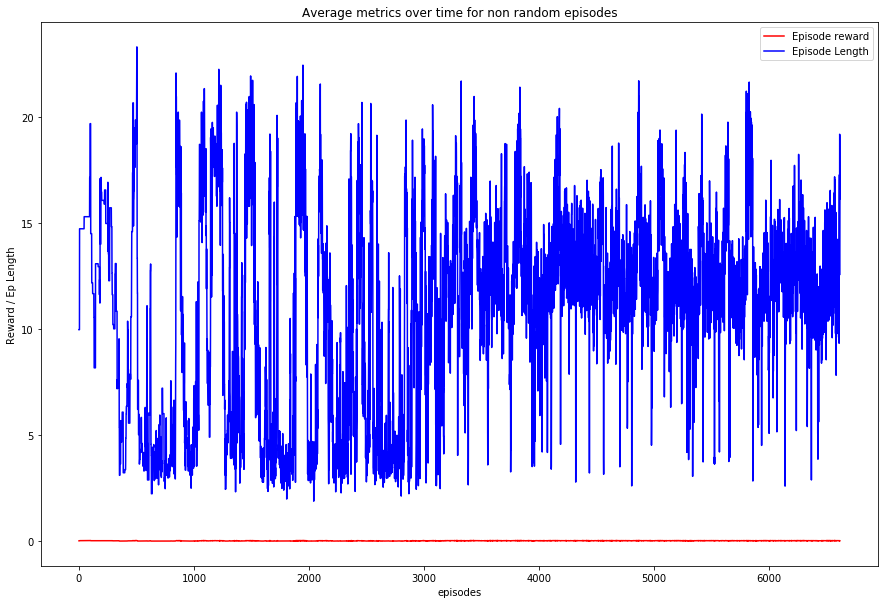

In [13]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(AvgNonRandomrList)), AvgNonRandomrList, color='red', label='Episode reward')
plt.plot(range(len(AvgNonRandomsTimeList)), AvgNonRandomsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time for non random episodes')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best');

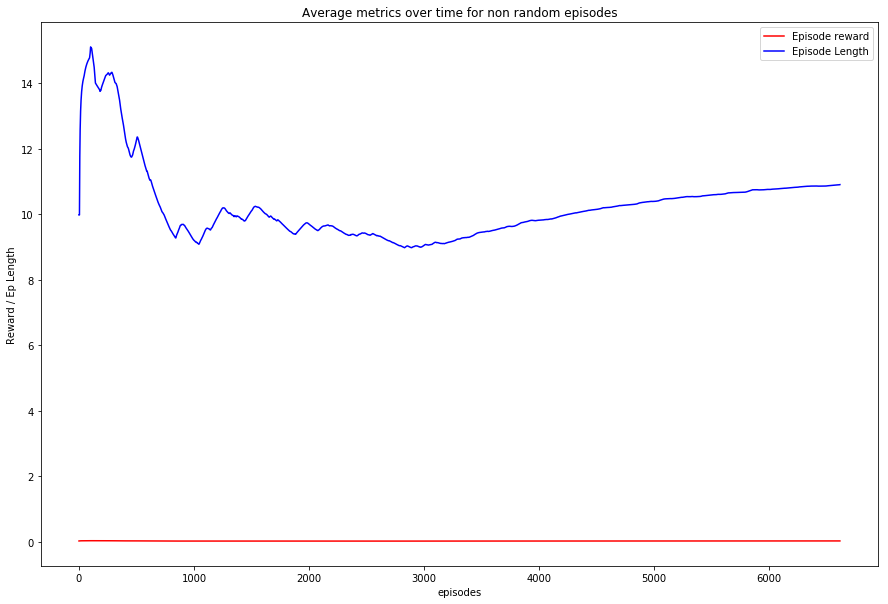

In [14]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(AvgNonRandomrListMA)), AvgNonRandomrListMA, color='red', label='Episode reward')
plt.plot(range(len(AvgNonRandomsTimeListMA)), AvgNonRandomsTimeListMA, color='blue', label='Episode Length')
plt.title('Average metrics over time for non random episodes')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best');

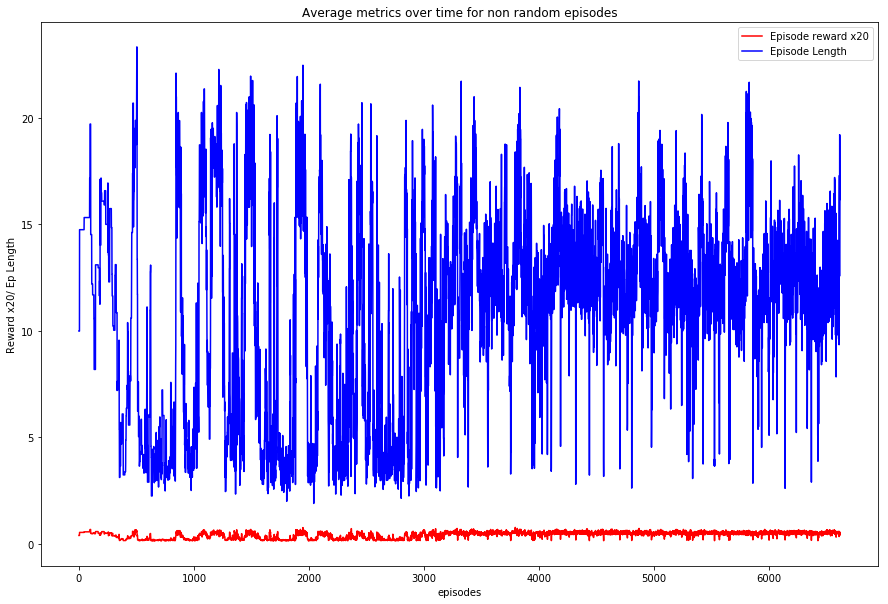

In [15]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(AvgNonRandomrList)), np.array(AvgNonRandomrList)*20, color='red', label='Episode reward x20')
plt.plot(range(len(AvgNonRandomsTimeList)), AvgNonRandomsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time for non random episodes')
plt.xlabel('episodes')
plt.ylabel('Reward x20/ Ep Length')
plt.legend(loc='best');

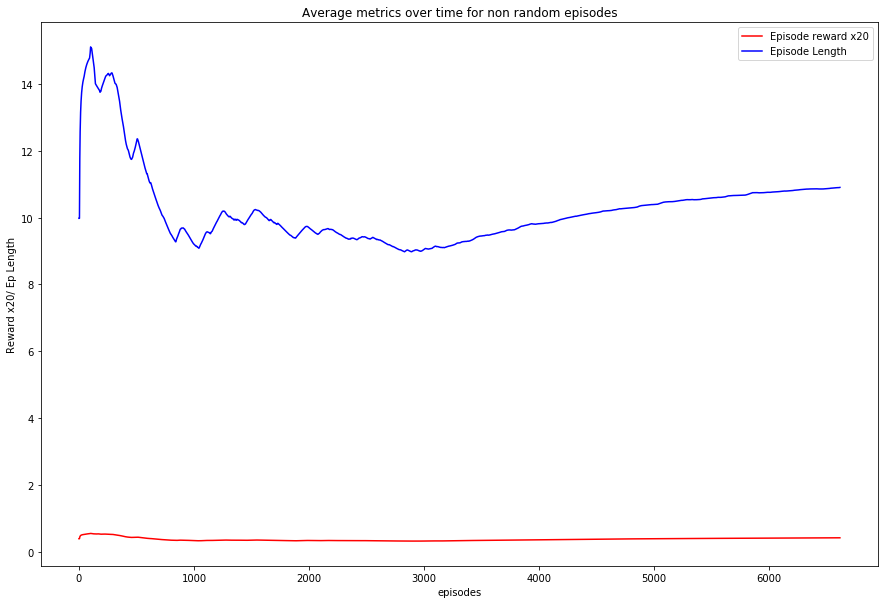

In [16]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(AvgNonRandomrListMA)), np.array(AvgNonRandomrListMA)*20, color='red', label='Episode reward x20')
plt.plot(range(len(AvgNonRandomsTimeListMA)), AvgNonRandomsTimeListMA, color='blue', label='Episode Length')
plt.title('Average metrics over time for non random episodes')
plt.xlabel('episodes')
plt.ylabel('Reward x20/ Ep Length')
plt.legend(loc='best');

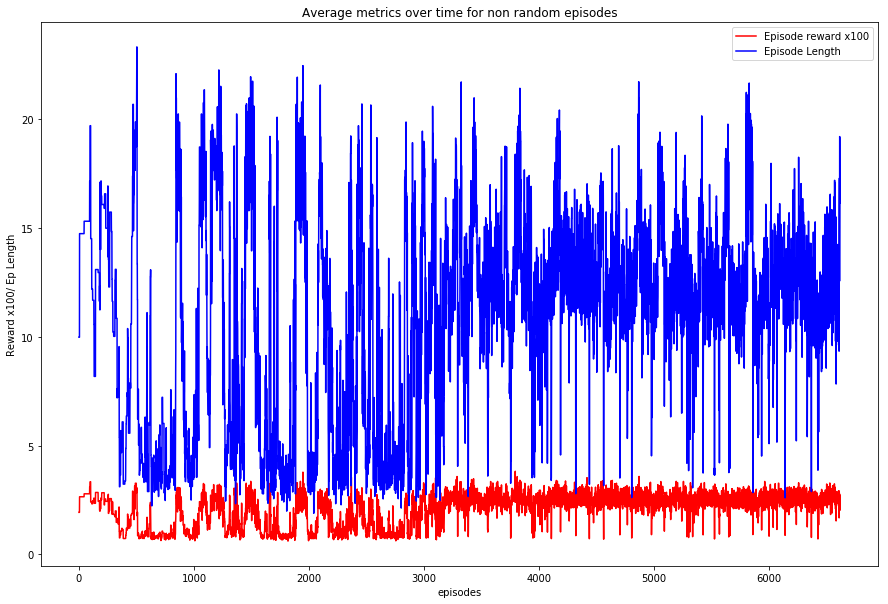

In [17]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(AvgNonRandomrList)), np.array(AvgNonRandomrList)*100, color='red', label='Episode reward x100')
plt.plot(range(len(AvgNonRandomsTimeList)), AvgNonRandomsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time for non random episodes')
plt.xlabel('episodes')
plt.ylabel('Reward x100/ Ep Length')
plt.legend(loc='best');

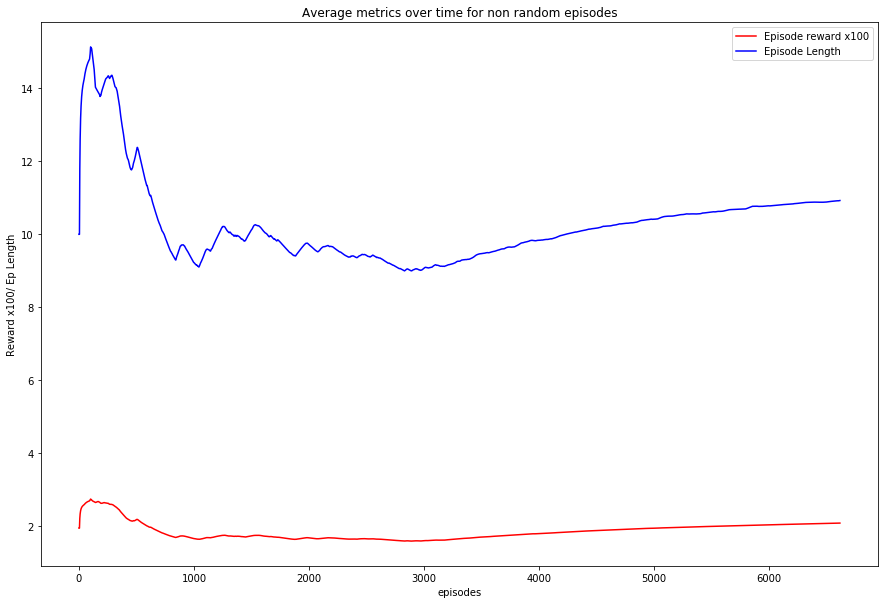

In [18]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(AvgNonRandomrListMA)), np.array(AvgNonRandomrListMA)*100, color='red', label='Episode reward x100')
plt.plot(range(len(AvgNonRandomsTimeListMA)), AvgNonRandomsTimeListMA, color='blue', label='Episode Length')
plt.title('Average metrics over time for non random episodes')
plt.xlabel('episodes')
plt.ylabel('Reward x100/ Ep Length')
plt.legend(loc='best');

# per epoch

In [19]:
AvgrListMAEpoch = movingaverage(AvgrListEpoch)

AvgsTimeListMAEpoch = movingaverage(AvgsTimeListEpoch)

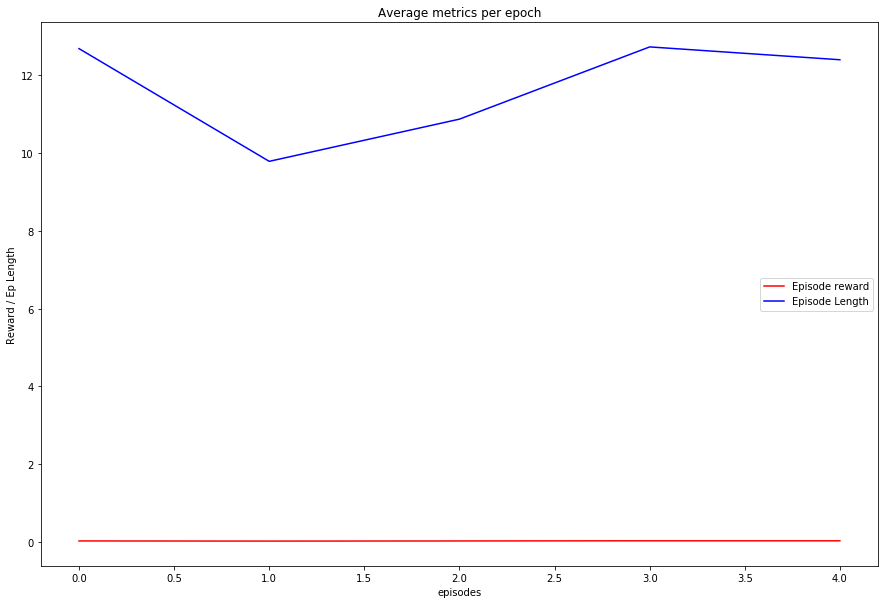

In [20]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(AvgrListEpoch)), AvgrListEpoch, color='red', label='Episode reward')
plt.plot(range(len(AvgsTimeListEpoch)), AvgsTimeListEpoch, color='blue', label='Episode Length')
plt.title('Average metrics per epoch')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best');

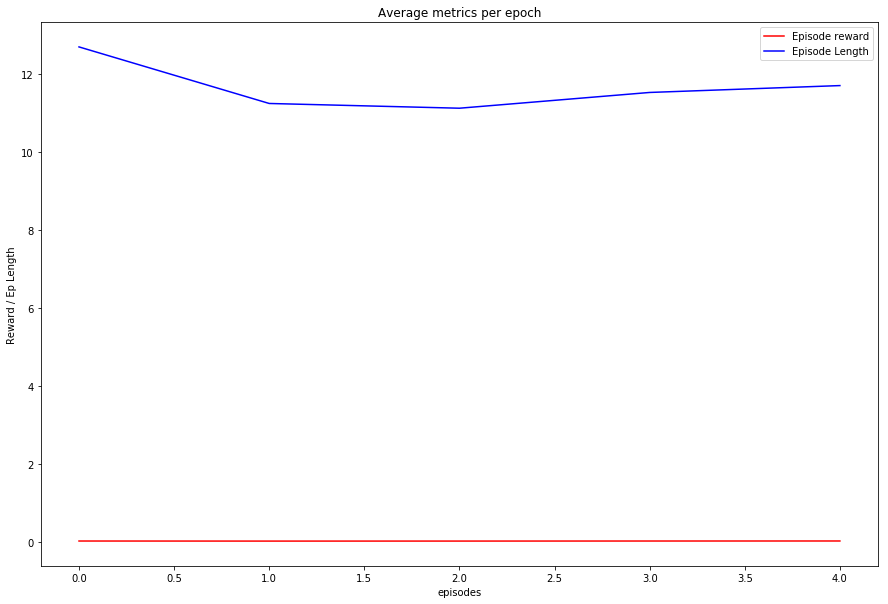

In [21]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(AvgrListMAEpoch)), AvgrListMAEpoch, color='red', label='Episode reward')
plt.plot(range(len(AvgsTimeListMAEpoch)), AvgsTimeListMAEpoch, color='blue', label='Episode Length')
plt.title('Average metrics per epoch')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best');

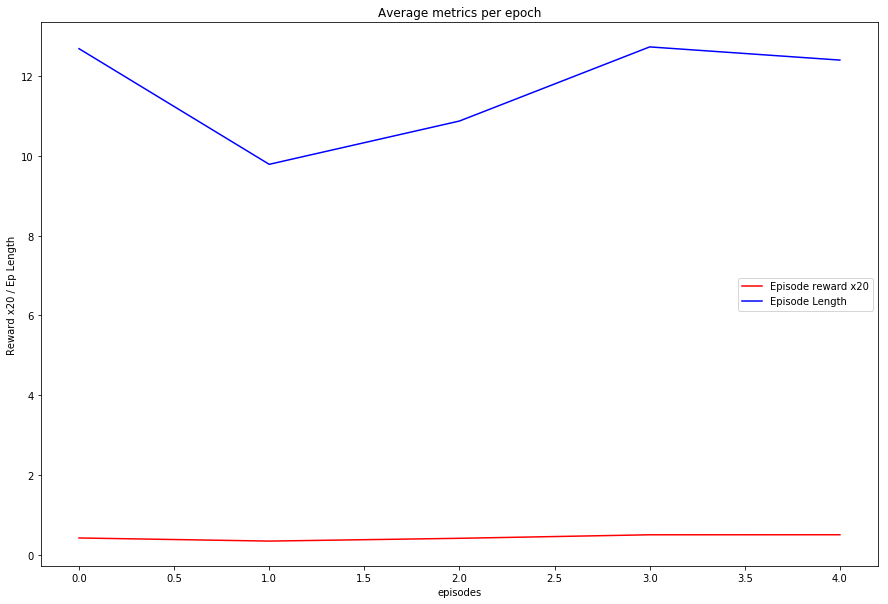

In [22]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(AvgrListEpoch)), np.array(AvgrListEpoch)*20, color='red', label='Episode reward x20')
plt.plot(range(len(AvgsTimeListEpoch)), AvgsTimeListEpoch, color='blue', label='Episode Length')
plt.title('Average metrics per epoch')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best');

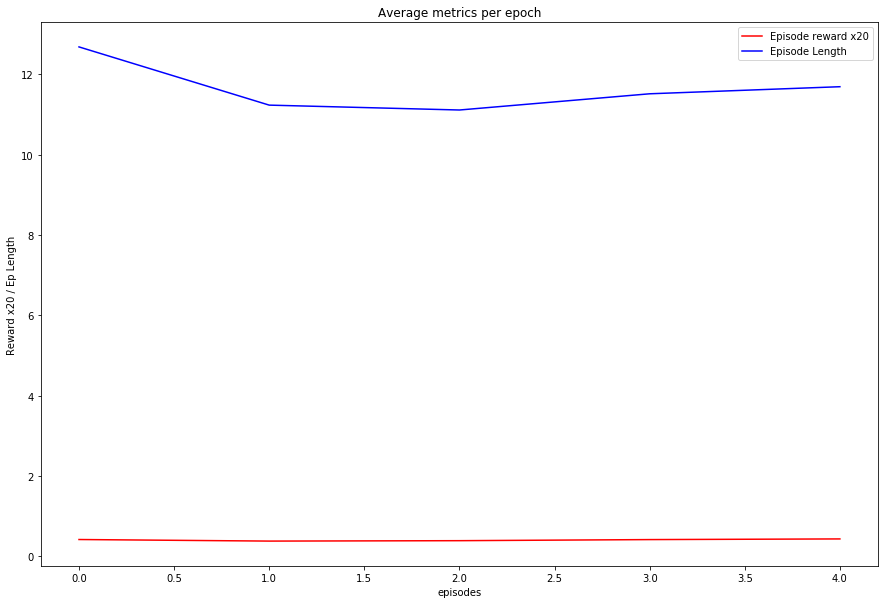

In [23]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(AvgrListMAEpoch)), np.array(AvgrListMAEpoch)*20, color='red', label='Episode reward x20')
plt.plot(range(len(AvgsTimeListMAEpoch)), AvgsTimeListMAEpoch, color='blue', label='Episode Length')
plt.title('Average metrics per epoch')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best');

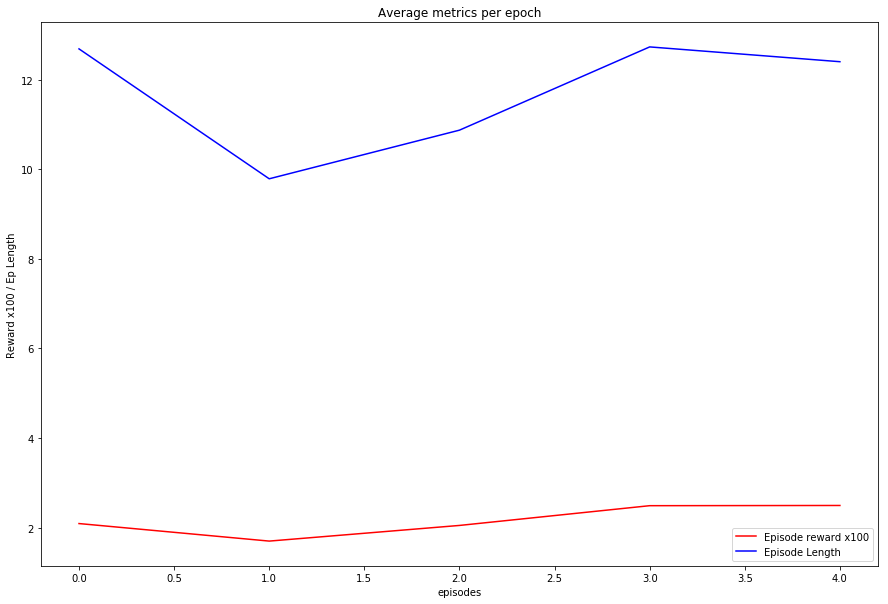

In [24]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
# plt.subplot(1,2,1);
plt.plot(range(len(AvgrListEpoch)), np.array(AvgrListEpoch)*100, color='red', label='Episode reward x100')
plt.plot(range(len(AvgsTimeListEpoch)), AvgsTimeListEpoch, color='blue', label='Episode Length')
plt.title('Average metrics per epoch')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best');

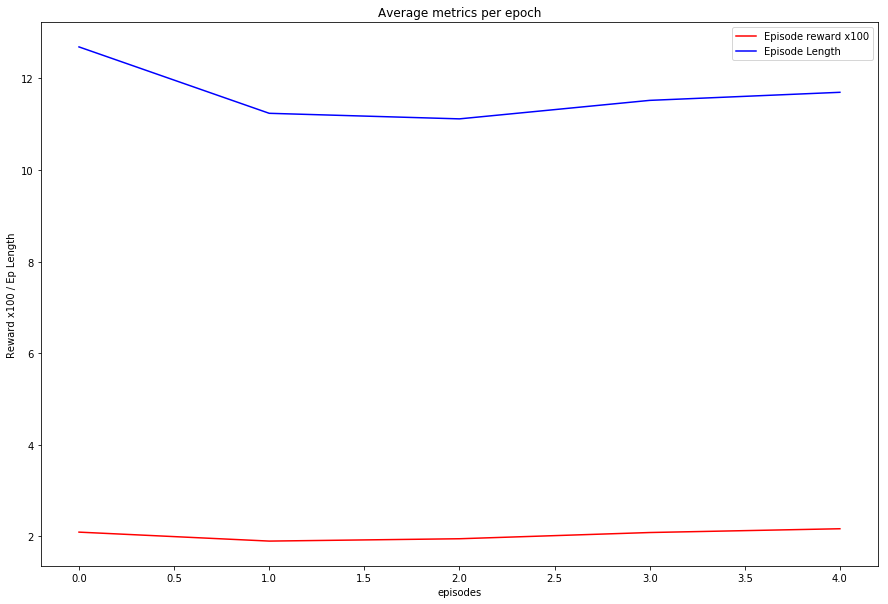

In [25]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
# plt.subplot(1,2,1);
plt.plot(range(len(AvgrListMAEpoch)), np.array(AvgrListMAEpoch)*100, color='red', label='Episode reward x100')
plt.plot(range(len(AvgsTimeListMAEpoch)), AvgsTimeListMAEpoch, color='blue', label='Episode Length')
plt.title('Average metrics per epoch')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best');

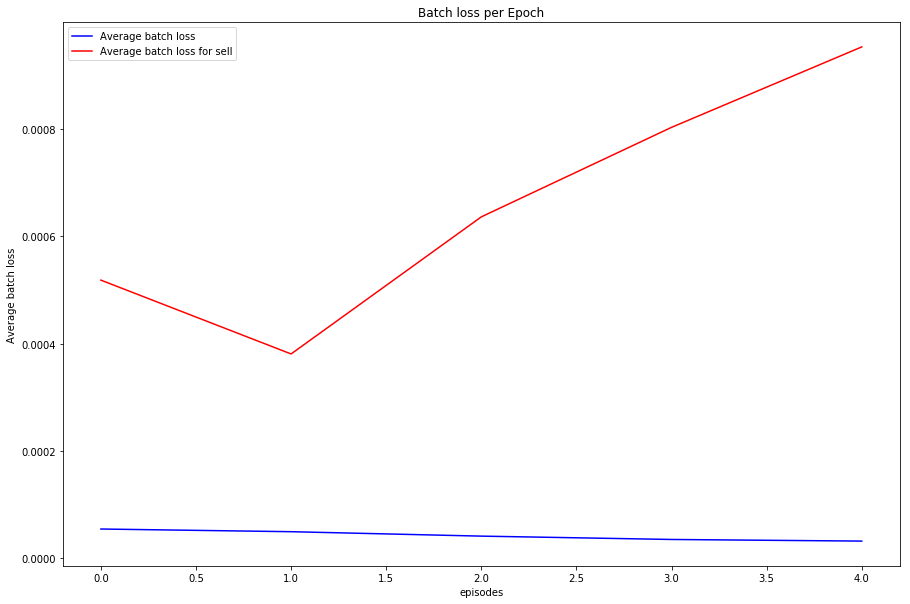

In [26]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(AvgLossListEpoch)), AvgLossListEpoch, color='blue', label='Average batch loss')
plt.plot(range(len(AvgQSellLossListEpoch)), AvgQSellLossListEpoch, color='red', label='Average batch loss for sell')
plt.title('Batch loss per Epoch')
plt.xlabel('episodes')
plt.ylabel('Average batch loss')
plt.legend(loc='best');

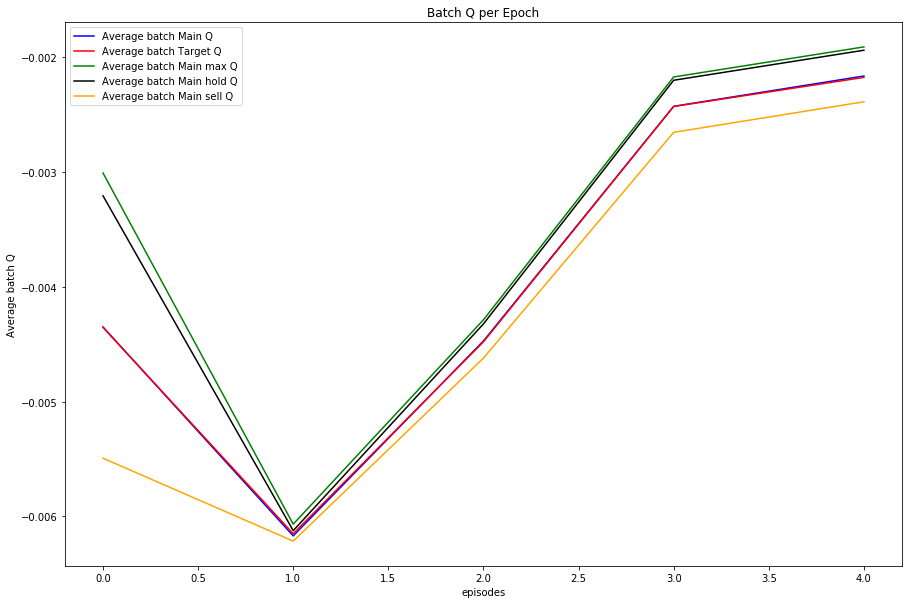

In [27]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(AvgMainQListEpoch)), AvgMainQListEpoch, color='blue', label='Average batch Main Q')
plt.plot(range(len(AvgTargetQListEpoch)), AvgTargetQListEpoch, color='red', label='Average batch Target Q')
plt.plot(range(len(AvgMainMaxQListEpoch)), AvgMainMaxQListEpoch, color='green', label='Average batch Main max Q')
plt.plot(range(len(AvgMainHoldQListEpoch)), AvgMainHoldQListEpoch, color='black', label='Average batch Main hold Q')
plt.plot(range(len(AvgMainSellQListEpoch)), AvgMainSellQListEpoch, color='orange', label='Average batch Main sell Q')
plt.title('Batch Q per Epoch')
plt.xlabel('episodes')
plt.ylabel('Average batch Q')
plt.legend(loc='best');

In [28]:
AvgrListMA = movingaverage(AvgrList)

AvgsTimeListMA = movingaverage(AvgsTimeList)

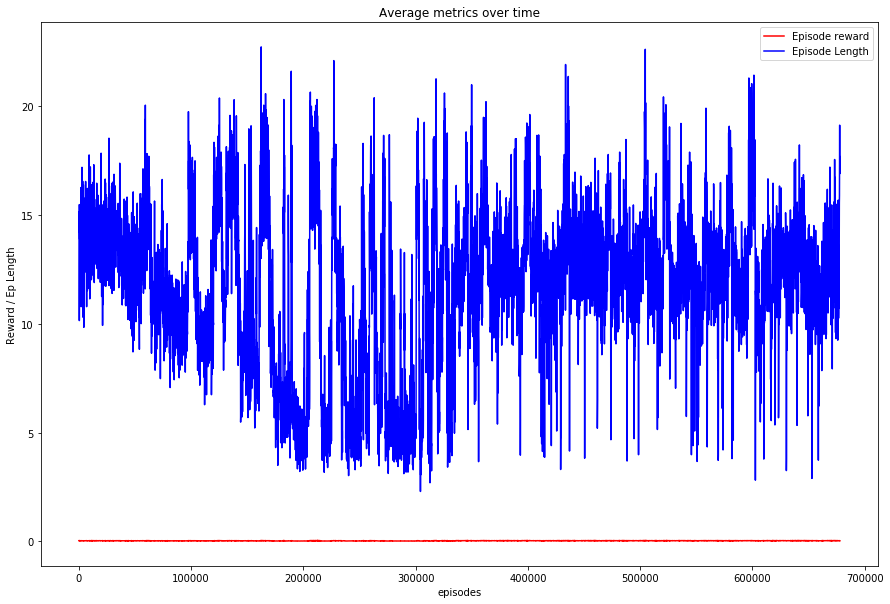

In [29]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best');

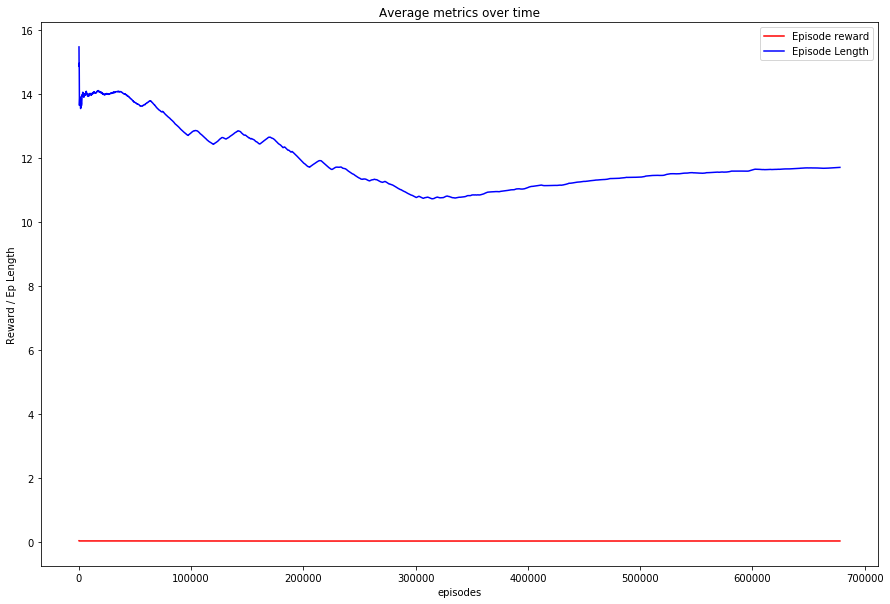

In [30]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrListMA, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeListMA, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best');

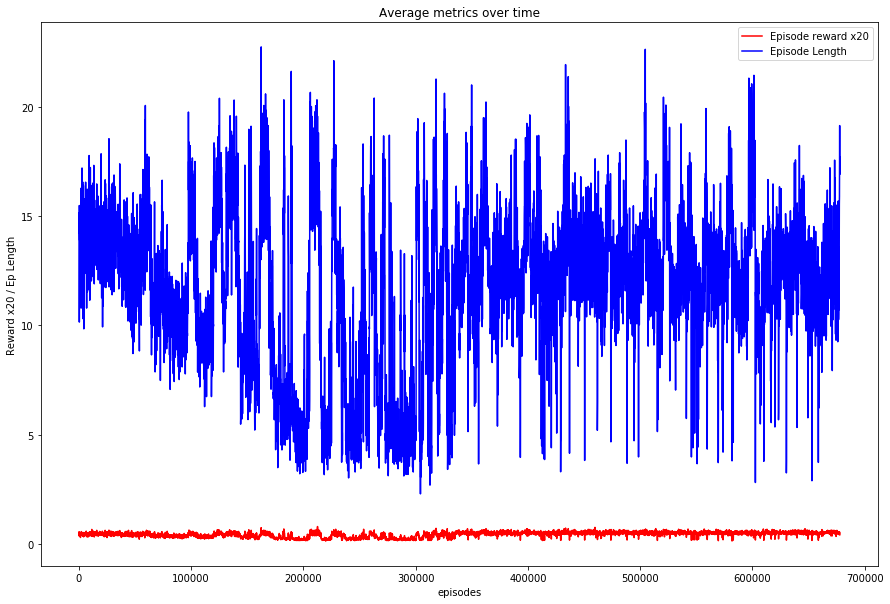

In [31]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best');

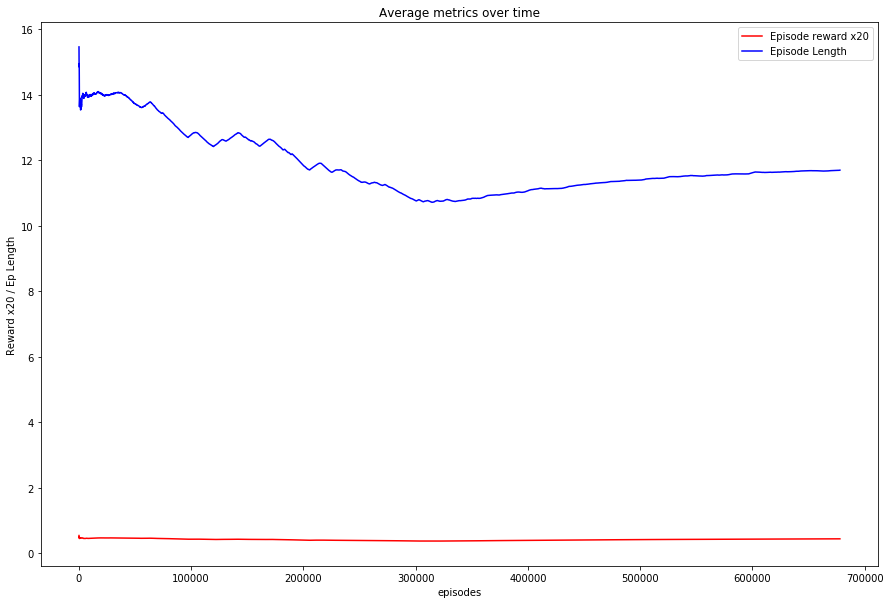

In [32]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrListMA)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeListMA, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best');

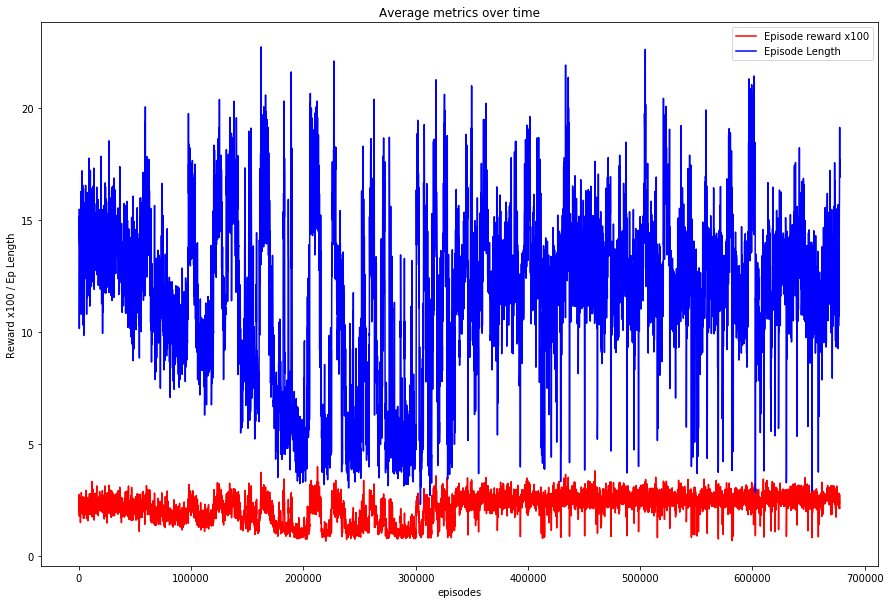

In [33]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
# plt.subplot(1,2,1);
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best');

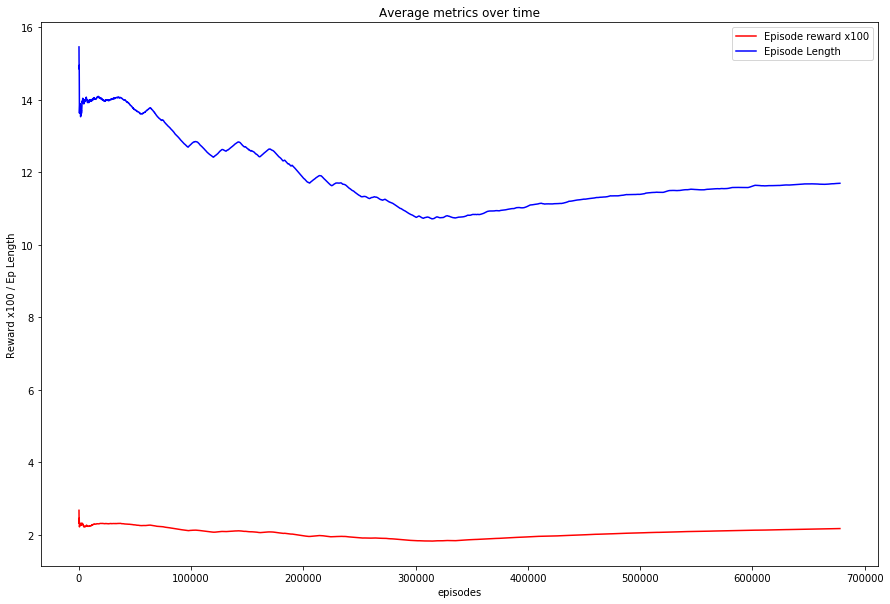

In [34]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
# plt.subplot(1,2,1);
plt.plot(AvgEpisodeList, np.array(AvgrListMA)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeListMA, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best');

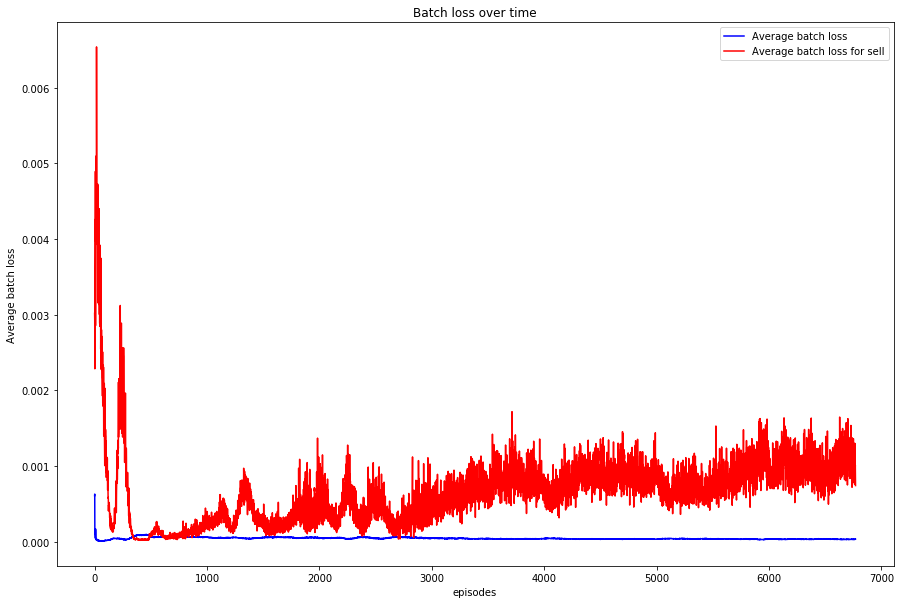

In [35]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(AvgLossList)), AvgLossList, color='blue', label='Average batch loss')
plt.plot(range(len(AvgQSellLossList)), AvgQSellLossList, color='red', label='Average batch loss for sell')
plt.title('Batch loss over time')
plt.xlabel('episodes')
plt.ylabel('Average batch loss')
plt.legend(loc='best');

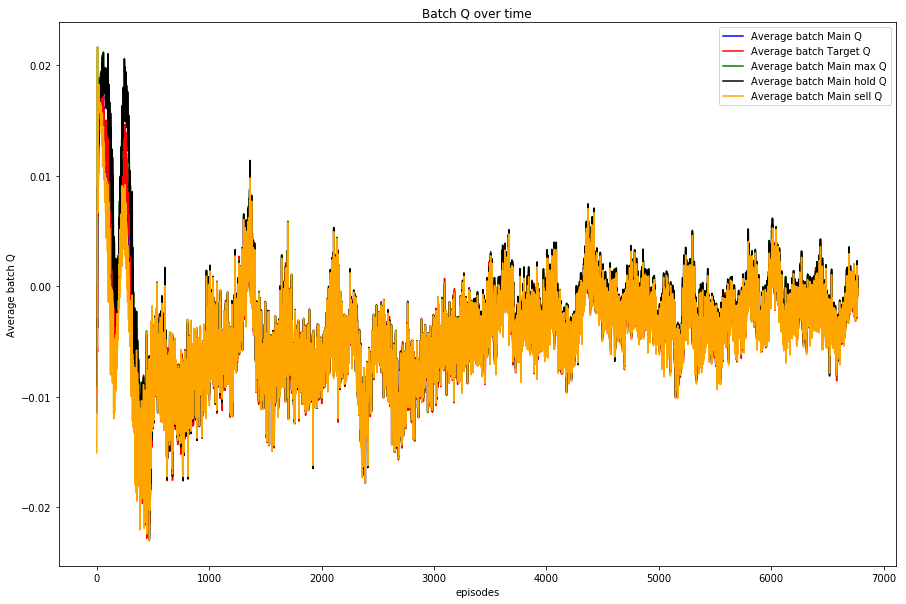

In [36]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(AvgMainQList)), AvgMainQList, color='blue', label='Average batch Main Q')
plt.plot(range(len(AvgTargetQList)), AvgTargetQList, color='red', label='Average batch Target Q')
plt.plot(range(len(AvgMainMaxQList)), AvgMainMaxQList, color='green', label='Average batch Main max Q')
plt.plot(range(len(AvgMainHoldQList)), AvgMainHoldQList, color='black', label='Average batch Main hold Q')
plt.plot(range(len(AvgMainSellQList)), AvgMainSellQList, color='orange', label='Average batch Main sell Q')
plt.title('Batch Q over time')
plt.xlabel('episodes')
plt.ylabel('Average batch Q')
plt.legend(loc='best');

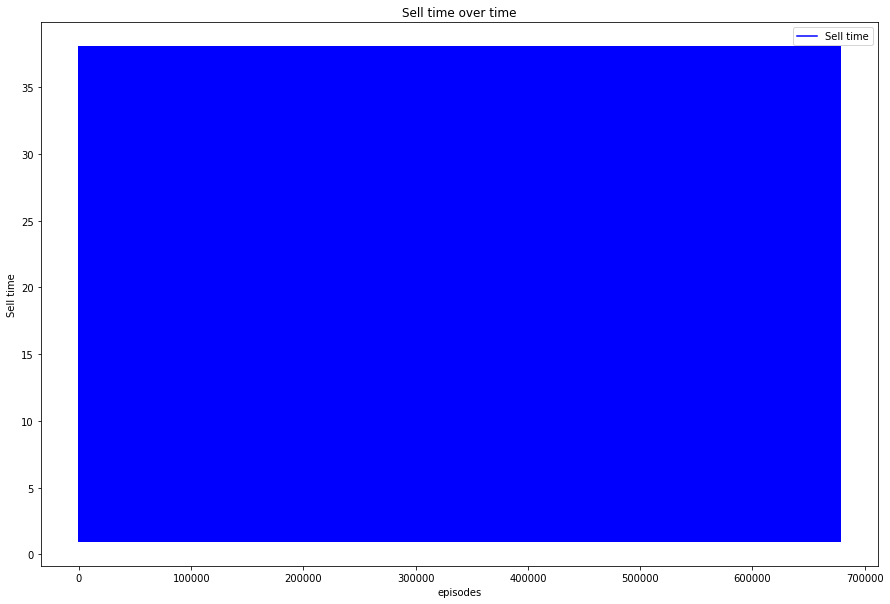

In [37]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

In [38]:
sTimeListMA = movingaverage(sTimeList)

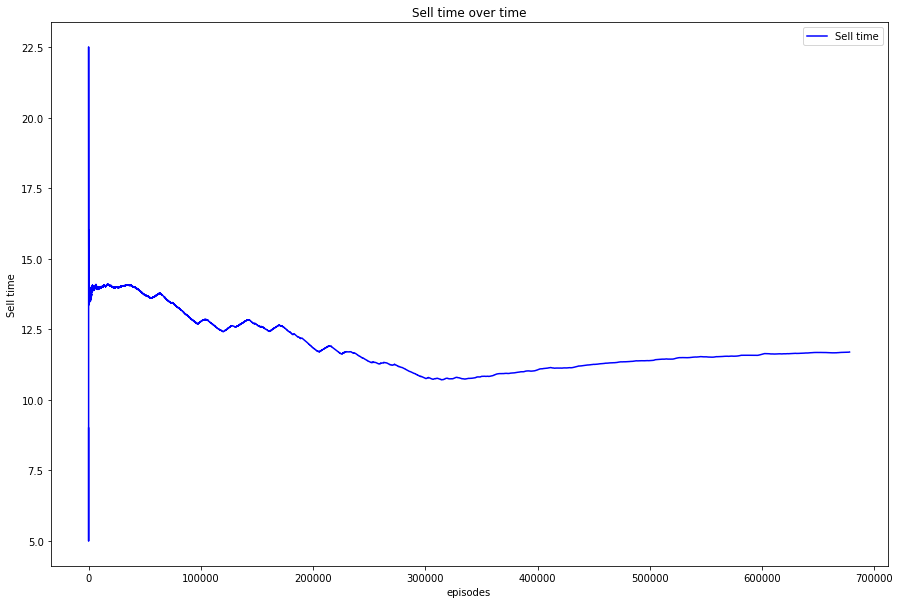

In [39]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeListMA)), sTimeListMA, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

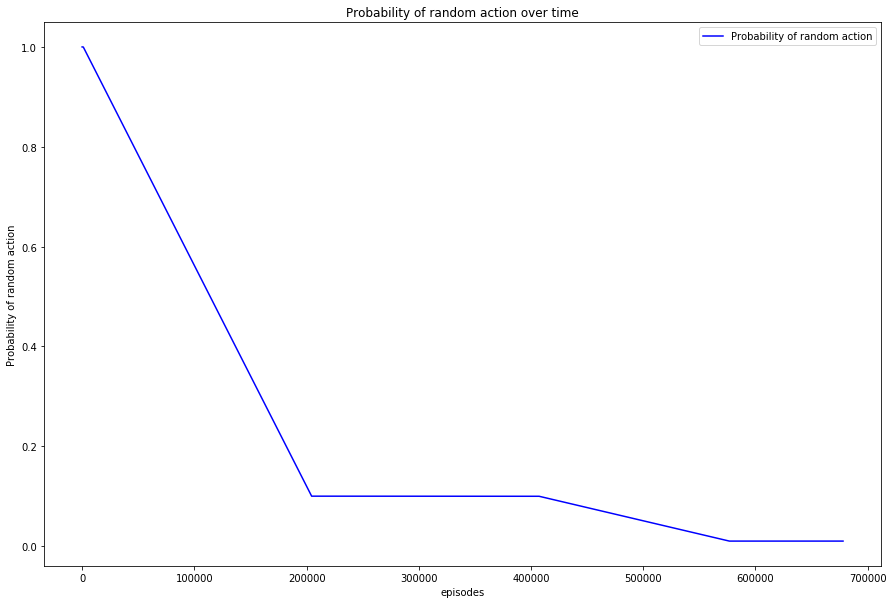

In [40]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(num_episodes), eList, color='blue', label='Probability of random action')
plt.title('Probability of random action over time')
plt.xlabel('episodes')
plt.ylabel('Probability of random action')
plt.legend(loc='best');

### Testing the network on train set again

In [41]:
load_model = True #Whether to load a saved model.
is_training = False

###############################
option_T: 50
history_t: 15
build_warm_up_state_t: 12
###############################
num_batch_episodes_per_epoch: 1059
num_episodes_per_epoch: 135600
min value of stock: 125.64229401508895, max value of stock: 175.81496892998706


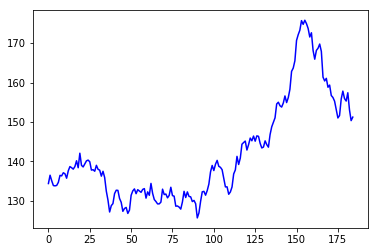

In [42]:
env = StockEnv(stocks_train_data, real_stocks_train_data, risk_free_rate, history_t=history_t, option_T=option_T)
num_batch_episodes_per_epoch = env.get_total_num_episodes_per_epoch() // batch_size
num_episodes = env.get_total_num_episodes_per_epoch()
print('num_batch_episodes_per_epoch: ' + str(num_batch_episodes_per_epoch))
print('num_episodes_per_epoch: ' + str(env.get_total_num_episodes_per_epoch()))
print('min value of stock: '+str(min(test_data)) + ', max value of stock: '+str(max(test_data)))
plt.plot(range(len(test_data)), test_data, color='b')

In [43]:
begin_time = time.time()
tf.reset_default_graph()

mainQN = Qnetwork('main')
targetQN = Qnetwork('target')


init = tf.global_variables_initializer()

saver = tf.train.Saver(max_to_keep=2)

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path) 
  

with tf.Session() as sess, tf.device('/gpu:0'):
    set_seed(seed)
    if load_model == True:
        print ('Loading Model...')
        saver.restore(sess,final_trained_model_name)
    else:
        sess.run(init)
    
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        #Reset the recurrent layer's hidden state
        state = np.zeros((num_layers, 2, 1, h_size))
        while j < max_epLength: 

            if j == max_epLength - 1 and env.is_episode_finished() == False:
                a = 1
            else:
                a, state1 = sess.run([mainQN.predict,mainQN.rnn_state],\
                        feed_dict={mainQN.scalarInput:[s],mainQN.trainLength:1,mainQN.state_in:state,mainQN.batch_size:1})
                if env.get_time() < build_warm_up_state_t:
                    a = 0 #hold
                elif env.get_payoff() <= 0:
                    a = 0 #hold
                else:
                    a = a[0]
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)
            
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            state = state1
            j+=1 # episode length till selling or reaching last day of option

            if env.is_episode_finished():
                break
        
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)

        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT))
            
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

totalAveragerewardPerEpisode = np.mean(rList)
maxPossibleAveragerewardPerEpisode = np.mean(maxPossiblerList)
CI90 = env.getConfidenceInterval(rList)
CI95 = env.getConfidenceInterval95(rList)
sEntropy = env.getEntropy(sTimeList)
percentageStockReturnNormalized = np.mean(percentage_rList)
percentageStockReturnReal = np.mean(real_percentage_rList)
percentageOptionReturnNormalized = np.mean(option_percentage_rList)
percentageOptionReturnReal = np.mean(option_real_percentage_rList)
maxPossibleAverageStockPercentageReturnPerEpisode = np.mean(maxPossibleP_returnList)
maxPossibleAverageRealStockPercentageReturnPerEpisode = np.mean(maxPossibleR_P_returnList)
maxPossibleAverageOptionPercentageReturnPerEpisode = np.mean(maxPossibleOptionP_returnList)
maxPossibleAverageRealOptionPercentageReturnPerEpisode = np.mean(maxPossibleOptionR_P_returnList)
CIPercentageReturnNormalized90 = env.getConfidenceInterval(percentage_rList)
CIPercentageReturnNormalized95 = env.getConfidenceInterval95(percentage_rList)
CIPercentageReturnReal90 = env.getConfidenceInterval(real_percentage_rList)
CIPercentageReturnReal95 = env.getConfidenceInterval95(real_percentage_rList)
CIPercentageOptionReturnNormalized90 = env.getConfidenceInterval(option_percentage_rList)
CIPercentageOptionReturnNormalized95 = env.getConfidenceInterval95(option_percentage_rList)
CIPercentageOptionReturnReal90 = env.getConfidenceInterval(option_real_percentage_rList)
CIPercentageOptionReturnReal95 = env.getConfidenceInterval95(option_real_percentage_rList)
print ("#Total average reward per episode: " + str(totalAveragerewardPerEpisode))

print ("#Max possible average reward per episode: " + str(maxPossibleAveragerewardPerEpisode))

print ("#Confidence Interval with prob of 90%: " + str(CI90))

print ("#Confidence Interval with prob of 95%: " + str(CI95))

print ("#Sell time entropy: " + str(sEntropy))

print ("#Percentage of stock returns (Normalized): " + str(percentageStockReturnNormalized))

print ("#Percentage of stock returns (Real values): " + str(percentageStockReturnReal))

print ("#Percentage of option returns (Normalized): " + str(percentageOptionReturnNormalized))

print ("#Percentage of option returns (Real values): " + str(percentageOptionReturnReal))

print ("#Max possible average stock percentage return per episode: " + str(maxPossibleAverageStockPercentageReturnPerEpisode))

print ("#Max possible average real stock percentage return per episode: " + str(maxPossibleAverageRealStockPercentageReturnPerEpisode))

print ("#Max possible average option percentage return per episode: " + str(maxPossibleAverageOptionPercentageReturnPerEpisode))

print ("#Max possible average real option percentage return per episode: " + str(maxPossibleAverageRealOptionPercentageReturnPerEpisode))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(CIPercentageReturnNormalized90))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(CIPercentageReturnNormalized95))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(CIPercentageReturnReal90))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(CIPercentageReturnReal95))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(CIPercentageOptionReturnNormalized90))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(CIPercentageOptionReturnNormalized95))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(CIPercentageOptionReturnReal90))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(CIPercentageOptionReturnReal95))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

Loading Model...
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from C:\Code_RL\normalizeFirstDay_seed_corrected_2019_11_21_shuffled_GBM_version\savedModel\RL_10000rep_200seeds_0001_128batch_1000pre_arch0-option_T50-history_t15-dueling_typemax-freq300-batch128-capacity10000-lambda0.0001-final
episode 100: 	0.02813575979990438	18.39
episode 200: 	0.022062712796485032	16.91
episode 300: 	0.03088376802062246	20.61
episode 400: 	0.02075722730685129	12.84
episode 500: 	0.02205401839476687	16.91
episode 600: 	0.022688401663200887	16.54
episode 700: 	0.02692696176328535	19.87
episode 800: 	0.020520776427347	16.17
episode 900: 	0.025666530813166038	16.91
episode 1000: 	0.021738651719367917	16.54
episode 1100: 	0.026808176052556632	17.65
episode 1200: 	0.024085930787757358	16.91
episode 1300: 	0.027126212462697977	19.87
episode 1400: 	0.024899601762166542	17.65
episode 1500: 	0.03065870186008722	17.28
episode 1600: 	0.

episode 17900: 	0.03180114273938327	18.76
episode 18000: 	0.03003463917040921	19.13
episode 18100: 	0.02582557830578032	16.91
episode 18200: 	0.0259426552943841	16.17
episode 18300: 	0.030685175340555176	19.5
episode 18400: 	0.03015966295611998	18.39
episode 18500: 	0.03269309510155087	21.35
episode 18600: 	0.027090573348438816	18.39
episode 18700: 	0.022445586234523	15.43
episode 18800: 	0.02001532168411817	14.69
episode 18900: 	0.03182878422495767	18.76
episode 19000: 	0.02286472409899483	16.91
episode 19100: 	0.023706893468561172	16.55
episode 19200: 	0.0271200544627938	19.13
episode 19300: 	0.023681792832185897	18.02
episode 19400: 	0.030542608414458917	18.76
episode 19500: 	0.028818133521638485	18.39
episode 19600: 	0.026999588932316042	18.39
episode 19700: 	0.028713877405502714	18.39
episode 19800: 	0.026438851880920367	20.61
episode 19900: 	0.02364606475365097	18.39
episode 20000: 	0.023704767720242402	18.39
#Average reward per episode 20000: 0.026212122131638524
episode 20100: 

episode 36700: 	0.025061422765993012	18.02
episode 36800: 	0.026806756281704702	18.76
episode 36900: 	0.027559682962301765	19.14
episode 37000: 	0.03305208085008318	20.24
episode 37100: 	0.025594262122653366	18.42
episode 37200: 	0.022591775772351073	13.58
episode 37300: 	0.02777818833359455	17.65
episode 37400: 	0.024679808735918348	17.65
episode 37500: 	0.025802293609160695	18.02
episode 37600: 	0.02097189071519745	16.17
episode 37700: 	0.02688264139634986	18.76
episode 37800: 	0.025539861415586094	19.5
episode 37900: 	0.018637780616166767	16.17
episode 38000: 	0.02720247342866914	19.5
episode 38100: 	0.022831303363139006	18.02
episode 38200: 	0.024525028527470388	16.91
episode 38300: 	0.020337962529798723	17.65
episode 38400: 	0.02232647821947358	19.5
episode 38500: 	0.02239573828583351	16.91
episode 38600: 	0.024788160832090806	16.91
episode 38700: 	0.027613858165487993	19.87
episode 38800: 	0.028674826328016687	18.76
episode 38900: 	0.02745515540653111	16.91
episode 39000: 	0.0229

episode 55500: 	0.02141856892683097	16.17
episode 55600: 	0.024543159438817977	18.76
episode 55700: 	0.022905991086114918	16.17
episode 55800: 	0.02799242453408993	17.65
episode 55900: 	0.02706760803991064	18.39
episode 56000: 	0.026595217159702617	20.98
episode 56100: 	0.029493939257858946	18.02
episode 56200: 	0.027672891753911112	20.61
episode 56300: 	0.016489721406375918	15.43
episode 56400: 	0.024689069963977947	15.8
episode 56500: 	0.026701837186801886	18.02
episode 56600: 	0.02830611015174007	20.24
episode 56700: 	0.028217121367442213	18.39
episode 56800: 	0.02397213653679683	14.69
episode 56900: 	0.020103491295440173	13.58
episode 57000: 	0.03256069786724642	19.87
episode 57100: 	0.03205456727431184	20.98
episode 57200: 	0.025721046134094806	20.24
episode 57300: 	0.026104507773260042	18.39
episode 57400: 	0.023814619466103214	18.39
episode 57500: 	0.025925457178584844	16.17
episode 57600: 	0.02225186297584667	15.8
episode 57700: 	0.024062969846602594	18.39
episode 57800: 	0.029

episode 74500: 	0.02913804334064511	19.87
episode 74600: 	0.018873676431012235	13.95
episode 74700: 	0.03308136615496129	20.24
episode 74800: 	0.02193837147107476	14.69
episode 74900: 	0.024034901476842084	16.91
episode 75000: 	0.03153519057529675	21.35
#Average reward per episode 75000: 0.02629611159947058
episode 75100: 	0.03212767714312301	18.02
episode 75200: 	0.02319672145943622	16.91
episode 75300: 	0.025535490895782668	19.87
episode 75400: 	0.030121372070684257	20.98
episode 75500: 	0.025526660765778985	18.76
episode 75600: 	0.024615704208874	18.39
episode 75700: 	0.019993432427102366	16.91
episode 75800: 	0.027752827334609556	16.91
episode 75900: 	0.02601479275779099	17.28
episode 76000: 	0.027398874912395496	17.65
episode 76100: 	0.02647784258571386	18.02
episode 76200: 	0.021958000878948204	15.43
episode 76300: 	0.02479960477788748	17.65
episode 76400: 	0.027162370031520392	19.5
episode 76500: 	0.03302668848260965	20.61
episode 76600: 	0.020642299096963416	15.43
episode 76700

episode 93300: 	0.0243847880123504	19.5
episode 93400: 	0.023644404351982628	15.43
episode 93500: 	0.02479772158039002	16.91
episode 93600: 	0.019152899619511915	16.54
episode 93700: 	0.028793796783572044	19.13
episode 93800: 	0.03759736001670945	20.61
episode 93900: 	0.02395815953882964	16.91
episode 94000: 	0.026080374238580024	18.39
episode 94100: 	0.02478994797674689	16.17
episode 94200: 	0.02475725589390311	18.39
episode 94300: 	0.027499475744971923	17.66
episode 94400: 	0.020686942010898095	15.43
episode 94500: 	0.03142439039812695	19.5
episode 94600: 	0.026922609157902476	18.76
episode 94700: 	0.02723530819542305	19.5
episode 94800: 	0.028992566231878455	17.28
episode 94900: 	0.02019273891943293	16.91
episode 95000: 	0.0235087786593957	17.28
#Average reward per episode 95000: 0.026264341808597925
episode 95100: 	0.021354507872075476	19.13
episode 95200: 	0.023218242369474663	16.54
episode 95300: 	0.02400144614955093	17.28
episode 95400: 	0.02782000563357513	18.02
episode 95500: 

episode 111800: 	0.021763918372453527	16.91
episode 111900: 	0.022813916755632914	16.91
episode 112000: 	0.019104410299740665	14.32
episode 112100: 	0.019842430886036357	15.43
episode 112200: 	0.033266838481720094	20.61
episode 112300: 	0.03290178782434869	18.39
episode 112400: 	0.0321814429366353	20.61
episode 112500: 	0.023734309236171054	16.91
episode 112600: 	0.025836647555256484	16.91
episode 112700: 	0.022270678450391115	16.54
episode 112800: 	0.02733754538923843	18.39
episode 112900: 	0.027032954303799074	18.76
episode 113000: 	0.02674887565848365	18.39
episode 113100: 	0.03028206895971322	19.13
episode 113200: 	0.028672183088743024	19.5
episode 113300: 	0.025465401215763305	18.39
episode 113400: 	0.027683896064808842	17.28
episode 113500: 	0.0260716426239325	18.39
episode 113600: 	0.025828268703756332	15.8
episode 113700: 	0.028290646814439668	15.43
episode 113800: 	0.019654555762478765	14.32
episode 113900: 	0.0243668832043625	17.28
episode 114000: 	0.03415566988333766	25.05
e

episode 130200: 	0.028453817344270754	18.02
episode 130300: 	0.023000915195786197	19.13
episode 130400: 	0.03036074392361217	21.35
episode 130500: 	0.035501540686579895	22.09
episode 130600: 	0.032213271705770354	19.87
episode 130700: 	0.0335966953026438	21.35
episode 130800: 	0.03196272632211476	19.5
episode 130900: 	0.03232615887148667	23.2
episode 131000: 	0.028832907079385618	20.61
episode 131100: 	0.03068872834549771	19.5
episode 131200: 	0.029388977350570427	20.24
episode 131300: 	0.024256880712824152	18.39
episode 131400: 	0.028570582404442622	19.87
episode 131500: 	0.02523450496376938	19.5
episode 131600: 	0.029290192354805355	20.24
episode 131700: 	0.01814786054409815	13.95
episode 131800: 	0.024617381843487638	20.24
episode 131900: 	0.024633198360053156	18.02
episode 132000: 	0.029685976411291882	20.61
episode 132100: 	0.02658730481636376	17.65
episode 132200: 	0.023521124425856427	18.39
episode 132300: 	0.03084545512264133	20.24
episode 132400: 	0.02356681490626865	16.17
epi

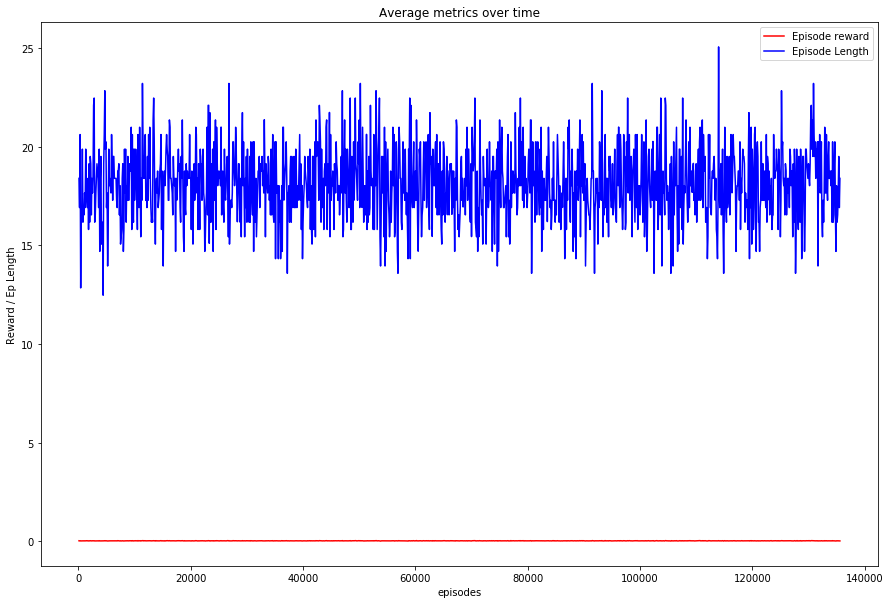

In [45]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best');

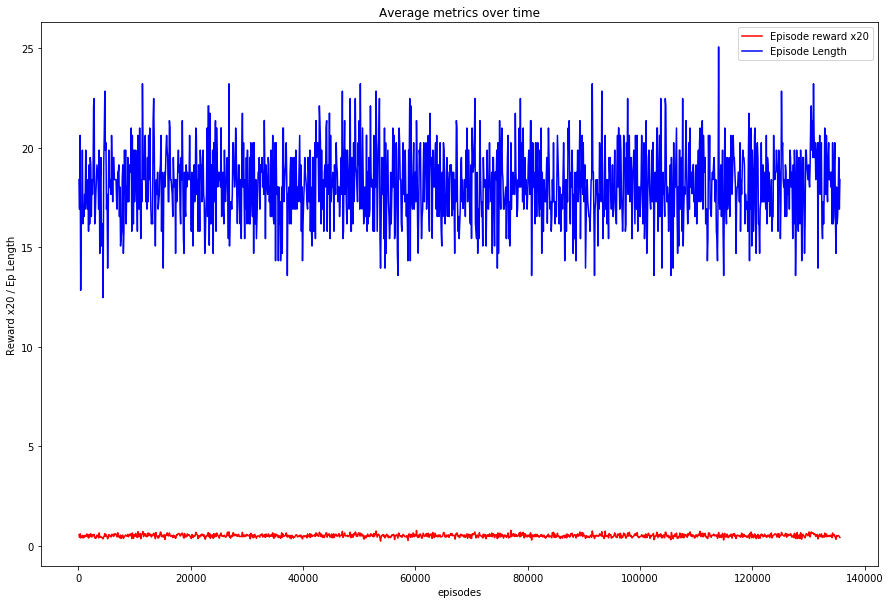

In [46]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best');

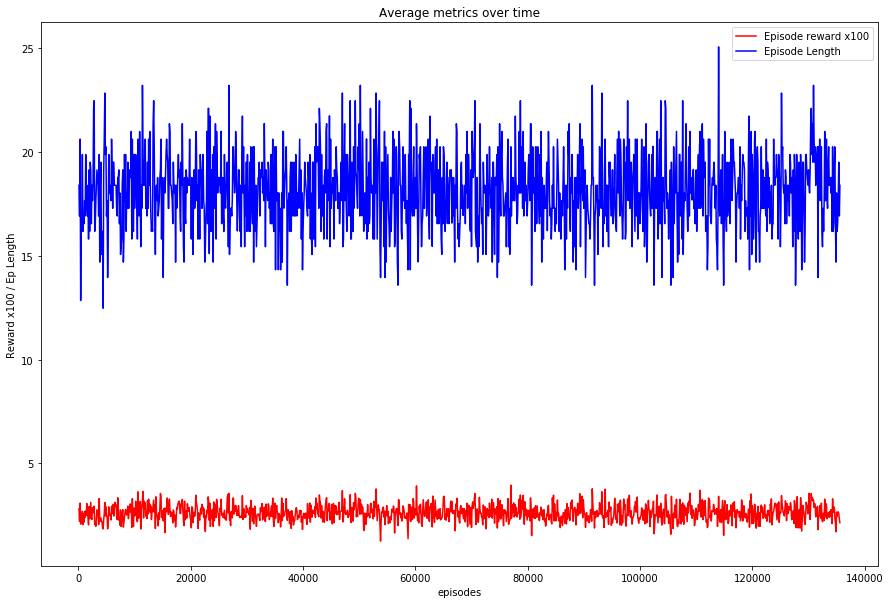

In [47]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best');

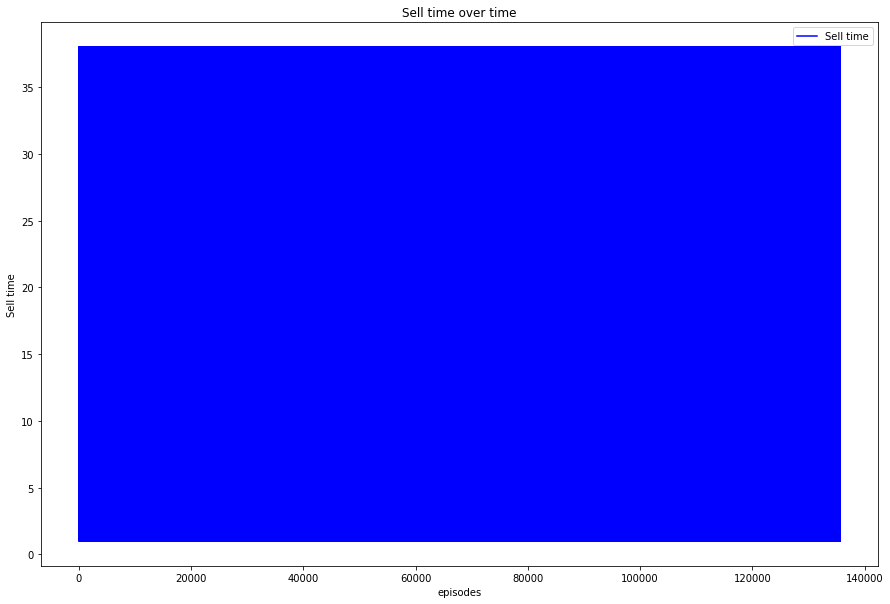

In [48]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

### Testing the network

In [49]:
load_model = True #Whether to load a saved model.
is_training = False

###############################
option_T: 50
history_t: 15
build_warm_up_state_t: 12
###############################
num_batch_episodes_per_epoch: 187
num_episodes_per_epoch: 24000
min value of stock: 125.64229401508895, max value of stock: 175.81496892998706


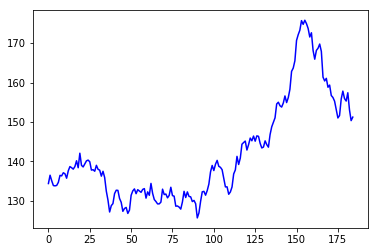

In [50]:
env = StockEnv(stocks_test_data, real_stocks_test_data, risk_free_rate, history_t=history_t, option_T=option_T)
num_batch_episodes_per_epoch = env.get_total_num_episodes_per_epoch() // batch_size
num_episodes = env.get_total_num_episodes_per_epoch()
print('num_batch_episodes_per_epoch: ' + str(num_batch_episodes_per_epoch))
print('num_episodes_per_epoch: ' + str(env.get_total_num_episodes_per_epoch()))
print('min value of stock: '+str(min(test_data)) + ', max value of stock: '+str(max(test_data)))
plt.plot(range(len(test_data)), test_data, color='b')

In [51]:
begin_time = time.time()
tf.reset_default_graph()

mainQN = Qnetwork('main')
targetQN = Qnetwork('target')


init = tf.global_variables_initializer()

saver = tf.train.Saver(max_to_keep=2)

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path) 
  

with tf.Session() as sess, tf.device('/gpu:0'):
    set_seed(seed)
    if load_model == True:
        print ('Loading Model...')
        saver.restore(sess,final_trained_model_name)
    else:
        sess.run(init)
    
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        #Reset the recurrent layer's hidden state
        state = np.zeros((num_layers, 2, 1, h_size))
        while j < max_epLength: 

            if j == max_epLength - 1 and env.is_episode_finished() == False:
                a = 1
            else:
                a, state1 = sess.run([mainQN.predict,mainQN.rnn_state],\
                        feed_dict={mainQN.scalarInput:[s],mainQN.trainLength:1,mainQN.state_in:state,mainQN.batch_size:1})
                if env.get_time() < build_warm_up_state_t:
                    a = 0 #hold
                elif env.get_payoff() <= 0:
                    a = 0 #hold
                else:
                    a = a[0]
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)
            
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            state = state1
            j+=1 # episode length till selling or reaching last day of option

            if env.is_episode_finished():
                break
        
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)

        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT))
            
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

totalAveragerewardPerEpisode = np.mean(rList)
maxPossibleAveragerewardPerEpisode = np.mean(maxPossiblerList)
CI90 = env.getConfidenceInterval(rList)
CI95 = env.getConfidenceInterval95(rList)
sEntropy = env.getEntropy(sTimeList)
percentageStockReturnNormalized = np.mean(percentage_rList)
percentageStockReturnReal = np.mean(real_percentage_rList)
percentageOptionReturnNormalized = np.mean(option_percentage_rList)
percentageOptionReturnReal = np.mean(option_real_percentage_rList)
maxPossibleAverageStockPercentageReturnPerEpisode = np.mean(maxPossibleP_returnList)
maxPossibleAverageRealStockPercentageReturnPerEpisode = np.mean(maxPossibleR_P_returnList)
maxPossibleAverageOptionPercentageReturnPerEpisode = np.mean(maxPossibleOptionP_returnList)
maxPossibleAverageRealOptionPercentageReturnPerEpisode = np.mean(maxPossibleOptionR_P_returnList)
CIPercentageReturnNormalized90 = env.getConfidenceInterval(percentage_rList)
CIPercentageReturnNormalized95 = env.getConfidenceInterval95(percentage_rList)
CIPercentageReturnReal90 = env.getConfidenceInterval(real_percentage_rList)
CIPercentageReturnReal95 = env.getConfidenceInterval95(real_percentage_rList)
CIPercentageOptionReturnNormalized90 = env.getConfidenceInterval(option_percentage_rList)
CIPercentageOptionReturnNormalized95 = env.getConfidenceInterval95(option_percentage_rList)
CIPercentageOptionReturnReal90 = env.getConfidenceInterval(option_real_percentage_rList)
CIPercentageOptionReturnReal95 = env.getConfidenceInterval95(option_real_percentage_rList)
print ("#Total average reward per episode: " + str(totalAveragerewardPerEpisode))

print ("#Max possible average reward per episode: " + str(maxPossibleAveragerewardPerEpisode))

print ("#Confidence Interval with prob of 90%: " + str(CI90))

print ("#Confidence Interval with prob of 95%: " + str(CI95))

print ("#Sell time entropy: " + str(sEntropy))

print ("#Percentage of stock returns (Normalized): " + str(percentageStockReturnNormalized))

print ("#Percentage of stock returns (Real values): " + str(percentageStockReturnReal))

print ("#Percentage of option returns (Normalized): " + str(percentageOptionReturnNormalized))

print ("#Percentage of option returns (Real values): " + str(percentageOptionReturnReal))

print ("#Max possible average stock percentage return per episode: " + str(maxPossibleAverageStockPercentageReturnPerEpisode))

print ("#Max possible average real stock percentage return per episode: " + str(maxPossibleAverageRealStockPercentageReturnPerEpisode))

print ("#Max possible average option percentage return per episode: " + str(maxPossibleAverageOptionPercentageReturnPerEpisode))

print ("#Max possible average real option percentage return per episode: " + str(maxPossibleAverageRealOptionPercentageReturnPerEpisode))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(CIPercentageReturnNormalized90))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(CIPercentageReturnNormalized95))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(CIPercentageReturnReal90))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(CIPercentageReturnReal95))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(CIPercentageOptionReturnNormalized90))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(CIPercentageOptionReturnNormalized95))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(CIPercentageOptionReturnReal90))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(CIPercentageOptionReturnReal95))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

Loading Model...
INFO:tensorflow:Restoring parameters from C:\Code_RL\normalizeFirstDay_seed_corrected_2019_11_21_shuffled_GBM_version\savedModel\RL_10000rep_200seeds_0001_128batch_1000pre_arch0-option_T50-history_t15-dueling_typemax-freq300-batch128-capacity10000-lambda0.0001-final
episode 100: 	0.022581448634089427	18.02
episode 200: 	0.027719879413577512	19.87
episode 300: 	0.03250099220831123	20.98
episode 400: 	0.019850144974786214	16.54
episode 500: 	0.028719157697713594	20.24
episode 600: 	0.02634044992721846	19.5
episode 700: 	0.027122255932833968	18.39
episode 800: 	0.029319615936579738	19.13
episode 900: 	0.03131500109631881	20.24
episode 1000: 	0.021659700352463993	16.91
episode 1100: 	0.03520868645575364	19.5
episode 1200: 	0.025254950387408846	19.87
episode 1300: 	0.02418573369415695	14.69
episode 1400: 	0.02838853686651903	18.39
episode 1500: 	0.035923814660035566	22.09
episode 1600: 	0.02318414687649235	16.91
episode 1700: 	0.023945007020776364	17.28
episode 1800: 	0.023

episode 18600: 	0.023184083914237732	16.55
episode 18700: 	0.03102246757331438	19.13
episode 18800: 	0.02563000298610828	16.91
episode 18900: 	0.02953449921782466	19.13
episode 19000: 	0.02699766805188923	18.02
episode 19100: 	0.03409549260223204	18.76
episode 19200: 	0.02465455002683652	16.54
episode 19300: 	0.02635451163942502	18.76
episode 19400: 	0.028427283953361783	19.13
episode 19500: 	0.029925501356614554	21.35
episode 19600: 	0.027302253634581	16.91
episode 19700: 	0.03774737305785859	22.46
episode 19800: 	0.022896876337669875	17.28
episode 19900: 	0.03209870152517548	20.98
episode 20000: 	0.02652177665015762	18.39
#Average reward per episode 20000: 0.027838199636031704
episode 20100: 	0.02859009308461294	22.09
episode 20200: 	0.02098214369844511	13.95
episode 20300: 	0.030909731824675997	19.87
episode 20400: 	0.024204035178562372	16.91
episode 20500: 	0.0337080594714729	21.72
episode 20600: 	0.024964103525445917	15.8
episode 20700: 	0.03067952377843048	18.02
episode 20800: 	0

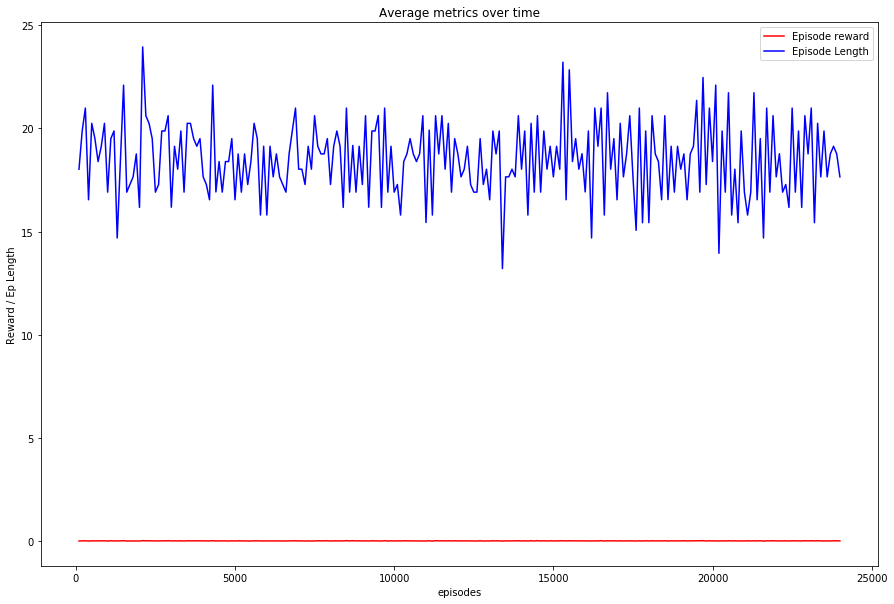

In [53]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best');

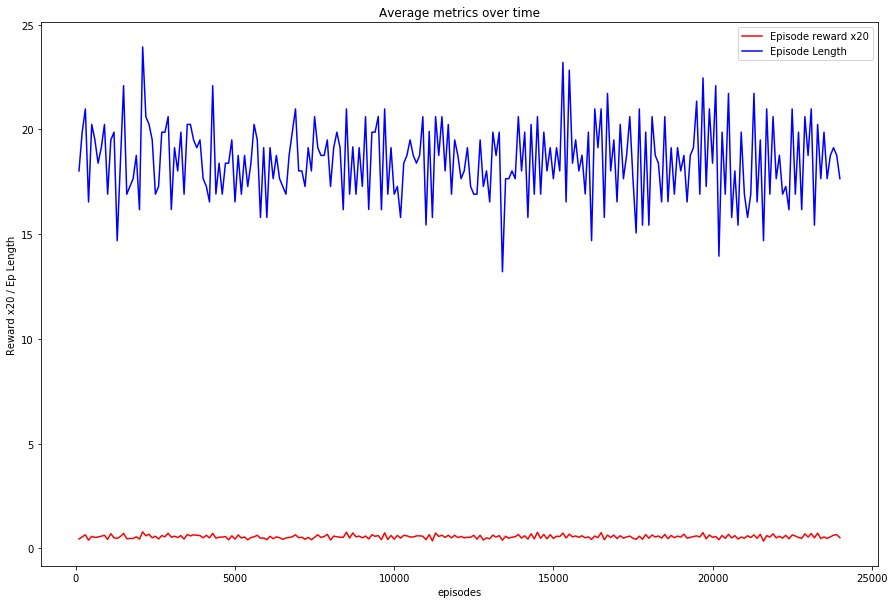

In [54]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best');

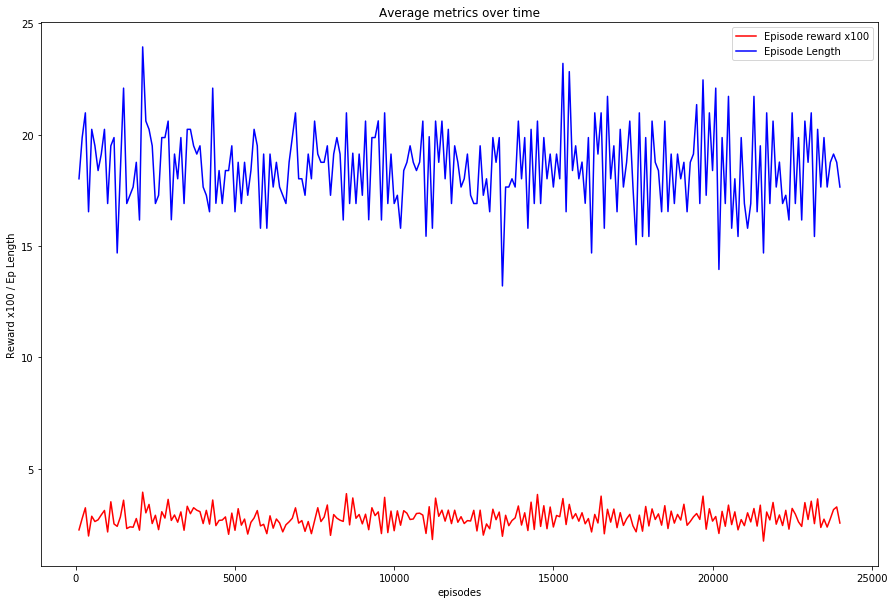

In [55]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best');

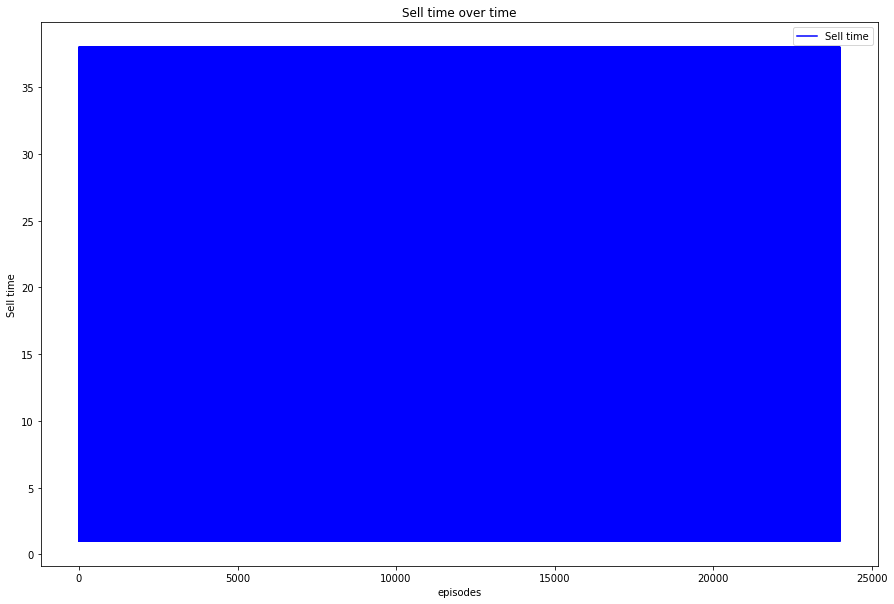

In [56]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Select day of Min price over history [Benchmark]

In [57]:
env.reset_new_test() # reset to first observation in data
begin_time = time.time()

test = 'MinValue' #'Random'

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []
  

with tf.Session() as sess, tf.device('/gpu:0'):
    
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        
        if test == 'Random':
          sell_time = random.randint(build_warm_up_state_t,max_epLength - 1)
        elif test == 'MinValue' or test == 'Normal':
          sell_time = -1
        
        while j < max_epLength: 
            if test == 'MinValue':
              if env.get_time() >= build_warm_up_state_t and (s[-1] <= min(s) or j == max_epLength - 1) and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
            elif test == 'Random':
              if j == sell_time and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)
            
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            j+=1 # episode length till selling or reaching last day of option
            
            if env.is_episode_finished():
                break

        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)

        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT)+ '\t'+ str(e))
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

episode 100: 	0.022581448634089427	18.02	0.009999823009336896
episode 200: 	0.027417230396361805	19.5	0.009999823009336896
episode 300: 	0.031997202597456	20.98	0.009999823009336896
episode 400: 	0.02065658360285716	16.91	0.009999823009336896
episode 500: 	0.02775722507488879	19.87	0.009999823009336896
episode 600: 	0.02713543731829545	19.5	0.009999823009336896
episode 700: 	0.0266069804130894	18.39	0.009999823009336896
episode 800: 	0.03000183668807212	19.5	0.009999823009336896
episode 900: 	0.03066043113320444	19.87	0.009999823009336896
episode 1000: 	0.02202709380462718	16.91	0.009999823009336896
episode 1100: 	0.03549586296670482	19.87	0.009999823009336896
episode 1200: 	0.025254950387408846	19.87	0.009999823009336896
episode 1300: 	0.02418573369415695	14.69	0.009999823009336896
episode 1400: 	0.028573172015848906	18.76	0.009999823009336896
episode 1500: 	0.03514896746351186	21.72	0.009999823009336896
episode 1600: 	0.02395899407301606	17.28	0.009999823009336896
episode 1700: 	0.02

episode 13100: 	0.031868974781966035	19.87	0.009999823009336896
episode 13200: 	0.02669460662756759	18.39	0.009999823009336896
episode 13300: 	0.0310750991497986	20.24	0.009999823009336896
episode 13400: 	0.019711676086151687	13.21	0.009999823009336896
episode 13500: 	0.028859790518083316	17.28	0.009999823009336896
episode 13600: 	0.024321603350135258	17.65	0.009999823009336896
episode 13700: 	0.02722771525689935	18.39	0.009999823009336896
episode 13800: 	0.027975255635708414	17.65	0.009999823009336896
episode 13900: 	0.03248318422823871	20.24	0.009999823009336896
episode 14000: 	0.025598789019901143	18.39	0.009999823009336896
episode 14100: 	0.029463741421406314	19.5	0.009999823009336896
episode 14200: 	0.02310992008742334	16.17	0.009999823009336896
episode 14300: 	0.0350450629172126	20.24	0.009999823009336896
episode 14400: 	0.02193107143183453	16.54	0.009999823009336896
episode 14500: 	0.03841979335045354	20.61	0.009999823009336896
episode 14600: 	0.024838278338626528	16.91	0.009999

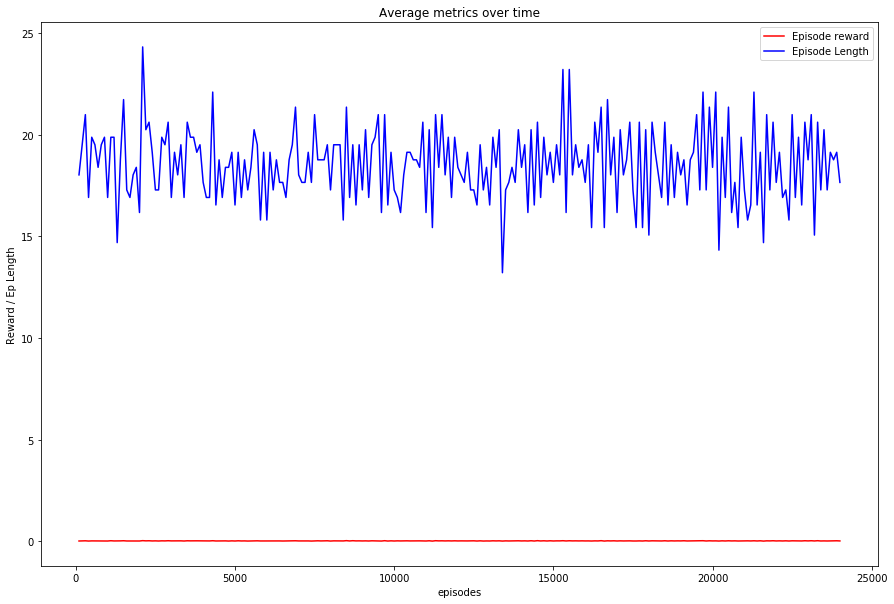

In [58]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best')

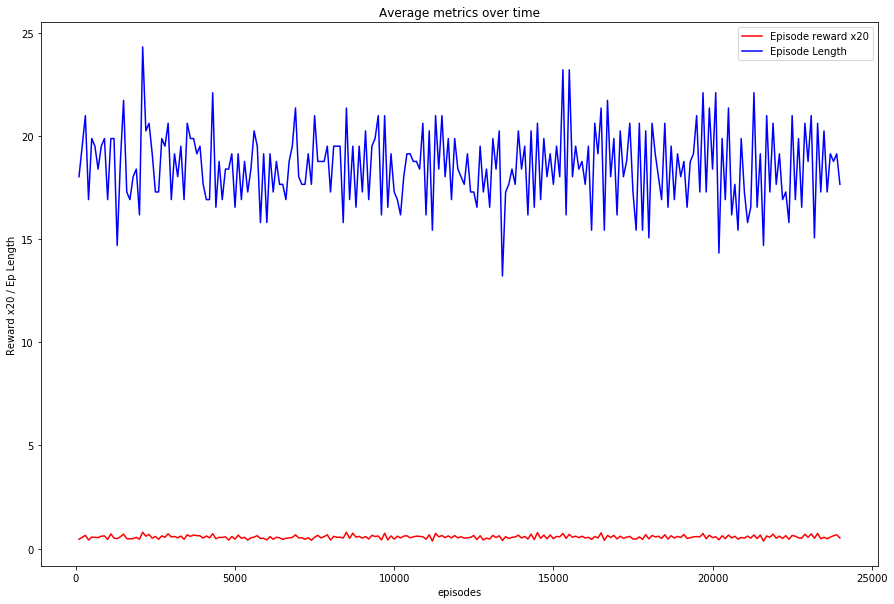

In [59]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best')

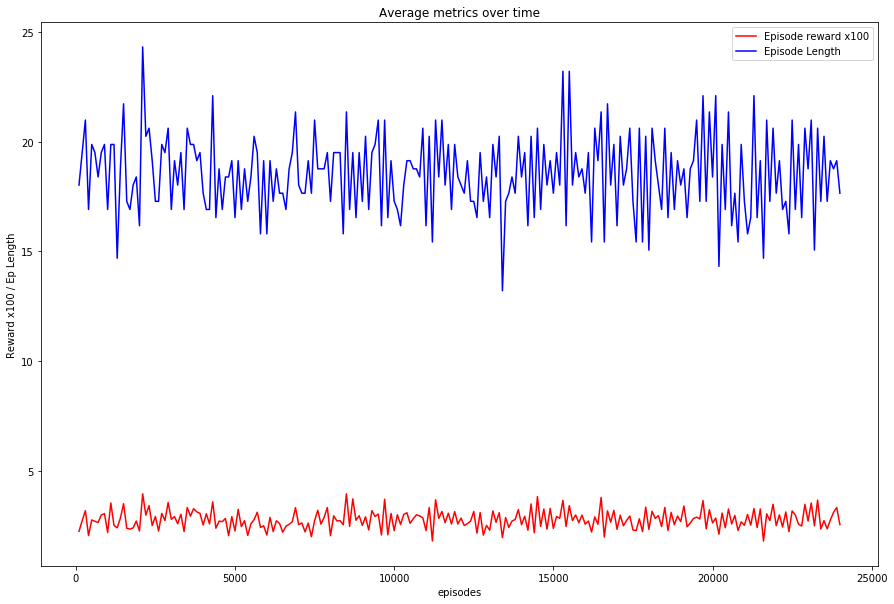

In [60]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best')

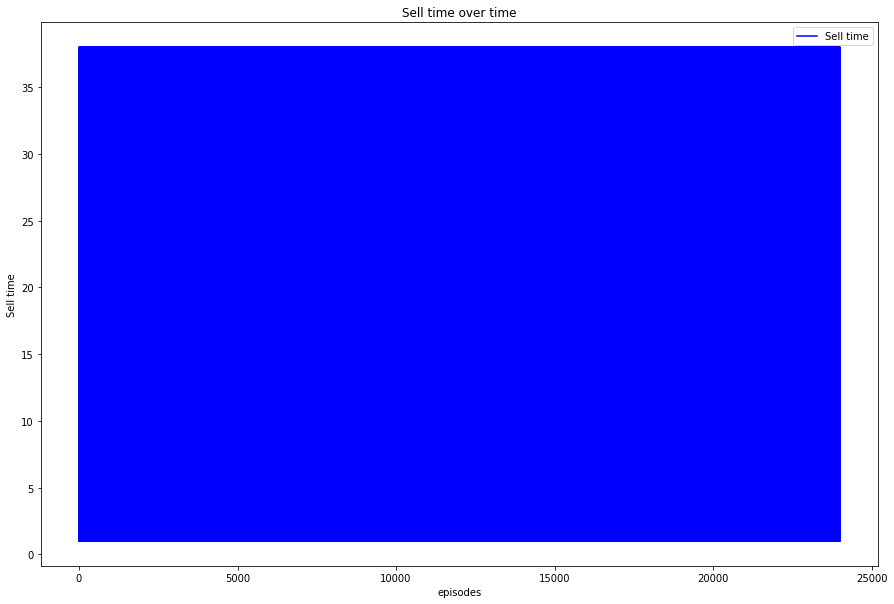

In [61]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Select day of Max price over history [Benchmark]

In [62]:
env.reset_new_test() # reset to first observation in data
begin_time = time.time()

test = 'MaxValue' #'Random'

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []
  

with tf.Session() as sess, tf.device('/gpu:0'):
    
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        
        if test == 'Random':
          sell_time = random.randint(build_warm_up_state_t,max_epLength - 1)
        elif test == 'MaxValue' or test == 'Normal':
          sell_time = -1
        
        while j < max_epLength: 
            if test == 'MaxValue':
              if env.get_time() >= build_warm_up_state_t and (s[-1] >= max(s) or j == max_epLength - 1) and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
            elif test == 'Random':
              if j == sell_time and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)
            
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            j+=1 # episode length till selling or reaching last day of option
            
            if env.is_episode_finished():
                break

        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)

        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT)+ '\t'+ str(e))
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

episode 100: 	0.022581448634089427	18.02	0.009999823009336896
episode 200: 	0.027417230396361805	19.5	0.009999823009336896
episode 300: 	0.031997202597456	20.98	0.009999823009336896
episode 400: 	0.02065658360285716	16.91	0.009999823009336896
episode 500: 	0.02775722507488879	19.87	0.009999823009336896
episode 600: 	0.02713543731829545	19.5	0.009999823009336896
episode 700: 	0.0266069804130894	18.39	0.009999823009336896
episode 800: 	0.03000183668807212	19.5	0.009999823009336896
episode 900: 	0.03066043113320444	19.87	0.009999823009336896
episode 1000: 	0.02202709380462718	16.91	0.009999823009336896
episode 1100: 	0.03549586296670482	19.87	0.009999823009336896
episode 1200: 	0.025254950387408846	19.87	0.009999823009336896
episode 1300: 	0.02418573369415695	14.69	0.009999823009336896
episode 1400: 	0.028573172015848906	18.76	0.009999823009336896
episode 1500: 	0.03514896746351186	21.72	0.009999823009336896
episode 1600: 	0.02395899407301606	17.28	0.009999823009336896
episode 1700: 	0.02

episode 13100: 	0.031868974781966035	19.87	0.009999823009336896
episode 13200: 	0.02669460662756759	18.39	0.009999823009336896
episode 13300: 	0.0310750991497986	20.24	0.009999823009336896
episode 13400: 	0.019711676086151687	13.21	0.009999823009336896
episode 13500: 	0.028859790518083316	17.28	0.009999823009336896
episode 13600: 	0.024321603350135258	17.65	0.009999823009336896
episode 13700: 	0.02722771525689935	18.39	0.009999823009336896
episode 13800: 	0.027975255635708414	17.65	0.009999823009336896
episode 13900: 	0.03248318422823871	20.24	0.009999823009336896
episode 14000: 	0.025598789019901143	18.39	0.009999823009336896
episode 14100: 	0.029463741421406314	19.5	0.009999823009336896
episode 14200: 	0.02310992008742334	16.17	0.009999823009336896
episode 14300: 	0.0350450629172126	20.24	0.009999823009336896
episode 14400: 	0.02193107143183453	16.54	0.009999823009336896
episode 14500: 	0.03841979335045354	20.61	0.009999823009336896
episode 14600: 	0.024838278338626528	16.91	0.009999

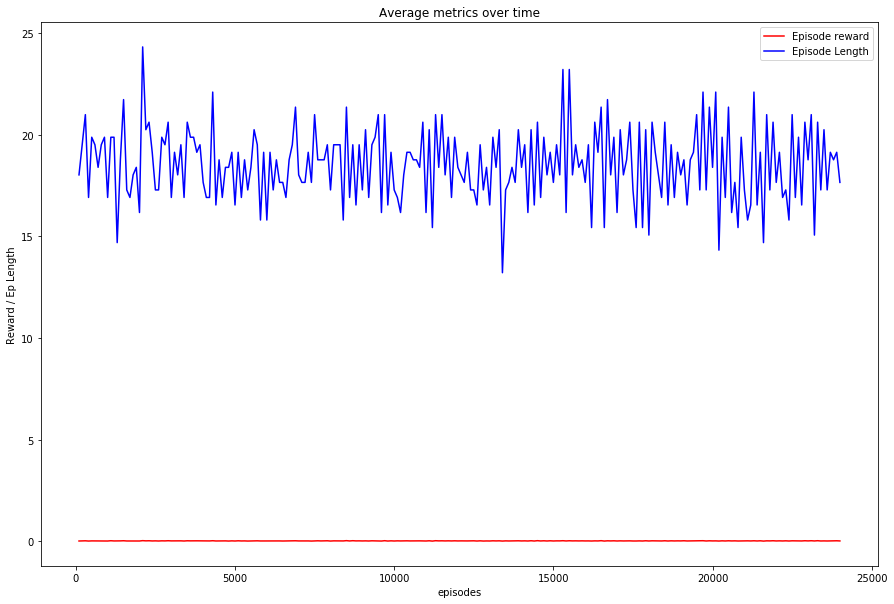

In [64]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best')

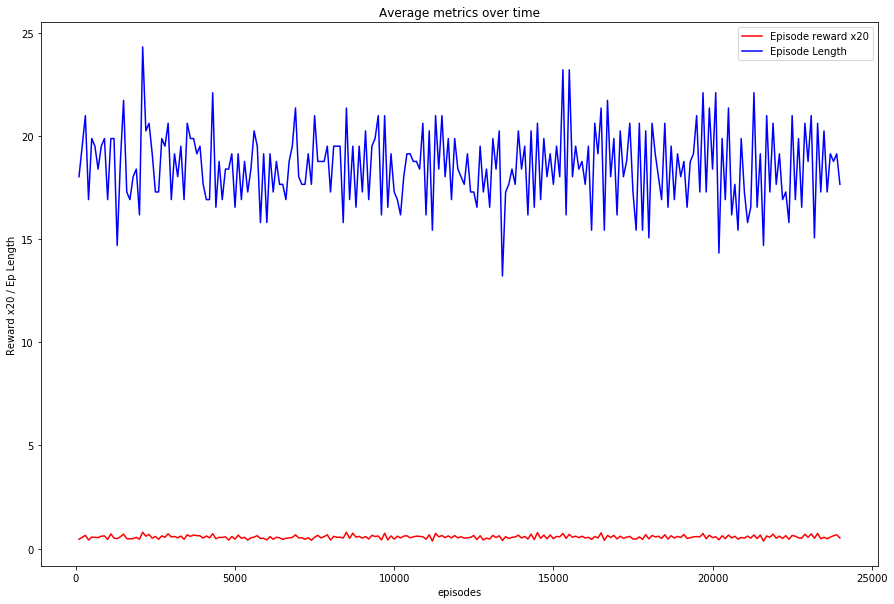

In [65]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best')

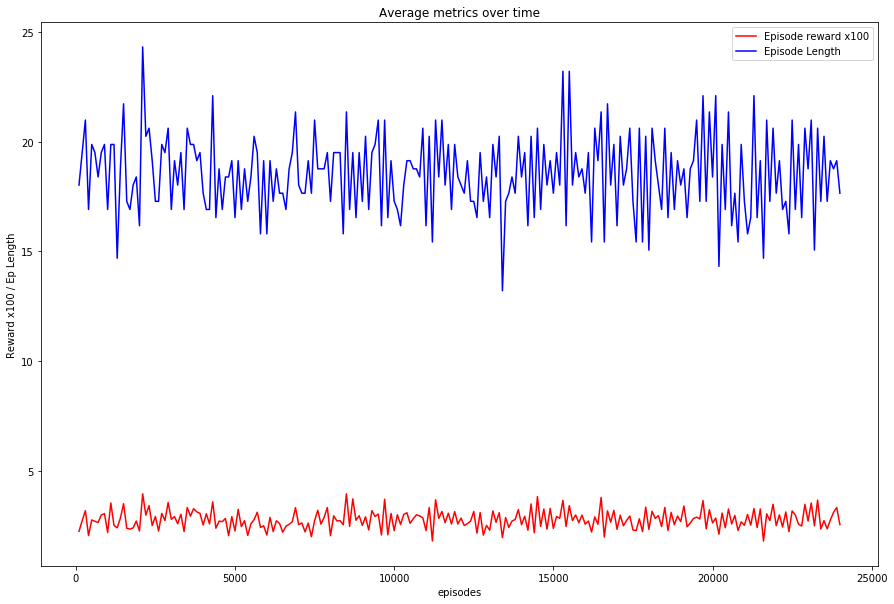

In [66]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best')

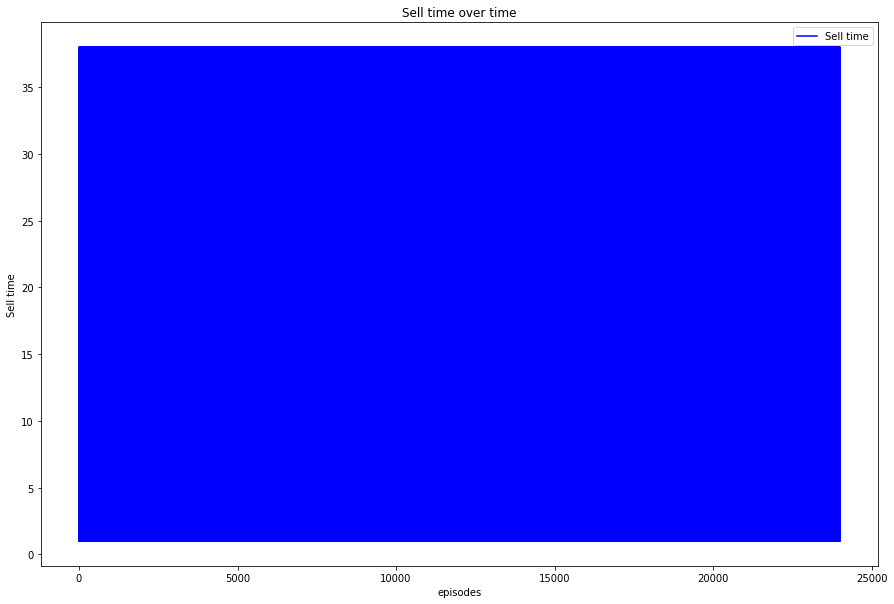

In [67]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Select random day over history to sell [Benchmark]

In [68]:
env.reset_new_test() # reset to first observation in data
begin_time = time.time()

test = 'Random'

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []
  

with tf.Session() as sess, tf.device('/gpu:0'):
    
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        
        if test == 'Random':
          sell_time = random.randint(build_warm_up_state_t,max_epLength - 1)
        elif test == 'MaxValue' or test == 'Normal':
          sell_time = -1
        
        while j < max_epLength: 
            if test == 'MaxValue':
              if (s[-1] >= max(s) or j == max_epLength - 1) and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
            elif test == 'Random':
              if j == sell_time and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)
            
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            j+=1 # episode length till selling or reaching last day of option
            
            if env.is_episode_finished():
                break
        
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)
        
        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT)+ '\t'+ str(e))
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))   

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

episode 100: 	0.018985517408622546	14.89	0.009999823009336896
episode 200: 	0.02353369205143095	14.35	0.009999823009336896
episode 300: 	0.02709817548365605	15.85	0.009999823009336896
episode 400: 	0.019326316345312372	12.03	0.009999823009336896
episode 500: 	0.021825455617769447	15.29	0.009999823009336896
episode 600: 	0.022923921588171758	14.13	0.009999823009336896
episode 700: 	0.022494063049595593	15.12	0.009999823009336896
episode 800: 	0.026418579591522447	14.38	0.009999823009336896
episode 900: 	0.025159620634301404	15.17	0.009999823009336896
episode 1000: 	0.021561372457514567	14.74	0.009999823009336896
episode 1100: 	0.030951231073436003	15.68	0.009999823009336896
episode 1200: 	0.026146016604295375	14.49	0.009999823009336896
episode 1300: 	0.0177065034886322	11.53	0.009999823009336896
episode 1400: 	0.024939879652274927	16.27	0.009999823009336896
episode 1500: 	0.02700587552796033	16.89	0.009999823009336896
episode 1600: 	0.02688709873511204	14.37	0.009999823009336896
episode

episode 13000: 	0.020894067224423742	15.03	0.009999823009336896
episode 13100: 	0.026225294985630115	15.66	0.009999823009336896
episode 13200: 	0.024942445231949238	15.72	0.009999823009336896
episode 13300: 	0.025074693164765564	13.91	0.009999823009336896
episode 13400: 	0.020092660529971367	12.67	0.009999823009336896
episode 13500: 	0.022326900215328724	12.32	0.009999823009336896
episode 13600: 	0.021779940606789006	15.73	0.009999823009336896
episode 13700: 	0.022901349784480884	15.04	0.009999823009336896
episode 13800: 	0.016882481041408284	11.07	0.009999823009336896
episode 13900: 	0.023812284213445337	14.92	0.009999823009336896
episode 14000: 	0.021882082147000964	13.74	0.009999823009336896
episode 14100: 	0.024698001863368534	13.24	0.009999823009336896
episode 14200: 	0.01925166433169565	12.45	0.009999823009336896
episode 14300: 	0.02626566531711397	14.88	0.009999823009336896
episode 14400: 	0.021586383246439262	13.18	0.009999823009336896
episode 14500: 	0.029470112052128728	15.57

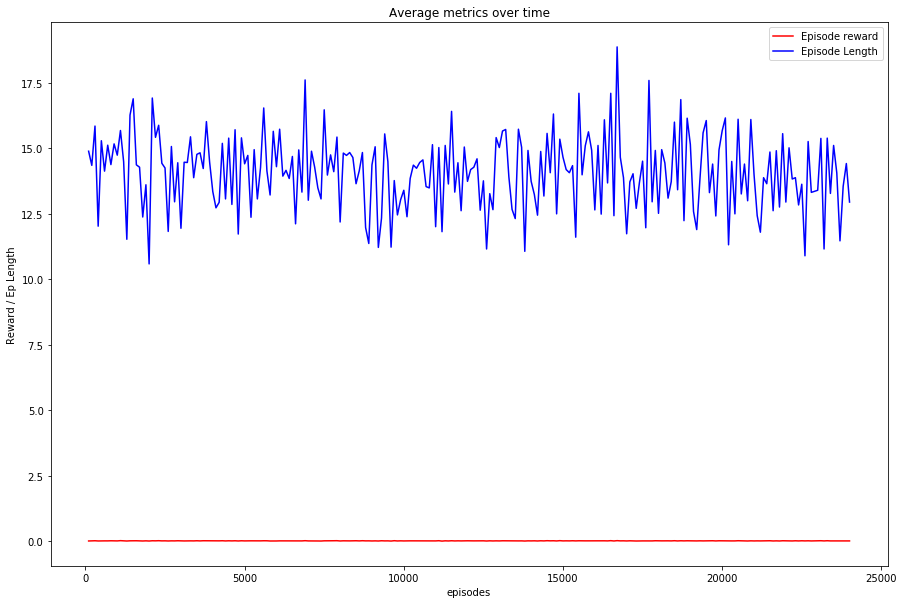

In [70]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best')

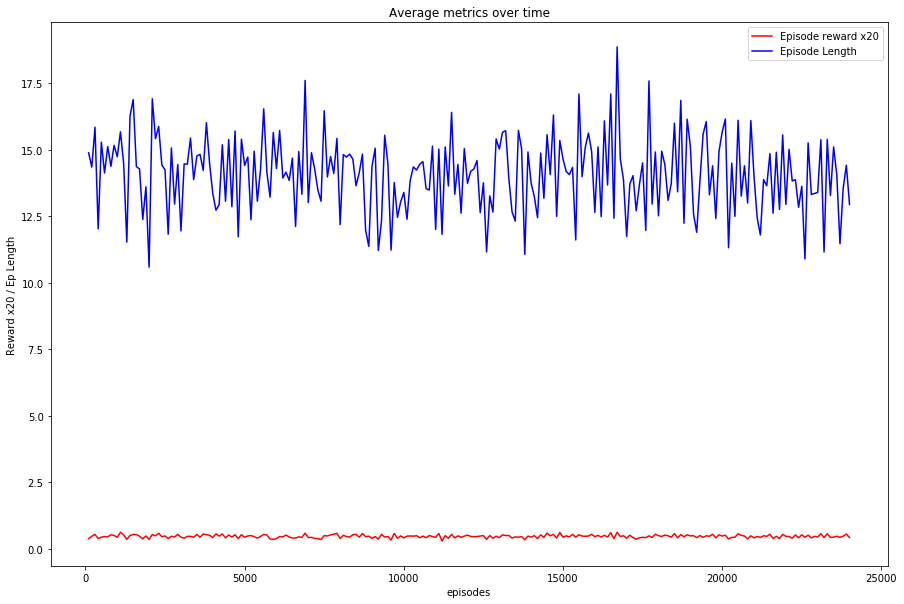

In [71]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best')

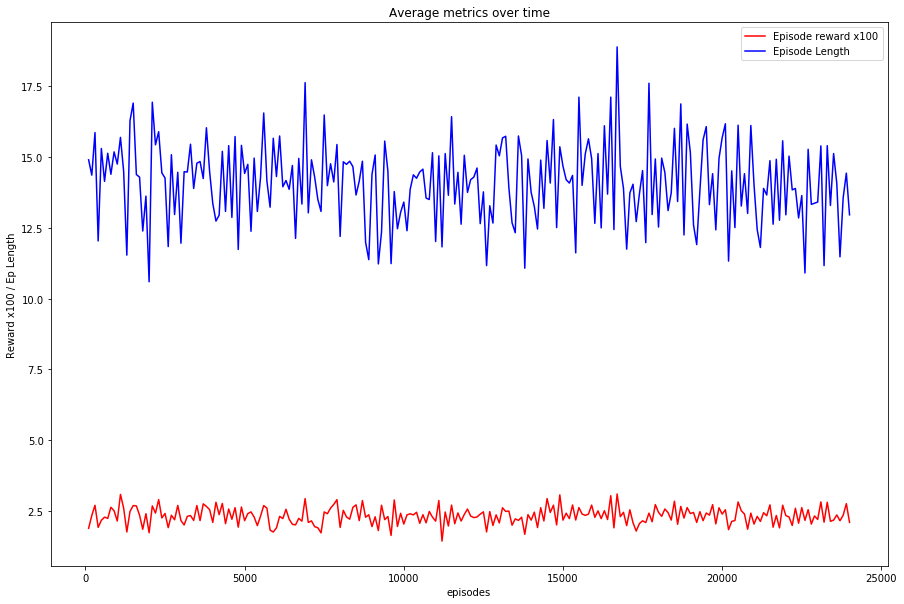

In [72]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best')

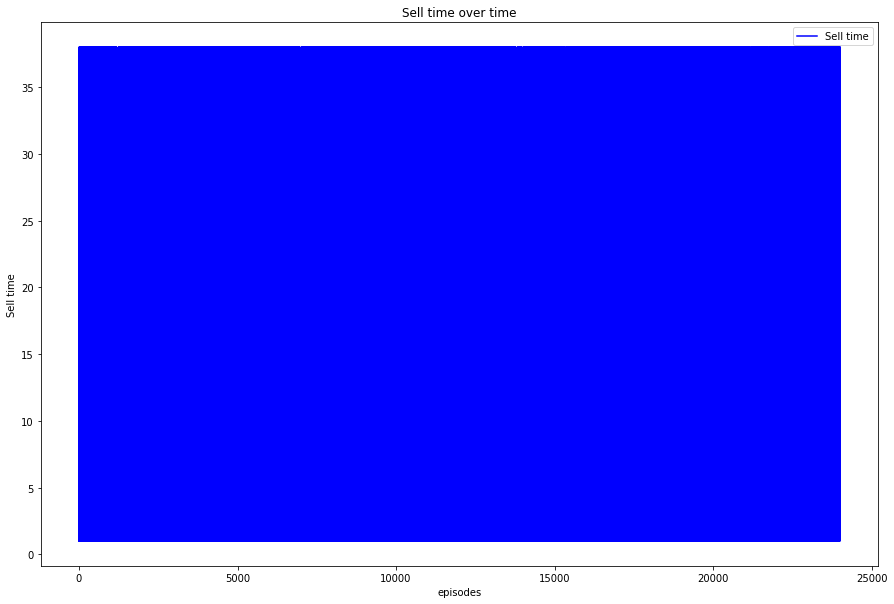

In [73]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Select last day over history to sell [Benchmark]

In [74]:
env.reset_new_test() # reset to first observation in data
begin_time = time.time()

test = 'LastDay'

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []

with tf.Session() as sess, tf.device('/gpu:0'):
    
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        
        if test == 'Random':
          sell_time = random.randint(build_warm_up_state_t,max_epLength - 1)
        elif test == 'LastDay':
          sell_time = max_epLength - 1  
        elif test == 'MaxValue' or test == 'Normal':
          sell_time = -1
        
        while j < max_epLength: 
            if test == 'MaxValue':
              if (s[-1] >= max(s) or j == max_epLength - 1) and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
            elif test == 'Random' or test == 'LastDay':
              if j == sell_time and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)

            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            j+=1 # episode length till selling or reaching last day of option
            
            if env.is_episode_finished():
                break
        
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)

        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT)+ '\t'+ str(e))
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))   

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

episode 100: 	0.022581448634089427	18.02	0.009999823009336896
episode 200: 	0.027417230396361805	19.5	0.009999823009336896
episode 300: 	0.031997202597456	20.98	0.009999823009336896
episode 400: 	0.02065658360285716	16.91	0.009999823009336896
episode 500: 	0.02775722507488879	19.87	0.009999823009336896
episode 600: 	0.02713543731829545	19.5	0.009999823009336896
episode 700: 	0.0266069804130894	18.39	0.009999823009336896
episode 800: 	0.03000183668807212	19.5	0.009999823009336896
episode 900: 	0.03066043113320444	19.87	0.009999823009336896
episode 1000: 	0.02202709380462718	16.91	0.009999823009336896
episode 1100: 	0.03549586296670482	19.87	0.009999823009336896
episode 1200: 	0.025254950387408846	19.87	0.009999823009336896
episode 1300: 	0.02418573369415695	14.69	0.009999823009336896
episode 1400: 	0.028573172015848906	18.76	0.009999823009336896
episode 1500: 	0.03514896746351186	21.72	0.009999823009336896
episode 1600: 	0.02395899407301606	17.28	0.009999823009336896
episode 1700: 	0.02

episode 13100: 	0.031868974781966035	19.87	0.009999823009336896
episode 13200: 	0.02669460662756759	18.39	0.009999823009336896
episode 13300: 	0.0310750991497986	20.24	0.009999823009336896
episode 13400: 	0.019711676086151687	13.21	0.009999823009336896
episode 13500: 	0.028859790518083316	17.28	0.009999823009336896
episode 13600: 	0.024321603350135258	17.65	0.009999823009336896
episode 13700: 	0.02722771525689935	18.39	0.009999823009336896
episode 13800: 	0.027975255635708414	17.65	0.009999823009336896
episode 13900: 	0.03248318422823871	20.24	0.009999823009336896
episode 14000: 	0.025598789019901143	18.39	0.009999823009336896
episode 14100: 	0.029463741421406314	19.5	0.009999823009336896
episode 14200: 	0.02310992008742334	16.17	0.009999823009336896
episode 14300: 	0.0350450629172126	20.24	0.009999823009336896
episode 14400: 	0.02193107143183453	16.54	0.009999823009336896
episode 14500: 	0.03841979335045354	20.61	0.009999823009336896
episode 14600: 	0.024838278338626528	16.91	0.009999

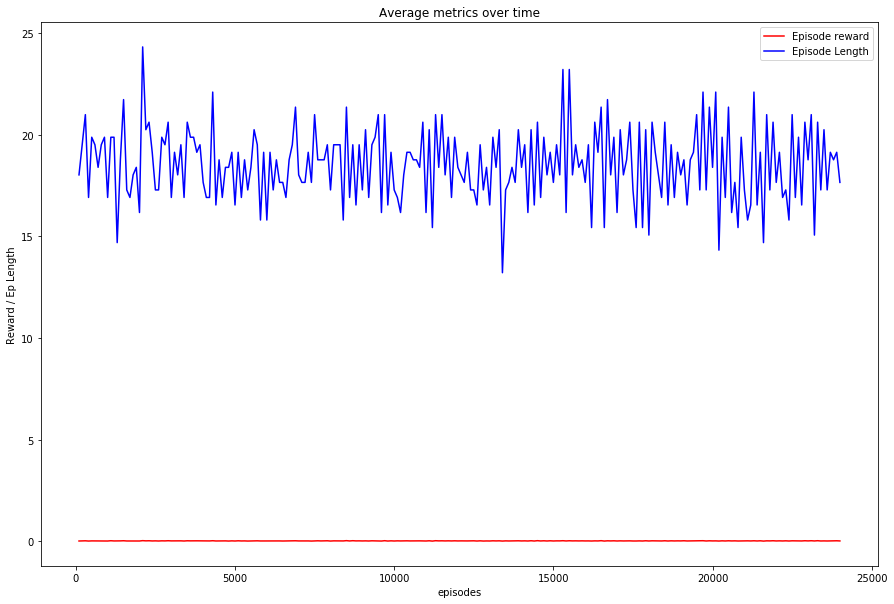

In [76]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best')

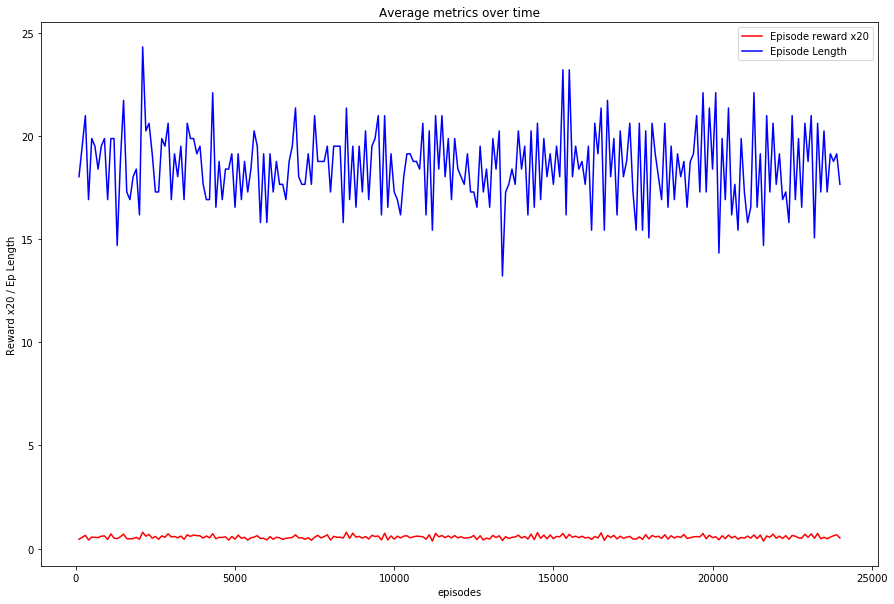

In [77]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best')

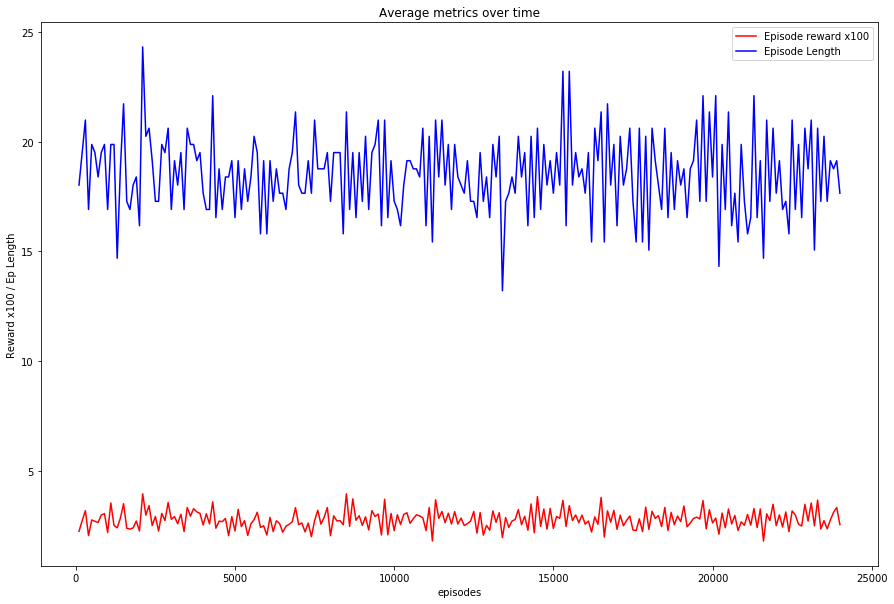

In [78]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best')

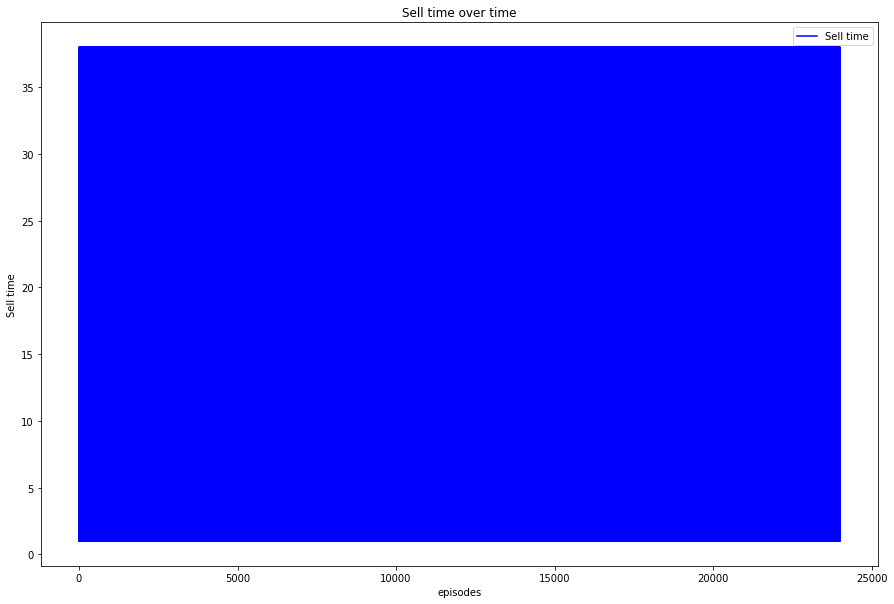

In [79]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Select first day over history to sell [Benchmark]

In [80]:
env.reset_new_test() # reset to first observation in data
begin_time = time.time()

test = 'FirstDay'

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = [] 

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []

with tf.Session() as sess, tf.device('/gpu:0'):
    
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        
        if test == 'Random':
          sell_time = random.randint(build_warm_up_state_t,max_epLength - 1)
        elif test == 'FirstDay':
          sell_time = build_warm_up_state_t 
        elif test == 'MaxValue' or test == 'Normal':
          sell_time = -1
        
        while j < max_epLength: 
            if test == 'MaxValue':
              if (s[-1] >= max(s) or j == max_epLength - 1) and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
            elif test == 'Random' or test == 'FirstDay':
              if j == sell_time and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)

            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            j+=1 # episode length till selling or reaching last day of option
            
            if env.is_episode_finished():
                break
        
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)

        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT)+ '\t'+ str(e))
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))   

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

episode 100: 	0.017692379422125096	9.51	0.009999823009336896
episode 200: 	0.02144617383178988	10.62	0.009999823009336896
episode 300: 	0.02250849955350807	8.4	0.009999823009336896
episode 400: 	0.012193417094354392	6.92	0.009999823009336896
episode 500: 	0.017102552612875358	10.25	0.009999823009336896
episode 600: 	0.0140978706198646	8.77	0.009999823009336896
episode 700: 	0.018862396739397682	9.88	0.009999823009336896
episode 800: 	0.019630749819316985	9.88	0.009999823009336896
episode 900: 	0.014371116898716856	8.03	0.009999823009336896
episode 1000: 	0.01565087375569317	7.66	0.009999823009336896
episode 1100: 	0.01988583580095101	8.77	0.009999823009336896
episode 1200: 	0.017334907318956132	8.03	0.009999823009336896
episode 1300: 	0.01682154533892341	7.66	0.009999823009336896
episode 1400: 	0.01959536445020771	9.51	0.009999823009336896
episode 1500: 	0.020054969953803195	12.1	0.009999823009336896
episode 1600: 	0.01405499227562805	7.66	0.009999823009336896
episode 1700: 	0.01374008

episode 13200: 	0.01493039676601141	7.29	0.009999823009336896
episode 13300: 	0.020713560936362355	10.62	0.009999823009336896
episode 13400: 	0.0136418630702273	6.55	0.009999823009336896
episode 13500: 	0.011823922413182633	6.18	0.009999823009336896
episode 13600: 	0.014244231690680358	8.03	0.009999823009336896
episode 13700: 	0.015051862517566161	8.03	0.009999823009336896
episode 13800: 	0.015885275795284603	8.77	0.009999823009336896
episode 13900: 	0.017627519645361037	9.14	0.009999823009336896
episode 14000: 	0.016177862501584716	8.77	0.009999823009336896
episode 14100: 	0.013327805319948028	8.4	0.009999823009336896
episode 14200: 	0.014115958735200575	8.4	0.009999823009336896
episode 14300: 	0.01768477649114268	9.14	0.009999823009336896
episode 14400: 	0.015773224262471523	10.25	0.009999823009336896
episode 14500: 	0.022388420781123308	10.62	0.009999823009336896
episode 14600: 	0.017721313132393893	9.88	0.009999823009336896
episode 14700: 	0.02016624402310649	8.77	0.009999823009336

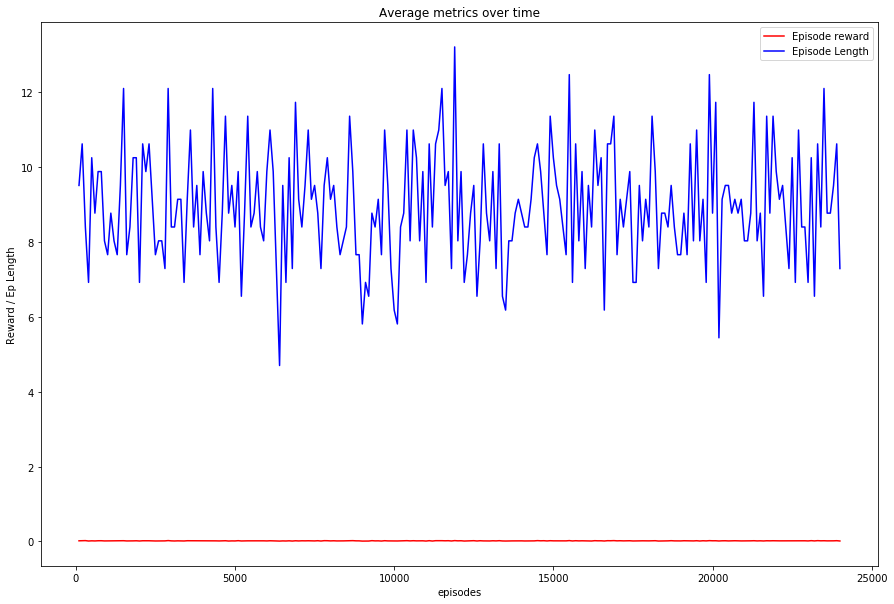

In [81]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best')

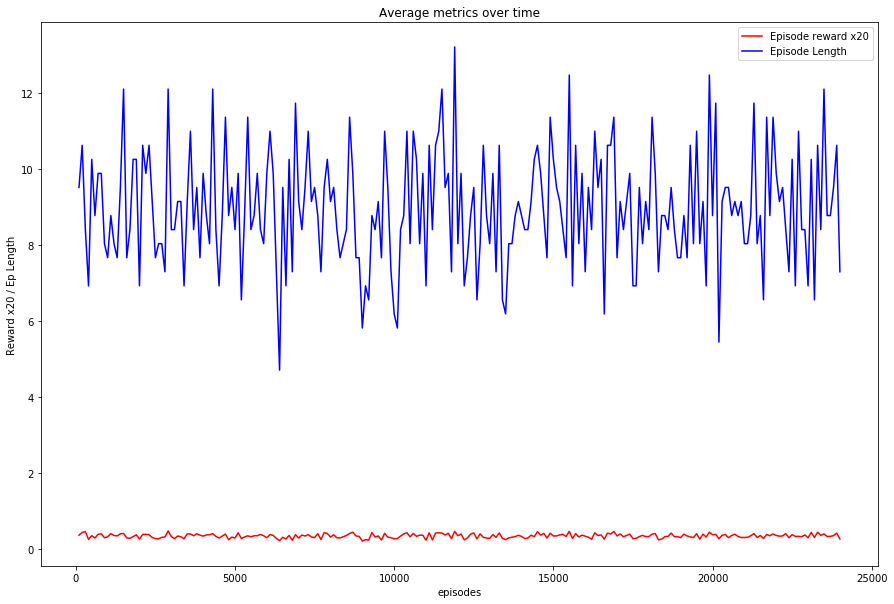

In [82]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best')

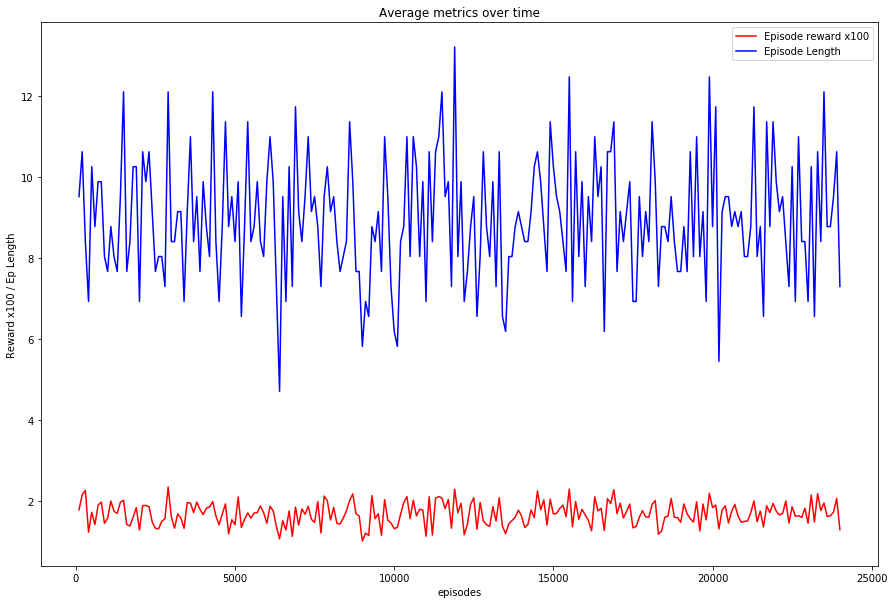

In [83]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best')

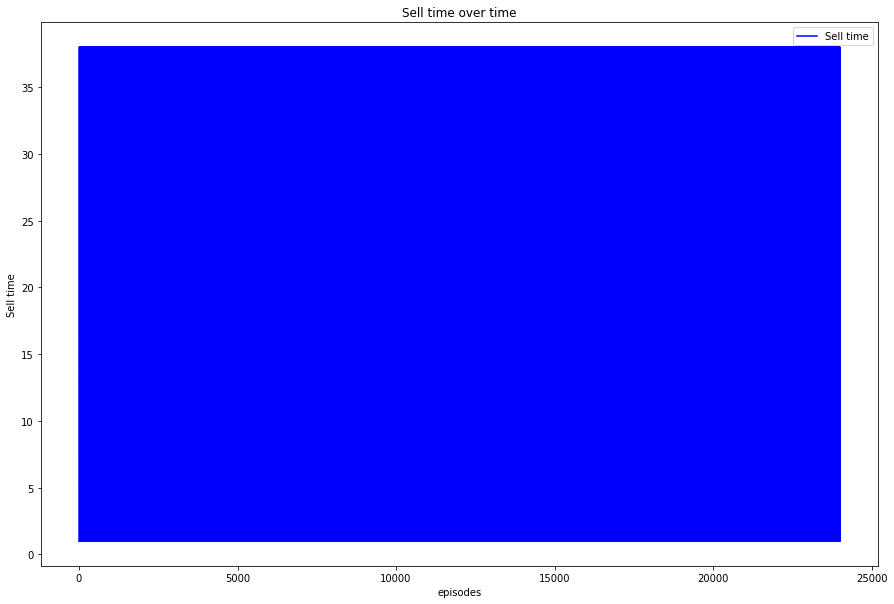

In [84]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Validation part

min value of data: 152.40072436906038, max value of data: 233.76779815686893
train_size: 743
test_size: 185
min value of data: 141.69220585131188, max value of data: 224.2618146036533
train_size: 743
test_size: 185
min value of data: 130.8036533100137, max value of data: 207.4614762731008
train_size: 743
test_size: 185
min value of data: 59.36989414885515, max value of data: 102.90875728615067
train_size: 743
test_size: 185
min value of data: 88.32482844060033, max value of data: 127.85678135456038
train_size: 743
test_size: 185
min value of data: 131.8732349738424, max value of data: 188.89924331210884
train_size: 743
test_size: 185
min value of data: 77.90661199501645, max value of data: 126.6348094962481
train_size: 743
test_size: 185
min value of data: 54.63192490207038, max value of data: 97.24646621796207
train_size: 743
test_size: 185
min value of data: 77.95062815511642, max value of data: 173.2507563827493
train_size: 743
test_size: 185
min value of data: 146.10846847083647, m

min value of data: 113.04772003837897, max value of data: 191.00850386959965
train_size: 743
test_size: 185
min value of data: 86.29171171109184, max value of data: 120.9737810467554
train_size: 743
test_size: 185
min value of data: 174.5390023271719, max value of data: 312.9928468391085
train_size: 743
test_size: 185
min value of data: 104.68369112144221, max value of data: 175.69289535239443
train_size: 743
test_size: 185
min value of data: 109.28802015299256, max value of data: 174.94161770636282
train_size: 743
test_size: 185
min value of data: 112.84866302290418, max value of data: 215.01252479478413
train_size: 743
test_size: 185
min value of data: 108.57876748415215, max value of data: 213.19667187028094
train_size: 743
test_size: 185
min value of data: 112.04110375478699, max value of data: 186.3400028001162
train_size: 743
test_size: 185
min value of data: 133.23786376966248, max value of data: 210.67681549178477
train_size: 743
test_size: 185
min value of data: 153.6505338002

min value of data: 85.99950370748677, max value of data: 156.48669220534805
train_size: 743
test_size: 185
min value of data: 83.10320896083245, max value of data: 182.2989465063999
train_size: 743
test_size: 185
min value of data: 99.13068615982537, max value of data: 156.46628802438272
train_size: 743
test_size: 185
min value of data: 95.41750846967844, max value of data: 181.75110600099617
train_size: 743
test_size: 185
min value of data: 89.0035458912678, max value of data: 171.22985557633888
train_size: 743
test_size: 185
min value of data: 56.96111276198021, max value of data: 100.77502632201188
train_size: 743
test_size: 185
min value of data: 143.93650671836096, max value of data: 216.92154652210087
train_size: 743
test_size: 185
min value of data: 110.477473084887, max value of data: 198.16416988713775
train_size: 743
test_size: 185
min value of data: 81.01800046552258, max value of data: 162.8792969692057
train_size: 743
test_size: 185
min value of data: 66.55293975394211, ma

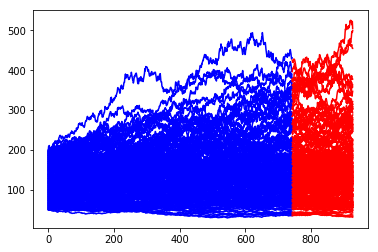

In [86]:
#Generate stocks data
stocks_data, _ = GBM(num_seeds, is_training).generate_stock_paths(mu, sigma, 928, num_seeds, is_training)
stocks_train_data = []
stocks_test_data = []
real_stocks_train_data = []
real_stocks_test_data = []
for stock_data in stocks_data:
    train_data, test_data, real_train_data, real_test_data = prepare_company_stock(stock_data, Normalization, Window_Normalization, scriptDirectory, test_data_ratio)
    stocks_train_data.append(train_data)
    stocks_test_data.append(test_data)
    real_stocks_train_data.append(real_train_data)
    real_stocks_test_data.append(real_test_data)
    plt.plot(range(len(train_data)), train_data, color='b')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), test_data, color='r') 

###############################
option_T: 50
history_t: 15
build_warm_up_state_t: 12
###############################
num_batch_episodes_per_epoch: 187
num_episodes_per_epoch: 24000
min value of stock: 126.41322951712296, max value of stock: 140.16641891411143


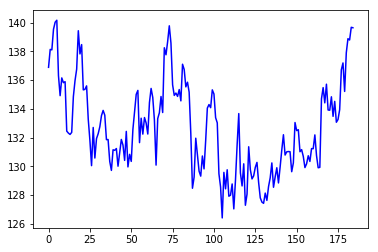

In [87]:
env = StockEnv(stocks_test_data, real_stocks_test_data, risk_free_rate, history_t=history_t, option_T=option_T)
num_batch_episodes_per_epoch = env.get_total_num_episodes_per_epoch() // batch_size
num_episodes = env.get_total_num_episodes_per_epoch()
print('num_batch_episodes_per_epoch: ' + str(num_batch_episodes_per_epoch))
print('num_episodes_per_epoch: ' + str(env.get_total_num_episodes_per_epoch()))
print('min value of stock: '+str(min(test_data)) + ', max value of stock: '+str(max(test_data)))
plt.plot(range(len(test_data)), test_data, color='b')

In [88]:
begin_time = time.time()
tf.reset_default_graph()

mainQN = Qnetwork('main')
targetQN = Qnetwork('target')


init = tf.global_variables_initializer()

saver = tf.train.Saver(max_to_keep=2)

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path) 
  

with tf.Session() as sess, tf.device('/gpu:0'):
    set_seed(seed)
    if load_model == True:
        print ('Loading Model...')
        saver.restore(sess,final_trained_model_name)
    else:
        sess.run(init)
    
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        #Reset the recurrent layer's hidden state
        state = np.zeros((num_layers, 2, 1, h_size))
        while j < max_epLength: 

            if j == max_epLength - 1 and env.is_episode_finished() == False:
                a = 1
            else:
                a, state1 = sess.run([mainQN.predict,mainQN.rnn_state],\
                        feed_dict={mainQN.scalarInput:[s],mainQN.trainLength:1,mainQN.state_in:state,mainQN.batch_size:1})
                if env.get_time() < build_warm_up_state_t:
                    a = 0 #hold
                elif env.get_payoff() <= 0:
                    a = 0 #hold
                    #num_short_sell += 1
                else:
                    a = a[0]
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)
            
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            state = state1
            j+=1 # episode length till selling or reaching last day of option

            if env.is_episode_finished():
                break
        
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)
        
        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT))
            
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

Loading Model...
INFO:tensorflow:Restoring parameters from C:\Code_RL\normalizeFirstDay_seed_corrected_2019_11_21_shuffled_GBM_version\savedModel\RL_10000rep_200seeds_0001_128batch_1000pre_arch0-option_T50-history_t15-dueling_typemax-freq300-batch128-capacity10000-lambda0.0001-final
episode 100: 	0.03718361595753666	20.24
episode 200: 	0.019799153386866778	15.45
episode 300: 	0.02926910643953643	20.61
episode 400: 	0.022108408166567707	17.28
episode 500: 	0.027761575396645508	19.5
episode 600: 	0.03205500330093754	20.98
episode 700: 	0.03072949072312679	19.13
episode 800: 	0.028184296131763167	17.28
episode 900: 	0.03438729784823775	22.83
episode 1000: 	0.022650057809341928	19.5
episode 1100: 	0.03366059529931284	21.72
episode 1200: 	0.031126637565210617	20.98
episode 1300: 	0.026388169320491057	18.39
episode 1400: 	0.029678669918221115	18.02
episode 1500: 	0.030647293296734122	20.61
episode 1600: 	0.03270949698009878	21.72
episode 1700: 	0.026997813493847576	17.65
episode 1800: 	0.028

episode 18600: 	0.024780187660103595	15.8
episode 18700: 	0.026956211448340293	19.13
episode 18800: 	0.031642438863057135	20.98
episode 18900: 	0.02468002554316181	19.13
episode 19000: 	0.02494486823820953	19.87
episode 19100: 	0.025469167955766658	18.02
episode 19200: 	0.028098948087052857	18.76
episode 19300: 	0.03489560333929392	20.61
episode 19400: 	0.031118997056166654	19.13
episode 19500: 	0.026295319413002158	18.39
episode 19600: 	0.02356816574499952	18.02
episode 19700: 	0.02380385971628517	19.13
episode 19800: 	0.025311886986786478	17.65
episode 19900: 	0.03661024333787627	21.36
episode 20000: 	0.024253809802022883	18.02
#Average reward per episode 20000: 0.027318959167615224
episode 20100: 	0.02944339924156165	20.24
episode 20200: 	0.030918974987207734	19.5
episode 20300: 	0.03170873878065424	16.54
episode 20400: 	0.02288429642486738	16.54
episode 20500: 	0.02746913006032406	19.5
episode 20600: 	0.02379188100081362	16.54
episode 20700: 	0.029779031450138847	20.98
episode 2080

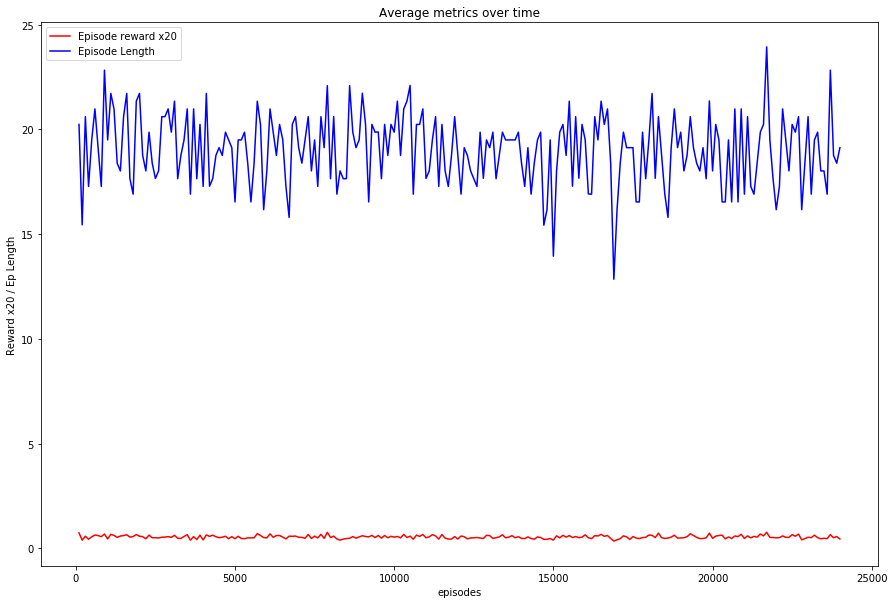

In [91]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best');

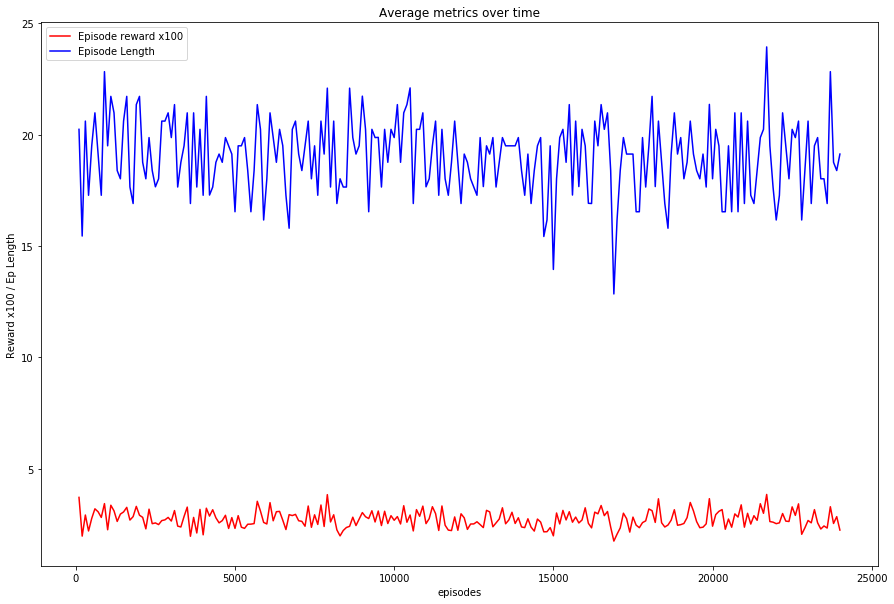

In [92]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best');

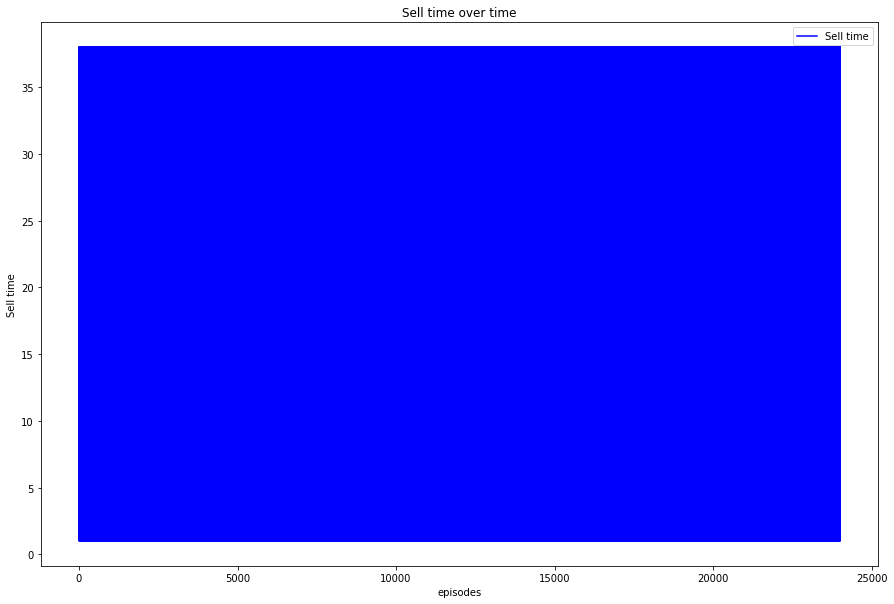

In [93]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Second Valid

###############################
option_T: 50
history_t: 15
build_warm_up_state_t: 12
###############################
num_batch_episodes_per_epoch: 1059
num_episodes_per_epoch: 135600
min value of stock: 82.18749191096272, max value of stock: 150.4874000630351


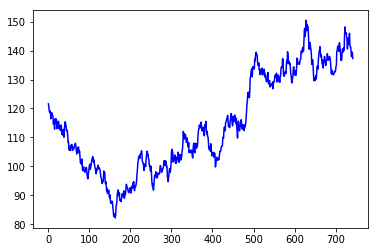

In [94]:
env = StockEnv(stocks_train_data, real_stocks_train_data, risk_free_rate, history_t=history_t, option_T=option_T)
#max_num_observations = env.max_num_observations
num_batch_episodes_per_epoch = env.get_total_num_episodes_per_epoch() // batch_size
num_episodes = env.get_total_num_episodes_per_epoch()
print('num_batch_episodes_per_epoch: ' + str(num_batch_episodes_per_epoch))
print('num_episodes_per_epoch: ' + str(env.get_total_num_episodes_per_epoch()))
print('min value of stock: '+str(min(train_data)) + ', max value of stock: '+str(max(train_data)))
plt.plot(range(len(train_data)), train_data, color='b')

In [95]:
begin_time = time.time()
tf.reset_default_graph()

mainQN = Qnetwork('main')
targetQN = Qnetwork('target')


init = tf.global_variables_initializer()

saver = tf.train.Saver(max_to_keep=2)

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []

#num_short_sell = 0

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path) 
  

with tf.Session() as sess, tf.device('/gpu:0'):
    set_seed(seed)
    if load_model == True:
        print ('Loading Model...')
        #ckpt = tf.train.get_checkpoint_state(path)
        #saver.restore(sess,ckpt.model_checkpoint_path)
        saver.restore(sess,final_trained_model_name)
    else:
        sess.run(init)
    
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        #Reset the recurrent layer's hidden state
        state = np.zeros((num_layers, 2, 1, h_size))
        while j < max_epLength: 

            if j == max_epLength - 1 and env.is_episode_finished() == False:
                a = 1
            else:
                a, state1 = sess.run([mainQN.predict,mainQN.rnn_state],\
                        feed_dict={mainQN.scalarInput:[s],mainQN.trainLength:1,mainQN.state_in:state,mainQN.batch_size:1})
                if env.get_time() < build_warm_up_state_t:
                    a = 0 #hold
                elif env.get_payoff() <= 0:
                    a = 0 #hold
                    #num_short_sell += 1
                else:
                    a = a[0]
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)
            
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            state = state1
            j+=1 # episode length till selling or reaching last day of option

            if env.is_episode_finished():
                break
        
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)
        
        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT))
            
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

Loading Model...
INFO:tensorflow:Restoring parameters from C:\Code_RL\normalizeFirstDay_seed_corrected_2019_11_21_shuffled_GBM_version\savedModel\RL_10000rep_200seeds_0001_128batch_1000pre_arch0-option_T50-history_t15-dueling_typemax-freq300-batch128-capacity10000-lambda0.0001-final
episode 100: 	0.02579743210226387	18.39
episode 200: 	0.02577187138215883	20.24
episode 300: 	0.03276231701326735	20.61
episode 400: 	0.025196370977244236	19.13
episode 500: 	0.031430838163134016	20.24
episode 600: 	0.030031135474847995	19.5
episode 700: 	0.03433982655001458	19.87
episode 800: 	0.028947790614674115	19.13
episode 900: 	0.027002137234875764	18.02
episode 1000: 	0.028270907482319915	18.39
episode 1100: 	0.026314913524698055	19.87
episode 1200: 	0.027549998497570238	18.02
episode 1300: 	0.02705982972327257	19.13
episode 1400: 	0.027524821849193904	20.24
episode 1500: 	0.01980132802802262	15.8
episode 1600: 	0.02414119754630991	16.17
episode 1700: 	0.022144246140229952	15.43
episode 1800: 	0.027

episode 18700: 	0.03249547790387649	19.87
episode 18800: 	0.02218817676100116	16.17
episode 18900: 	0.025437781137511467	18.39
episode 19000: 	0.024499095148980278	18.02
episode 19100: 	0.02848271097793173	18.02
episode 19200: 	0.02757412749434808	18.02
episode 19300: 	0.020140316553004446	17.66
episode 19400: 	0.03357032619216445	20.98
episode 19500: 	0.026175743755465334	20.24
episode 19600: 	0.02665567495633696	20.98
episode 19700: 	0.03105000618222594	19.13
episode 19800: 	0.024973884240563248	16.91
episode 19900: 	0.025081047858809304	16.91
episode 20000: 	0.027129246344055655	17.65
#Average reward per episode 20000: 0.026781802427455204
episode 20100: 	0.026801121800885532	18.76
episode 20200: 	0.025750888160171362	16.17
episode 20300: 	0.028670716937325896	18.76
episode 20400: 	0.02405557439151362	15.43
episode 20500: 	0.024610954893125116	16.54
episode 20600: 	0.022180319586671892	17.28
episode 20700: 	0.02236962502292819	14.69
episode 20800: 	0.024287025985329093	16.91
episode

episode 37500: 	0.030840075393609508	20.25
episode 37600: 	0.030224854611172736	19.87
episode 37700: 	0.026071720306093425	19.5
episode 37800: 	0.02224812586526283	17.65
episode 37900: 	0.022043647228684838	17.65
episode 38000: 	0.027427814837993704	18.39
episode 38100: 	0.02948008289824422	18.39
episode 38200: 	0.023174578858346555	16.91
episode 38300: 	0.021210940360412336	15.43
episode 38400: 	0.02455068422182406	17.28
episode 38500: 	0.031241670264555953	20.98
episode 38600: 	0.02452611362572653	16.54
episode 38700: 	0.02554135010780274	18.02
episode 38800: 	0.030653429881995254	19.87
episode 38900: 	0.026133240323973142	19.5
episode 39000: 	0.018058498897356754	15.8
episode 39100: 	0.03216893918924734	21.35
episode 39200: 	0.025900438381569465	16.17
episode 39300: 	0.020815516722984206	16.17
episode 39400: 	0.03001909852172135	19.5
episode 39500: 	0.025057267300309584	18.76
episode 39600: 	0.024278904214949174	17.65
episode 39700: 	0.03273747321513954	19.5
episode 39800: 	0.027683

episode 56300: 	0.026593389086710287	18.76
episode 56400: 	0.02333787750257412	18.39
episode 56500: 	0.02430083701713641	16.17
episode 56600: 	0.025733304143999547	17.65
episode 56700: 	0.03754780545899639	22.09
episode 56800: 	0.023715139733738858	16.91
episode 56900: 	0.024881991166437814	18.76
episode 57000: 	0.02701752889625193	15.8
episode 57100: 	0.02971839139298105	19.13
episode 57200: 	0.026570148153025518	16.17
episode 57300: 	0.02296255977906938	16.54
episode 57400: 	0.026100240858292868	17.65
episode 57500: 	0.027724201408417682	19.87
episode 57600: 	0.029598598948094926	18.76
episode 57700: 	0.032565979055679935	20.61
episode 57800: 	0.025427795345429133	17.65
episode 57900: 	0.027555167167021274	20.61
episode 58000: 	0.03285947489402052	22.83
episode 58100: 	0.02854205682991702	18.76
episode 58200: 	0.030096748463464343	16.91
episode 58300: 	0.02873109814391455	18.76
episode 58400: 	0.028110223381243537	20.98
episode 58500: 	0.030586583893050735	19.87
episode 58600: 	0.023

episode 75100: 	0.030494630576669804	21.35
episode 75200: 	0.029314793141281926	18.77
episode 75300: 	0.028602289801043738	18.76
episode 75400: 	0.020367710068096928	18.02
episode 75500: 	0.030653512519263956	21.35
episode 75600: 	0.01866171916691052	15.43
episode 75700: 	0.025231675866399465	18.02
episode 75800: 	0.032254551746794126	19.13
episode 75900: 	0.03079040650101119	20.61
episode 76000: 	0.033974629960861785	19.87
episode 76100: 	0.027917177134697848	19.87
episode 76200: 	0.026957896750527278	20.24
episode 76300: 	0.02524574766265272	16.91
episode 76400: 	0.035509015861225526	22.09
episode 76500: 	0.030350061015042108	16.95
episode 76600: 	0.02434475029274232	16.91
episode 76700: 	0.028885612838272037	16.17
episode 76800: 	0.02264257655605842	17.65
episode 76900: 	0.028552705143772478	17.65
episode 77000: 	0.025515971018340005	17.28
episode 77100: 	0.027549124827923786	20.61
episode 77200: 	0.025256356180428777	17.65
episode 77300: 	0.023970636650479594	18.76
episode 77400: 	

episode 94000: 	0.030965015445411824	19.87
episode 94100: 	0.024076389345309535	16.54
episode 94200: 	0.027758178635291432	18.76
episode 94300: 	0.02225878269146584	19.13
episode 94400: 	0.03478133466995927	20.98
episode 94500: 	0.022221074747750893	16.54
episode 94600: 	0.02588203770865525	19.13
episode 94700: 	0.02272932231743799	19.13
episode 94800: 	0.03328393291724048	18.39
episode 94900: 	0.029985251907484724	18.02
episode 95000: 	0.022278604976573965	16.54
#Average reward per episode 95000: 0.026980133913048793
episode 95100: 	0.023402993695593385	17.28
episode 95200: 	0.02856370188732794	19.13
episode 95300: 	0.029516345977225522	18.76
episode 95400: 	0.03507505242375241	22.83
episode 95500: 	0.026290971956077255	18.39
episode 95600: 	0.027511916455263404	19.87
episode 95700: 	0.027875978222234154	17.65
episode 95800: 	0.04052125859435181	23.94
episode 95900: 	0.02793314426960768	19.13
episode 96000: 	0.024745947458124293	16.91
episode 96100: 	0.032156482855675524	20.61
episode

episode 112500: 	0.028542322523089633	19.13
episode 112600: 	0.030520584185618156	20.24
episode 112700: 	0.02571463084709445	17.65
episode 112800: 	0.027594603970927233	17.28
episode 112900: 	0.021308403716319587	15.8
episode 113000: 	0.024825129655916642	16.54
episode 113100: 	0.030000264547800512	21.35
episode 113200: 	0.031032093935088337	21.35
episode 113300: 	0.03075265036985833	21.35
episode 113400: 	0.016822715927958434	15.06
episode 113500: 	0.03314259044825283	20.24
episode 113600: 	0.024498205135008132	20.61
episode 113700: 	0.028426590557876774	18.39
episode 113800: 	0.030178289255459175	19.87
episode 113900: 	0.027711149711817845	19.5
episode 114000: 	0.027035830597582335	17.65
episode 114100: 	0.03303559978950637	18.39
episode 114200: 	0.025114382590152303	20.24
episode 114300: 	0.02750296689459952	18.02
episode 114400: 	0.022488546745296673	16.54
episode 114500: 	0.02826101773440373	18.02
episode 114600: 	0.0218256451067564	18.39
episode 114700: 	0.02977630142141538	20.24

episode 130800: 	0.02637229260367743	16.17
episode 130900: 	0.024443960671556516	16.54
episode 131000: 	0.022863258204726976	17.65
episode 131100: 	0.027273206427854187	18.39
episode 131200: 	0.023989923266103597	17.65
episode 131300: 	0.02216675656213085	16.54
episode 131400: 	0.030441255211818518	20.98
episode 131500: 	0.027113501290456823	18.76
episode 131600: 	0.02593910958639164	20.98
episode 131700: 	0.024875774653941512	18.76
episode 131800: 	0.029783483320958908	19.5
episode 131900: 	0.023822828432801802	18.02
episode 132000: 	0.029106007463697917	18.02
episode 132100: 	0.024407260110549774	16.54
episode 132200: 	0.03108950083364161	20.61
episode 132300: 	0.024133963833885105	15.06
episode 132400: 	0.03194119859398391	20.24
episode 132500: 	0.03149851012752206	20.24
episode 132600: 	0.026075041380287347	19.87
episode 132700: 	0.03388167021830649	20.62
episode 132800: 	0.021372819738512752	15.8
episode 132900: 	0.023192101286580325	15.8
episode 133000: 	0.03200938080643859	20.98

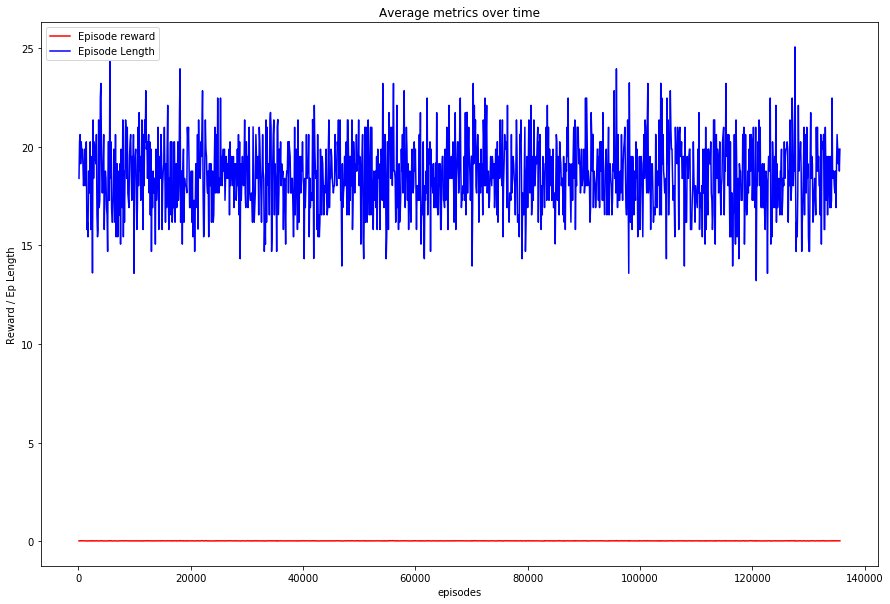

In [97]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best');

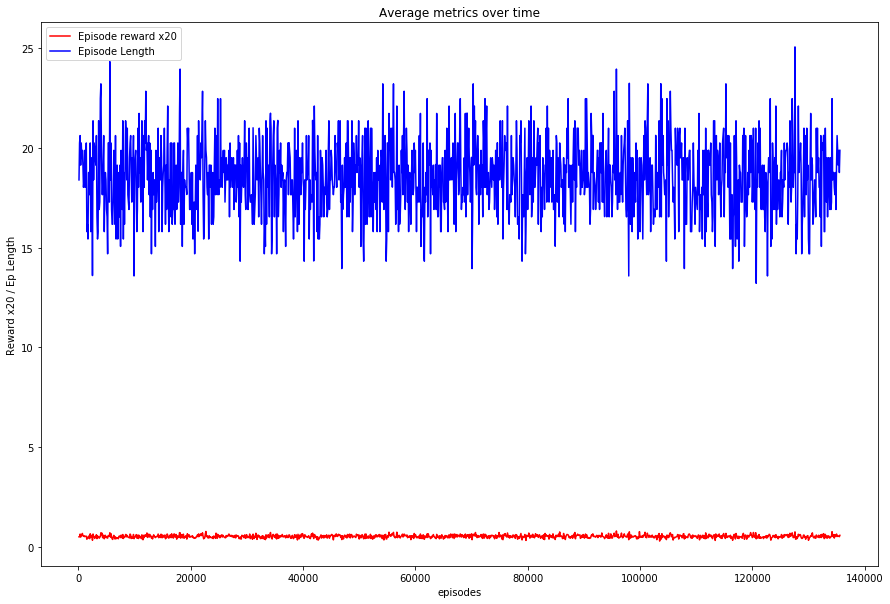

In [98]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best');

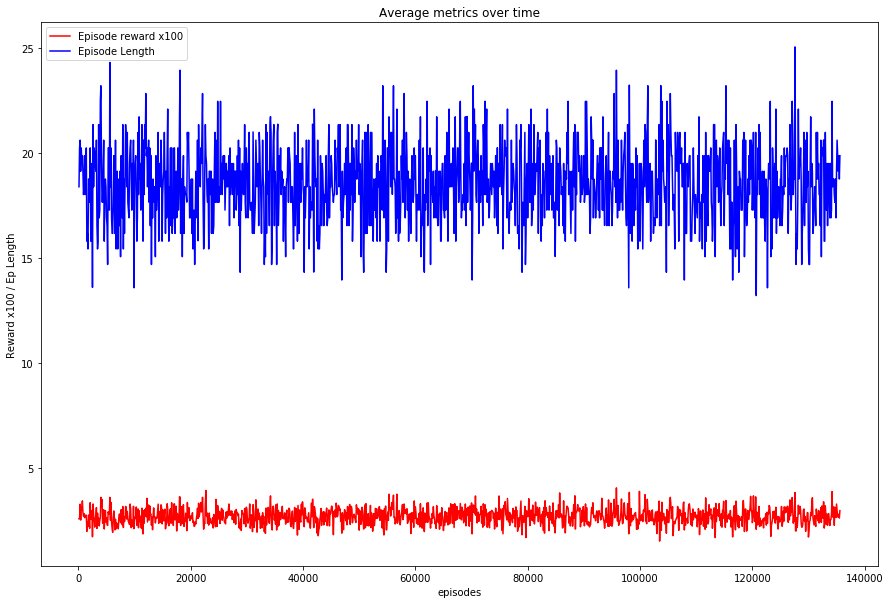

In [99]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best');

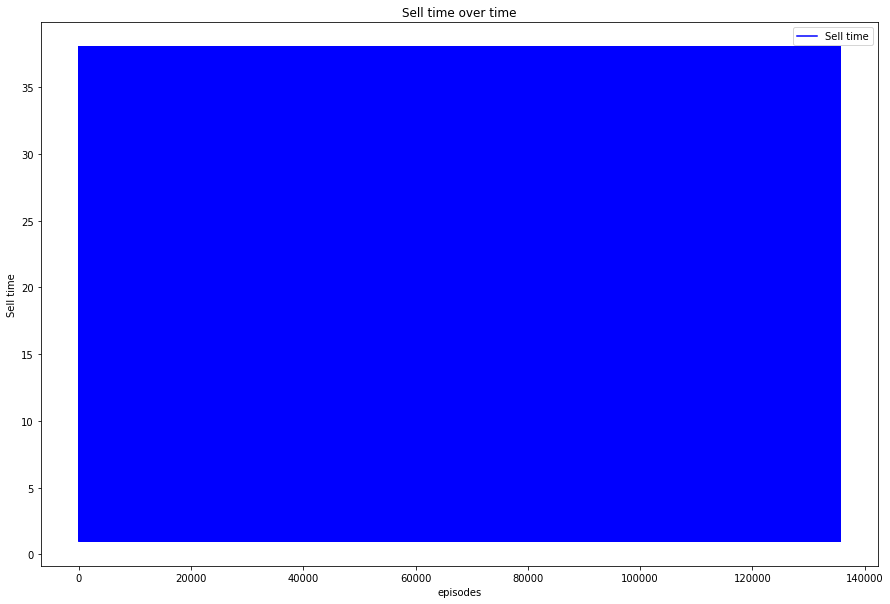

In [100]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Print size of remaining objects

In [101]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
list_objects = sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)
#print(list_objects)
for x,y in list_objects:
    print(str(x)+": "+str(y))
    del x

eList: 5429648
sTimeListMA: 5424096
NonRandom_option_percentage_rList: 4290016
NonRandom_option_real_percentage_rList: 4290016
NonRandom_percentage_rList: 4290016
NonRandom_real_percentage_rList: 4290016
NonRandomrList: 4290016
NonRandomsTimeList: 4290016
state_train: 3145872
jList: 1174048
maxPossibleOptionP_returnList: 1174048
maxPossibleOptionR_P_returnList: 1174048
maxPossibleP_returnList: 1174048
maxPossibleR_P_returnList: 1174048
maxPossiblerList: 1174048
option_percentage_rList: 1174048
option_real_percentage_rList: 1174048
percentage_rList: 1174048
rList: 1174048
real_percentage_rList: 1174048
sTimeList: 1174048
AvgLossList: 54568
AvgMainHoldQList: 54568
AvgMainMaxQList: 54568
AvgMainQList: 54568
AvgMainSellQList: 54568
AvgNonRandomrList: 54568
AvgNonRandomsTimeList: 54568
AvgQSellLossList: 54568
AvgTargetQList: 54568
AvgrListMA: 54336
AvgsTimeListMA: 54336
AvgNonRandomrListMA: 53056
AvgNonRandomsTimeListMA: 53056
targetQ: 39008
terminal: 39008
doubleQ: 19552
AvgEpisodeList: 11